# Data - How Institutions of Higher Education Can Mine The Key Ingredient of  A Successful Analytics Program

The development of data analytics programs that foster robust decision support systems have become a key component of strategic initiatives for institutions of higher-education. However, college and university leadership teams remain unsure of how to effectively incorporate analytics into the institution's operations.

The object of this project is to explore the power of a predictive system based on the notion that at the end of each semester we can diagnose the chances of a student graduating in 4 years based on all available information up to that point. 

One main objective is to identify an information saturation point upon which actionable intervention is implemented. The hypothesis is that there exists a local maxima saturation point which provides the most appropriate intervention point.

# Tools

In [1]:
# General
from __future__ import print_function, division
import sys

# Database
import cx_Oracle
from sqlalchemy import create_engine
from getpass import getpass

# Tools
import pandas as pd
import seaborn as sns
import random
import string
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas_profiling

pd.options.display.max_columns = None

# Analytics
#import pymc3 as pm
from scipy.stats import beta

#IMBALANCED DATA
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#SciKitLearn Models
from sklearn.linear_model import LogisticRegression, ElasticNetCV, SGDClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier #(wait for scikit release 18.0)
from sklearn.neighbors import KNeighborsClassifier

#XgBoost Model ###################################################################################
# import os
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
##################################################################################################

#MODEL SELECTION, #EVALUATION METRICS
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

# Academic Data: Performance & Demographics

#### Grades Data
First we obtain the students grades along with a few variables. The goal is to aggregate the grade records to a semester summary.

In [2]:
username = input('Enter username: ')

Enter username: japitz


In [3]:
password = getpass(prompt='Enter password: ')

Enter password: ········


In [4]:
service_name = 'iraarch'
host = 'ira-oradb01.its.csulb.edu'
port = '1521'
grades_query = 'grd.sql'
dem_query = 'dae.sql'

def db_query(username, password, service_name, host, port, query):

    dsn = cx_Oracle.makedsn(host, port, service_name=service_name)

    cstr = 'oracle://{user}:{password}@{dsn}'.format(
        user=username,
        password=password,
        dsn=dsn
    )

    engine =  create_engine(
        cstr,
        convert_unicode=False,
        pool_recycle=10,
        pool_size=50,
    )

    with open(query, 'r') as f:
        data=f.read()#.replace('\n', '')
        
    return (data, engine)

In [5]:
grades, engine = db_query(username, password, service_name, host, port, grades_query)
grd = pd.read_sql(grades, engine)

demo, engine = db_query(username, password, service_name, host, port, dem_query)
dem = pd.read_sql(demo, engine)


print(grd.shape)
print(dem.shape)

(300329, 39)
(4276, 24)


In [6]:
grd.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300329 entries, 0 to 300328
Data columns (total 39 columns):
cohort                     300329 non-null object
emplid                     300329 non-null object
term_code                  300329 non-null object
class_term                 300329 non-null object
session_code               300329 non-null object
eot_acad_career            300329 non-null object
eot_program_cd             300329 non-null object
eot_program                300329 non-null object
eot_college_cd             300298 non-null object
eot_college                300298 non-null object
eot_department_cd          300298 non-null object
eot_department             300298 non-null object
eot_acad_plan_cd           300329 non-null object
eot_acad_plan              300329 non-null object
class_college_code         300260 non-null object
class_college              300260 non-null object
class_dept_code            300260 non-null object
class_dept                 300260 non-n

In [7]:
dem.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4276 entries, 0 to 4275
Data columns (total 24 columns):
emplid                   4276 non-null object
dem_cohort               4276 non-null object
dem_diff_indx            2947 non-null float64
dae_emplid               4276 non-null object
gender                   4276 non-null object
ethnicity                4276 non-null object
first_generation         4276 non-null object
dep_family_size          4276 non-null object
minority                 4276 non-null object
applicant_family_size    4276 non-null object
applicant_income         4276 non-null object
pelltot_emplid           2467 non-null object
pell_eligibility         2467 non-null object
esa_emplid               4276 non-null object
act_comp                 1426 non-null float64
act_read                 1426 non-null float64
act_math                 1426 non-null float64
act_eng                  1425 non-null float64
act_sci                  1426 non-null float64
sat_read     

In [8]:
#Change 'UNKNOWN' to more unique string to avoid having columns with same name after one-hot-encode

dem['first_generation'] = dem['first_generation'].apply(lambda x: 'First Generation Unknown' if x == 'UNKNOWN' else x)
dem['ethnicity'] = dem['ethnicity'].apply(lambda x: 'ETHNICITY UNKNOWN' if x == 'UNKNOWN' else x)

##### Create Training and Test/Validation Sets of Students at this stage to avoid leakeage 

In [9]:
students = pd.DataFrame(grd['emplid'].unique(), columns=['emplid'])

print('there are {} students'.format(students.shape[0]))

there are 8216 students


##### Create the Grades Trainning and Validation Student Set

In [10]:
students_train, students_dev = train_test_split(students, test_size=0.10, random_state=42)

students_train = pd.DataFrame(students_train)

students_dev = pd.DataFrame(students_dev)

In [11]:
students_train.columns = ['EMPLID']
students_dev.columns = ['EMPLID']

In [12]:
grd[grd['emplid']=='011155428'].sort_values(by=['term_code'])

,cohort,emplid,term_code,class_term,session_code,eot_acad_career,eot_program_cd,eot_program,eot_college_cd,eot_college,eot_department_cd,eot_department,eot_acad_plan_cd,eot_acad_plan,class_college_code,class_college,class_dept_code,class_dept,class_prefix,class_prefix_longdesc,class_catalog_nbr,class_section,class_descr,bcmp,bcmp_units_taken,online_course,units_taken,grading_basis,official_grade,earned_credit,units_attempted,grade_points,status_cd,ge_flag,division,gpa_flag,class_instruction_mode,class_instructor_emplid,home_zip_cd
264479,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,WGSS,Women's Gender Sexuality Stds,WGSS,Women's Gender Sexuality Stds,101,06,Women & Their Bodies,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,001420573,92683
251404,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PSY,Psychology,PSY,Psychology,100,01,General Psychology,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,000003300,92683
226442,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PHIL,Philosophy,PHIL,Philosophy,170,04,Critical Reasoning,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,006822970,92683
272527,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,HIST,History,HIST,History,173,15,Recent United States History,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,005157605,92683
272529,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CHHS,Health and Human Services,KIN,Kinesiology,KIN,Kinesiology,109A,02,Fitness Walking,0,0,Not_Online,1.0,GCR,A,Y,Y,4.0,E,Non_GE,Lower-Division,Include_in_GPA,P,000041481,92683
264495,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,ENGL,English,ENGL,English,100,34,Composition II,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,000040389,92683
263863,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,06,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009460618,92683
257294,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,01,General Organic & Biochemistry,1,5,Not_Online,5.0,GRD,C,Y,Y,10.0,E,GE,Lower-Division,Include_in_GPA,P,000033863,92683
238609,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,MATH,Mathematics,MATH,Mathematics,109,11,Modeling With Algebra,1,3,Not_Online,3.0,GCR,A,Y,Y,12.0,E,GE,Lower-Division,Include_in_GPA,P,008331555,92683
211121,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,13,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009416548,92683


# Preprocessing: One-Hot-Encode Letter Grades

In [13]:
grd.columns = map(str.upper, grd.columns)

In [14]:
grd = pd.concat([grd,pd.get_dummies(grd['OFFICIAL_GRADE'], drop_first=True)], axis=1)

grd.shape

(300329, 52)

##### Create Variables to Calculate GPA

In [15]:
grd['GRADE_POINTS_IN_GPA'] = grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_IN_GPA'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_FOR_CREDIT'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

#######################################################################################################################

grd['BCMP_GRADE_POINTS_IN_GPA'] = grd['BCMP'] * grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_IN_GPA'] = grd['BCMP_UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_FOR_CREDIT'] = grd['BCMP'] * grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

In [16]:
grd['SUMMER'] = (grd['CLASS_TERM'].apply(lambda x: str(x)[-1]) == '3')* 1 * grd['UNITS_FOR_CREDIT']

grd['WINTER'] = (grd['CLASS_TERM'].apply(lambda x: str(x)[-1]) == '1')* 1 * grd['UNITS_FOR_CREDIT']

##### Reduce the dataframe to variables of current interest

In [17]:
grd = grd.sort_values(by=['EMPLID','TERM_CODE']).copy()[['COHORT', 
                 'EMPLID', 
                 'TERM_CODE',
                 'EOT_ACAD_PLAN_CD',
                 'GRADE_POINTS_IN_GPA',
                 'UNITS_TAKEN',
                 'UNITS_IN_GPA',
                 'UNITS_FOR_CREDIT',
                 'BCMP',
                 'BCMP_GRADE_POINTS_IN_GPA',
                 'BCMP_UNITS_TAKEN',
                 'BCMP_UNITS_IN_GPA',
                 'BCMP_UNITS_FOR_CREDIT',
                 'A', 
                 'AU', 
                 'B',
                 'C', 
                 'CR', 
                 'D', 
                 'F', 
                 'I', 
                 'NC', 
                 'RP', 
                 'W', 
                 'WE', 
                 'WU',
                 'SUMMER',
                 'WINTER']]

##### Aggregate and Reduce from Course Dimension to Term Dimension: Create a cummulative sum of Grade Points and GPA Units:

In [18]:
aggregations = { 'GRADE_POINTS_IN_GPA':'sum',
                 'UNITS_TAKEN':'sum',
                 'UNITS_IN_GPA':'sum',
                 'UNITS_FOR_CREDIT':'sum',
                 'BCMP':'sum',
                 'BCMP_GRADE_POINTS_IN_GPA':'sum',
                 'BCMP_UNITS_TAKEN':'sum',
                 'BCMP_UNITS_IN_GPA':'sum',
                 'BCMP_UNITS_FOR_CREDIT':'sum',
                 'A':'sum', 
                 'AU':'sum', 
                 'B':'sum',
                 'C':'sum', 
                 'CR':'sum', 
                 'D':'sum', 
                 'F':'sum', 
                 'I':'sum', 
                 'NC':'sum', 
                 'RP':'sum', 
                 'W':'sum', 
                 'WE':'sum', 
                 'WU':'sum',
               'SUMMER':'sum',
               'WINTER':'sum'}

grouped_agg = grd.groupby(['COHORT','EMPLID','TERM_CODE','EOT_ACAD_PLAN_CD']).agg(aggregations).reset_index()

In [19]:
grouped_agg.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER
0,2124,000571920,2124,ENGLBA01U1,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0,0,2,0,0,0,1,0,0,0,0,0,0,0.0,0.0
1,2124,000571920,2132,ENGLBA01U1,24.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.0
2,2124,000571920,2134,ENGLBA01U1,33.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,9.0,0.0
3,2124,000571920,2142,ENGLBA01U1,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
4,2124,000571920,2144,ENGLBA01U1,30.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0


In [20]:
grouped_cumsum = grd[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'GRADE_POINTS_IN_GPA',
                             'UNITS_TAKEN',
                             'UNITS_IN_GPA',
                             'UNITS_FOR_CREDIT',
                             'BCMP',
                             'BCMP_GRADE_POINTS_IN_GPA',
                             'BCMP_UNITS_TAKEN',
                             'BCMP_UNITS_IN_GPA',
                             'BCMP_UNITS_FOR_CREDIT',
                             'SUMMER',
                             'WINTER']].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'COHORT',
                                                 'EOT_ACAD_PLAN_CD',]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

grd = pd.concat([grouped_agg,grouped_cumsum],axis=1)

grd.drop(['CUM_EMPLID','CUM_TERM_CODE','CUM_COHORT','CUM_EOT_ACAD_PLAN_CD'],axis=1,inplace=True)

#### Create Term and Cummulative GPA

In [21]:
grd['TERM_GPA'] = grd['GRADE_POINTS_IN_GPA'] / grd['UNITS_IN_GPA']

grd['CUM_GPA'] = grd['CUM_GRADE_POINTS_IN_GPA'] / grd['CUM_UNITS_IN_GPA']

grd['BCMP_TERM_GPA'] = grd['BCMP_GRADE_POINTS_IN_GPA'] / grd['BCMP_UNITS_IN_GPA']

grd['BCMP_CUM_GPA'] = grd['CUM_BCMP_GRADE_POINTS_IN_GPA'] / grd['CUM_BCMP_UNITS_IN_GPA']

##### Check for NaN values since division by 0 is possible:

In [22]:
grd.isnull().sum()

COHORT                              0
EMPLID                              0
TERM_CODE                           0
EOT_ACAD_PLAN_CD                    0
GRADE_POINTS_IN_GPA                 0
UNITS_TAKEN                         0
UNITS_IN_GPA                        0
UNITS_FOR_CREDIT                    0
BCMP                                0
BCMP_GRADE_POINTS_IN_GPA            0
BCMP_UNITS_TAKEN                    0
BCMP_UNITS_IN_GPA                   0
BCMP_UNITS_FOR_CREDIT               0
A                                   0
AU                                  0
B                                   0
C                                   0
CR                                  0
D                                   0
F                                   0
I                                   0
NC                                  0
RP                                  0
W                                   0
WE                                  0
WU                                  0
SUMMER      

###### Need to deal with NaN values - use imputation

##### impute missing Term and Cum GPA

In this instance it is reasonable to set the Term GPA and CumGPA to zero since NaNs result from Units in GPA and Cum Units in GPA being zero. This means either the student had no Units in GPA for a given term or the Cum Units in GPA was zero since the student failed to pass units in the initial term

In [23]:
grd.fillna(0, inplace=True)

##### Example of students with CumGPA = 0 

In [24]:
grd[grd['CUM_GPA'] == 0].head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
109,2124,003028998,2123,UCESOT00OU,0.0,3.0,3.0,3.0,1,0.0,3,3.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,3.0,3.0,3.0,1,0.0,3,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
643,2124,005601022,2124,I/STBA01U1,0.0,12.0,12.0,12.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,4,0,0,0,0,0,0,0.0,0.0,0.0,12.0,12.0,12.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911,2124,006205834,2124,ECONBA03U1,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0.0,0.0,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,2124,006230976,2124,MGMTBS01U1,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,0.0,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,2124,006230976,2132,MGMTBS01U1,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2,6.0,0.0,0.0,12.0,12.0,12.0,0,0.0,0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


In [25]:
emplid = '011375323'

grd[grd['EMPLID'] == emplid]

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
63245,2124,011375323,2124,NRSGBS02U1,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0,0.0,0.0,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Typically students with CumGPA = 0 fail or withdraw

In [26]:
grd[grd['EMPLID'] == emplid].iloc[0]

COHORT                                2124
EMPLID                           011375323
TERM_CODE                             2124
EOT_ACAD_PLAN_CD                NRSGBS02U1
GRADE_POINTS_IN_GPA                      0
UNITS_TAKEN                              9
UNITS_IN_GPA                             0
UNITS_FOR_CREDIT                         0
BCMP                                     0
BCMP_GRADE_POINTS_IN_GPA                 0
BCMP_UNITS_TAKEN                         0
BCMP_UNITS_IN_GPA                        0
BCMP_UNITS_FOR_CREDIT                    0
A                                        0
AU                                       0
B                                        0
C                                        0
CR                                       0
D                                        0
F                                        0
I                                        0
NC                                       0
RP                                       0
W          

# The Load Index

$L_s = \dfrac{\sum_{i=1}^{k_s} u_i}{U_s}$

$u_i: units\ \ earned \ \ by \ \ taking \ \ class \ \ i.$

$k_s: number \ \ of \ \ classes \ \ taken \ \ in \ \ semester \ \ s.$

$U_s: number \ \ of \ \ units \ \ prescribed \ \ to \ \ be \ \ earned \ \ by \ \ semester \ \ s.$

$The \ \ pattern \ \  of \ \ the \ \ difference \ \  d \ \ 0,7,8,9,10,17,18,19,20,... \ \ $

$Pattern \ \ when \ \ d \ \ mod \ \ 10 \ \ is \ \ 0$    $$N = 2\dfrac{d}{10} + 1 = \dfrac{d}{5} + 1$$

Pattern when d mod 10 is 8    $$N = 2\left(\dfrac{d - 8}{10} + 1\right) = \dfrac{d + 2}{5}$$

In [27]:
grd['TERM_DIFF'] = pd.to_numeric(grd['TERM_CODE']) - pd.to_numeric(grd['COHORT'])

grd['N'] = grd['TERM_DIFF'].apply(lambda x: int(x/5+1) if x%10 == 0 else int((x + 2)/5) )

grd['PRESCRIBED_UNITS'] = grd['N'] * 15

In [28]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS
0,2124,000571920,2124,ENGLBA01U1,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0,0,2,0,0,0,1,0,0,0,0,0,0,0.0,0.0,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0.0,0.0,1.800000,1.800000,0.0,0.0,0,1,15
1,2124,000571920,2132,ENGLBA01U1,24.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.0,42.0,16.0,16.0,16.0,0,0.0,0,0.0,0.0,6.0,0.0,4.000000,2.625000,0.0,0.0,8,2,30
2,2124,000571920,2134,ENGLBA01U1,33.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,9.0,0.0,75.0,25.0,25.0,25.0,0,0.0,0,0.0,0.0,15.0,0.0,3.666667,3.000000,0.0,0.0,10,3,45
3,2124,000571920,2142,ENGLBA01U1,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,84.0,28.0,28.0,28.0,0,0.0,0,0.0,0.0,15.0,0.0,3.000000,3.000000,0.0,0.0,18,4,60
4,2124,000571920,2144,ENGLBA01U1,30.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,114.0,37.0,37.0,37.0,0,0.0,0,0.0,0.0,15.0,0.0,3.333333,3.081081,0.0,0.0,20,5,75


In [29]:
grd[['EMPLID','TERM_CODE','N']].head(19)

,EMPLID,TERM_CODE,N
0,000571920,2124,1
1,000571920,2132,2
2,000571920,2134,3
3,000571920,2142,4
4,000571920,2144,5
5,000571920,2152,6
6,000571920,2154,7
7,000571920,2162,8
8,000571920,2164,9
9,002638166,2124,1


In [30]:
grd['LOAD_INDEX'] = grd['CUM_UNITS_FOR_CREDIT'] / grd['PRESCRIBED_UNITS']

grd['COMPLETION_RATE'] = grd['UNITS_FOR_CREDIT'] / grd['UNITS_TAKEN']

## Create The Exclusive Load Index 

In [31]:
grd['UNITS_FOR_CREDIT_EXCLUDE'] = (grd['TERM_DIFF'] >= 0) * grd['UNITS_FOR_CREDIT']

grouped_cumsum = grd[['EMPLID',
                      'TERM_CODE',
                      'COHORT',
                      'UNITS_FOR_CREDIT_EXCLUDE']].groupby(['EMPLID',
                                                                 'TERM_CODE',
                                                                 'COHORT']).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

grd = pd.concat([grd,grouped_cumsum],axis=1)

grd['N_EXCLUDE'] = grd['TERM_DIFF'].apply(lambda x: 0 if x < 0 else(int(x/5+1) if int(repr(x)[-1]) == 0 else int((x + 2)/5) ))

grd['PRESCRIBED_UNITS_EXCLUDE'] = grd['N_EXCLUDE'] * 15

grd['LOAD_INDEX_EXCLUDE'] = grd['CUM_UNITS_FOR_CREDIT_EXCLUDE'] / grd['PRESCRIBED_UNITS_EXCLUDE']

In [32]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,CUM_EMPLID,CUM_TERM_CODE,CUM_COHORT,CUM_UNITS_FOR_CREDIT_EXCLUDE,N_EXCLUDE,PRESCRIBED_UNITS_EXCLUDE,LOAD_INDEX_EXCLUDE
0,2124,000571920,2124,ENGLBA01U1,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0,0,2,0,0,0,1,0,0,0,0,0,0,0.0,0.0,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0.0,0.0,1.800000,1.800000,0.0,0.0,0,1,15,0.666667,1.0,10.0,000571920,2124,2124,10.0,1,15,0.666667
1,2124,000571920,2132,ENGLBA01U1,24.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.0,42.0,16.0,16.0,16.0,0,0.0,0,0.0,0.0,6.0,0.0,4.000000,2.625000,0.0,0.0,8,2,30,0.533333,1.0,6.0,000571920,2132,2124,16.0,2,30,0.533333
2,2124,000571920,2134,ENGLBA01U1,33.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,9.0,0.0,75.0,25.0,25.0,25.0,0,0.0,0,0.0,0.0,15.0,0.0,3.666667,3.000000,0.0,0.0,10,3,45,0.555556,1.0,9.0,000571920,2134,2124,25.0,3,45,0.555556
3,2124,000571920,2142,ENGLBA01U1,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,84.0,28.0,28.0,28.0,0,0.0,0,0.0,0.0,15.0,0.0,3.000000,3.000000,0.0,0.0,18,4,60,0.466667,1.0,3.0,000571920,2142,2124,28.0,4,60,0.466667
4,2124,000571920,2144,ENGLBA01U1,30.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,114.0,37.0,37.0,37.0,0,0.0,0,0.0,0.0,15.0,0.0,3.333333,3.081081,0.0,0.0,20,5,75,0.493333,1.0,9.0,000571920,2144,2124,37.0,5,75,0.493333


## Create the Only Prior Load Index Indicator

In [33]:
grd['LOAD_INDEX_ONLY']=grd['LOAD_INDEX']-grd['LOAD_INDEX_EXCLUDE']

grouped_diff = grd[['EMPLID', 'LOAD_INDEX_ONLY']].groupby(['EMPLID']).transform(max).reset_index()

grd = grd.drop(columns='LOAD_INDEX_ONLY')

grd = pd.concat([grd,grouped_diff],axis=1)

## Create DFW Variables

In [34]:
grd['DFW'] = grd['D'] + grd['F'] + grd['I'] + grd['NC'] + grd['W'] + grd['WE'] + grd['WU']

grd['DFW_RATE'] = grd['DFW']/grd['UNITS_TAKEN']

## Select Varaibles

In [35]:
grd.drop(labels=['GRADE_POINTS_IN_GPA','UNITS_IN_GPA','BCMP_GRADE_POINTS_IN_GPA',
                'BCMP_UNITS_IN_GPA','CUM_GRADE_POINTS_IN_GPA', 
                'CUM_UNITS_IN_GPA', 'CUM_BCMP_GRADE_POINTS_IN_GPA', 'TERM_DIFF', 
                 'CUM_EMPLID', 'CUM_TERM_CODE', 'CUM_COHORT',
                 'CUM_UNITS_FOR_CREDIT_EXCLUDE', 'N_EXCLUDE', 'PRESCRIBED_UNITS_EXCLUDE', 'index'],axis=1, inplace=True)

## Exclude Rows Before $T_0$

In [36]:
grd = grd[grd['COHORT'] <= grd['TERM_CODE']]

##### The Completion Rate calculation generated a few NaNs

Setting these NaNs to zero is appropriate since they result from dividing by zero (no units taken)

In [37]:
grd.fillna(0, inplace=True)

## Demographic Data

In [38]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP'],
      dtype='object')

### One-Hot-Encode Demographics

In [39]:
dem = pd.concat([dem,
                pd.get_dummies(dem['GENDER'], drop_first=True, prefix='GENDR'),
                pd.get_dummies(dem['ETHNICITY'], drop_first=False),
                pd.get_dummies(dem['FIRST_GENERATION'], drop_first=False),
                pd.get_dummies(dem['DEP_FAMILY_SIZE'], drop_first=False, prefix='DEP_FAM'),
                pd.get_dummies(dem['MINORITY'], drop_first=False, prefix='URM'), 
                pd.get_dummies(dem['APPLICANT_FAMILY_SIZE'], drop_first=False, prefix='APP_FAM'),
                pd.get_dummies(dem['APPLICANT_INCOME'], drop_first=False, prefix='INCM'),
                pd.get_dummies(dem['PELL_ELIGIBILITY'], drop_first=False, prefix='PELL')], axis=1)

In [40]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'URM_UNKNOWN',
     

In [41]:
dem.drop(labels=['GENDER', 'ETHNICITY', 'FIRST_GENERATION',
       'DEP_FAMILY_SIZE', 'MINORITY', 'APPLICANT_FAMILY_SIZE',
       'APPLICANT_INCOME', 'PELL_ELIGIBILITY'], axis=1, inplace=True)

### Create Time to Graduation Response Variables

In [42]:
dem['DEM_N'] = dem['DEM_DIFF_INDX'].apply(lambda x: x if (x >= 0) == False 
                             else int(x/5+1) if (x%10 == 0 or x%10 == 7) 
                             else int((x + 2)/5) )

dem['YRS_TO_GRAD'] = dem['DEM_N'] * 0.5

In [43]:
dem[['DEM_DIFF_INDX','YRS_TO_GRAD']].head(12)

,DEM_DIFF_INDX,YRS_TO_GRAD
0,NaN,NaN
1,50.0,5.5
2,NaN,NaN
3,NaN,NaN
4,40.0,4.5
5,38.0,4.0
6,39.0,4.0
7,40.0,4.5
8,NaN,NaN
9,38.0,4.0


In [44]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'PELLTOT_EMPLID',
       'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI',
       'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP', 'GENDR_M',
       'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'URM_UNKNOWN',
       'URM_VISA NON U.S.', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
    

In [45]:
dem = pd.concat([dem,pd.get_dummies(dem['YRS_TO_GRAD'], drop_first=False, prefix='GRAD_IN')], axis=1)

In [46]:
dem.drop(labels=['DEM_DIFF_INDX','DEM_N','DAE_EMPLID','PELLTOT_EMPLID','ESA_EMPLID',
                 'YRS_TO_GRAD'], axis=1, inplace=True)

In [47]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'URM_UNKNOWN',
       'URM_VISA NON U.S.', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'INCM_NO RESPONSE',

In [48]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'URM_UNKNOWN',
       'URM_VISA NON U.S.', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'INCM_NO RESPONSE',

### Join the Demographic Data with the CSULB Academic Performance Data

In [49]:
supreme = pd.merge(dem, grd, on='EMPLID', how='left')

In [50]:
#pandas_profiling.ProfileReport(supreme)

In [51]:
#pandas_profiling.ProfileReport(supreme).get_rejected_variables()

In [52]:
supreme.drop(labels=[ 'DFW',
                      'DEM_COHORT',
                      'AP',
                      'BCMP_UNITS_FOR_CREDIT',
                      'BCMP_UNITS_TAKEN',
                      'CUM_BCMP_UNITS_FOR_CREDIT',
                      'CUM_BCMP_UNITS_IN_GPA',
                      'CUM_BCMP_UNITS_TAKEN',
                      'CUM_UNITS_FOR_CREDIT',
                      'INCM_NO RESPONSE',
                      'UNITS_FOR_CREDIT',
                      'URM_UNKNOWN',
                      'URM_VISA NON U.S.'], axis=1, inplace=True)

In [53]:
pd.options.display.max_seq_items = supreme.columns.shape[0]

supreme.columns

Index(['EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI',
       'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'GENDR_M',
       'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL',
       'PELL_TRADITIONAL', 'GRAD_IN_2.5', 'GRAD_IN_

### ACT, SAT and HS GPA Scores Preprocessing

Students may have ACT or SAT or both scores. The idea is to create a feature that would capture test performance in a general sense. The approach use here is to create three features that capture performance in Math, Reading and Composite performance. To this end we scale and center both ACT and SAT test scores in math, reading and composite and, in the event a student has taken both,choose the maximum normalized score.

##### Need to impute missing values of ACT and SAT scores:

Before this preprocessing step is undertaken it is necessary to split the student data into trainning and development sets in order to avoid "leakeage" from trainning into development since the imputing calculations and methods use the entire dataset.

In [54]:
supreme['N'].head()

0    1
1    2
2    5
3    6
4    7
Name: N, dtype: int64

In [55]:
supreme_train = pd.merge(students_train, supreme, on='EMPLID', how='inner')
print(supreme_train.shape)

supreme_dev = pd.merge(students_dev, supreme, on='EMPLID', how='inner')
print(supreme_dev.shape)

(34844, 93)
(3988, 93)


In [56]:
supreme_train.isnull().sum().head(55)

EMPLID                                       0
ACT_COMP                                 23060
ACT_READ                                 23060
ACT_MATH                                 23060
ACT_ENG                                  23072
ACT_SCI                                  23060
SAT_READ                                  1935
SAT_MATH                                  1935
SAT_COMP                                  1935
GPA_HS                                     363
GENDR_M                                      0
AFRICAN AMERICAN                             0
ASIAN AMERICAN                               0
CAUCASIAN                                    0
ETHNICITY UNKNOWN                            0
LATINO/LATINA                                0
NATIVE AMERICAN                              0
PACIFIC ISLANDER                             0
TWO OR MORE RACES, INCLUDING MINORITY        0
TWO OR MORE RACES, NON-MINORITIES            0
VISA NON U.S.                                0
CONTINUING GE

In [57]:
supreme_train.iloc[:,44:57].columns

Index(['APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL',
       'PELL_TRADITIONAL', 'GRAD_IN_2.5', 'GRAD_IN_3.0', 'GRAD_IN_3.5',
       'GRAD_IN_4.0', 'GRAD_IN_4.5', 'GRAD_IN_5.0'],
      dtype='object')

In [58]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP', 'GPA_HS']].head()

,ACT_COMP,ACT_READ,ACT_MATH,ACT_ENG,ACT_SCI,SAT_READ,SAT_MATH,SAT_COMP,GPA_HS
0,NaN,NaN,NaN,NaN,NaN,480.0,480.0,960.0,270.0
1,NaN,NaN,NaN,NaN,NaN,480.0,480.0,960.0,270.0
2,NaN,NaN,NaN,NaN,NaN,450.0,460.0,910.0,376.0
3,NaN,NaN,NaN,NaN,NaN,450.0,460.0,910.0,376.0
4,NaN,NaN,NaN,NaN,NaN,450.0,460.0,910.0,376.0


In [59]:
supreme_train['N'].head()

0    1
1    2
2    1
3    2
4    3
Name: N, dtype: int64

##### Scale the scores and choose the max

In [60]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [61]:
supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [62]:
print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].mean()
)

print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].std()
)

ACT_COMP    3.886534e-16
ACT_READ   -1.124958e-15
ACT_MATH   -3.963508e-16
ACT_ENG     4.417998e-16
ACT_SCI    -1.741837e-15
SAT_READ    7.882722e-16
SAT_MATH   -8.881784e-16
SAT_COMP    2.246254e-15
dtype: float64
ACT_COMP    1.000042
ACT_READ    1.000042
ACT_MATH    1.000042
ACT_ENG     1.000042
ACT_SCI     1.000042
SAT_READ    1.000015
SAT_MATH    1.000015
SAT_COMP    1.000015
dtype: float64


In [63]:
supreme_train['T_COMP'] = supreme_train[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_train['T_READ'] = supreme_train[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_train['T_MATH'] = supreme_train[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [64]:
supreme_dev['T_COMP'] = supreme_dev[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_READ'] = supreme_dev[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_MATH'] = supreme_dev[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [65]:
supreme_train[['T_COMP','T_READ','T_MATH']].isnull().sum()

T_COMP    704
T_READ    704
T_MATH    704
dtype: int64

##### For now impute values by using the mean

In [66]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [67]:
test_scores = supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

In [68]:
test_scores = supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

##### Drop unecessary features

In [69]:
supreme_train['N'].head()

0    1
1    2
2    1
3    2
4    3
Name: N, dtype: int64

In [70]:
supreme_train.columns[30:50]

Index(['DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7',
       'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL'],
      dtype='object')

In [71]:
supreme_train.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

supreme_dev.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

##### The AP feature is null - impute with a constant for now

In [72]:
supreme_train['AP'] = 0

supreme_dev['AP'] = 0

In [73]:
supreme_train.isnull().sum().head(55)

EMPLID                                   0
GPA_HS                                   0
GENDR_M                                  0
AFRICAN AMERICAN                         0
ASIAN AMERICAN                           0
CAUCASIAN                                0
ETHNICITY UNKNOWN                        0
LATINO/LATINA                            0
NATIVE AMERICAN                          0
PACIFIC ISLANDER                         0
TWO OR MORE RACES, INCLUDING MINORITY    0
TWO OR MORE RACES, NON-MINORITIES        0
VISA NON U.S.                            0
CONTINUING GENERATION STUDENT            0
FIRST GENERATION STUDENT                 0
FIRST GENERATION UNKNOWN                 0
DEP_FAM_1                                0
DEP_FAM_10                               0
DEP_FAM_12                               0
DEP_FAM_15                               0
DEP_FAM_2                                0
DEP_FAM_25                               0
DEP_FAM_3                                0
DEP_FAM_4  

### Create the Major Plan Change Index

##### Academic plans are 10 characters in length

In [74]:
supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: len(x)).describe()

count    34844.0
mean        10.0
std          0.0
min         10.0
25%         10.0
50%         10.0
75%         10.0
max         10.0
Name: EOT_ACAD_PLAN_CD, dtype: float64

##### The first 4 characters representthe department/subject. The 5th and 6th character encode the plan type and allows to separate pre-majors from majors. A change from pre-major to major in the same department/subject is not considered a major change.

In [75]:
print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6]).head()
)

print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4]).head()
)

0    PR
1    PR
2    PR
3    PR
4    PR
Name: EOT_ACAD_PLAN_CD, dtype: object
0    CBA_
1    CBA_
2    BIOL
3    BIOL
4    L/ST
Name: EOT_ACAD_PLAN_CD, dtype: object


##### Create codes

In [76]:
supreme_train['SUBJECT'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_train['PLAN_TYPE'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [77]:
supreme_dev['SUBJECT'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_dev['PLAN_TYPE'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [78]:
supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].head()

,EMPLID,SUBJECT,PLAN_TYPE
0,011193375,CBA_,PR
1,011193375,CBA_,PR
2,010841881,BIOL,PR
3,010841881,BIOL,PR
4,010841881,L/ST,PR


##### Create Major Change indicator

In [79]:
supreme_train['MAJOR_CHANGE_INDICATOR'] = ( supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)

In [80]:
supreme_dev['MAJOR_CHANGE_INDICATOR'] = ( supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)


##### Create a cumulative Major Change Counter

In [81]:
grouped_cumsum = supreme_train[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'MAJOR_CHANGE_INDICATOR'
                             ]].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'EOT_ACAD_PLAN_CD',
                                                 'COHORT',
                                                 ]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_train = pd.concat([supreme_train,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_train.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

In [82]:
grouped_cumsum = supreme_dev[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'MAJOR_CHANGE_INDICATOR'
                             ]].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'EOT_ACAD_PLAN_CD',
                                                 'COHORT',
                                                 ]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_dev = pd.concat([supreme_dev,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_dev.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

##### Rearrange features

In [83]:
supreme_train.columns

Index(['EMPLID', 'GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN',
       'CAUCASIAN', 'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL',
       'PELL_TRADITIONAL', 'GRAD_IN_2.5', 'GRAD_IN_3.0', 'GRAD_IN_3.5',
       'GRAD_IN_4.0', 'GRAD_IN_4.5', 'GRAD_IN_5.0', 'GRAD_IN_5.5',
       'GRAD_IN_6.0'

In [84]:
id_var = ['COHORT', 'EMPLID']

perf_var = ['TERM_CODE', 'SEMESTER_INDEX', 'EOT_ACAD_PLAN_CD', 'MAJOR_CHANGE_INDICATOR','MAJOR_CHANGE_CNT',
            'UNITS_TAKEN','BCMP', 'A', 'AU', 'B' ,'C','CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER', 
            'CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 'TERM_GPA','CUM_GPA', 'BCMP_TERM_GPA', 'BCMP_CUM_GPA',
            'COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY','DFW_RATE','T_COMP', 'T_READ','T_MATH']

dem_var = ['GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN','ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 
           'NATIVE AMERICAN','PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
           'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.','CONTINUING GENERATION STUDENT', 
           'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN','DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
           'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6','DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 
           'DEP_FAM_NA', 'URM_MINORITY','URM_NON-MINORITY', 'APP_FAM_1',
           'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA','INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
           'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL', 
           'PELL_TRADITIONAL']

resp_var = ['GRAD_IN_2.5','GRAD_IN_3.0', 'GRAD_IN_3.5', 'GRAD_IN_4.0', 'GRAD_IN_4.5','GRAD_IN_5.0', 'GRAD_IN_5.5', 
          'GRAD_IN_6.0']

eyError: "[, 'CUM_UNITS_FOR_CREDIT'] not in index"

In [85]:
supreme_train = supreme_train[id_var + perf_var + dem_var + resp_var]
supreme_dev = supreme_dev[id_var + perf_var + dem_var + resp_var]

In [86]:
for feature in supreme_train.columns: print(feature)

COHORT
EMPLID
TERM_CODE
SEMESTER_INDEX
EOT_ACAD_PLAN_CD
MAJOR_CHANGE_INDICATOR
MAJOR_CHANGE_CNT
UNITS_TAKEN
BCMP
A
AU
B
C
CR
D
F
I
NC
RP
W
WE
WU
SUMMER
CUM_BCMP
CUM_SUMMER
CUM_WINTER
TERM_GPA
CUM_GPA
BCMP_TERM_GPA
BCMP_CUM_GPA
COMPLETION_RATE
LOAD_INDEX_EXCLUDE
LOAD_INDEX_ONLY
DFW_RATE
T_COMP
T_READ
T_MATH
GPA_HS
GENDR_M
AFRICAN AMERICAN
ASIAN AMERICAN
CAUCASIAN
LATINO/LATINA
NATIVE AMERICAN
PACIFIC ISLANDER
TWO OR MORE RACES, INCLUDING MINORITY
TWO OR MORE RACES, NON-MINORITIES
ETHNICITY UNKNOWN
VISA NON U.S.
CONTINUING GENERATION STUDENT
FIRST GENERATION STUDENT
FIRST GENERATION UNKNOWN
DEP_FAM_1
DEP_FAM_10
DEP_FAM_12
DEP_FAM_15
DEP_FAM_2
DEP_FAM_25
DEP_FAM_3
DEP_FAM_4
DEP_FAM_5
DEP_FAM_6
DEP_FAM_7
DEP_FAM_8
DEP_FAM_9
DEP_FAM_NA
URM_MINORITY
URM_NON-MINORITY
APP_FAM_1
APP_FAM_2
APP_FAM_3
APP_FAM_6
APP_FAM_NA
INCM_$12,000 TO $23,999
INCM_$6,000 TO $11,999
INCM_$60,000 OR MORE
INCM_LESS THEN $6000
PELL_NON TRADITIONAL
PELL_TRADITIONAL
GRAD_IN_2.5
GRAD_IN_3.0
GRAD_IN_3.5
GRAD_IN_4.0
GRA

In [87]:
supreme_train[['SUMMER','CUM_SUMMER','CUM_WINTER']].head(9)

,SUMMER,CUM_SUMMER,CUM_WINTER
0,0.0,0.0,0.0
1,12.0,12.0,0.0
2,0.0,0.0,0.0
3,6.0,6.0,0.0
4,12.0,18.0,0.0
5,0.0,18.0,0.0
6,0.0,18.0,0.0
7,0.0,18.0,0.0
8,0.0,18.0,0.0


In [88]:
supreme_train[supreme_train['EMPLID'] == '011193375']

,COHORT,EMPLID,TERM_CODE,SEMESTER_INDEX,EOT_ACAD_PLAN_CD,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT,UNITS_TAKEN,BCMP,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,CUM_BCMP,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE,T_COMP,T_READ,T_MATH,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0
0,2124,011193375,2124,1,CBA_PR01U1,0,0,13.0,2,0,0,0,3,0,0,1,0,0,0,0,0,0,0.0,2,0.0,0.0,1.384615,1.384615,0.0,0.0,1.0,0.866667,0.0,0.076923,-0.367802,-0.197065,-0.451386,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2124,011193375,2132,2,CBA_PR01U1,0,0,12.0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,12.0,2,12.0,0.0,1.500000,1.440000,0.0,0.0,1.0,0.833333,0.0,0.166667,-0.367802,-0.197065,-0.451386,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Descripte Stats

In [89]:
#pandas_profiling.ProfileReport(supreme_train)

In [90]:
#pandas_profiling.ProfileReport(supreme_train).get_rejected_variables()

In [91]:
#pandas_profiling.ProfileReport(supreme_dev)

In [92]:
#pandas_profiling.ProfileReport(supreme_dev).get_rejected_variables()

In [93]:
# import seaborn as sns
# sns.set()

# # Load the example iris dataset
# #planets = sns.load_dataset("planets")

# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
# ax = sns.scatterplot(x="COMPLETION_RATE", y="LOAD_INDEX_EXCLUDE",
#                      hue="TERM_GPA", size="CUM_UNITS_TAKEN",
#                      palette=cmap, sizes=(10, 200),
#                      data=supreme)

# # import seaborn as sns
# # sns.set()

# # # Load the example iris dataset
# # planets = sns.load_dataset("planets")

# # cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
# # ax = sns.scatterplot(x="distance", y="orbital_period",
# #                      hue="year", size="mass",
# #                      palette=cmap, sizes=(10, 200),
# #                      data=planets)

In [94]:
# sns.set(style="white", palette="muted", color_codes=True)

# # Set up the matplotlib figure
# f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=False)
# sns.despine(left=True)

# # Plot a simple histogram with binsize determined automatically
# sns.distplot(supreme_train['LOAD_INDEX'], kde=False, color="b", ax=axes[0,0])

# sns.distplot(supreme_train['LOAD_INDEX_EXCLUDE'], kde=False, color="g", ax=axes[1,0])

# sns.distplot(supreme_train['GPA_HS'], kde=False, color="r", ax=axes[0,1])

# sns.distplot(supreme_train['CUM_GPA'], kde=False, color="m", ax=axes[1,1])

In [95]:
supreme_train['GPA_HS'].describe()

count    34844.000000
mean       344.520113
std         38.212617
min        200.000000
25%        318.000000
50%        345.000000
75%        374.000000
max        440.000000
Name: GPA_HS, dtype: float64

In [96]:
pd.to_numeric(supreme['TERM_CODE']).describe()

count    38832.000000
mean      2147.825737
std         16.081909
min       2124.000000
25%       2134.000000
50%       2144.000000
75%       2162.000000
max       2192.000000
Name: TERM_CODE, dtype: float64

In [97]:
supreme.head()

,EMPLID,ACT_COMP,ACT_READ,ACT_MATH,ACT_ENG,ACT_SCI,SAT_READ,SAT_MATH,SAT_COMP,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,ETHNICITY UNKNOWN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0,COHORT,TERM_CODE,EOT_ACAD_PLAN_CD,UNITS_TAKEN,BCMP,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_UNITS_TAKEN,CUM_BCMP,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,N,LOAD_INDEX,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE
0,010875603,NaN,NaN,NaN,NaN,NaN,620.0,670.0,1290.0,291.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2124,2124,NDUGOT00U1,15.0,1,1,0,0,2,0,1,0,0,0,0,1,0,0,0.0,0.0,15.0,1,0.0,0.0,2.250000,2.250000,0.0,0.000000,1,0.800000,0.8000,0.800000,0.0,0.133333
1,010875603,NaN,NaN,NaN,NaN,NaN,620.0,670.0,1290.0,291.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2124,2132,NDUGOT00U1,12.0,1,0,0,0,2,0,1,0,0,0,0,1,0,0,9.0,0.0,27.0,2,9.0,0.0,1.666667,2.000000,2.0,2.000000,2,0.700000,0.7500,0.700000,0.0,0.166667
2,010875603,NaN,NaN,NaN,NaN,NaN,620.0,670.0,1290.0,291.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2124,2144,KPE_PR02U1,13.0,2,1,0,1,2,0,0,0,0,0,0,0,0,1,0.0,0.0,40.0,4,9.0,0.0,1.923077,1.970588,2.5,2.285714,5,0.453333,1.0000,0.453333,0.0,0.076923
3,010875603,NaN,NaN,NaN,NaN,NaN,620.0,670.0,1290.0,291.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2124,2152,KPE_PR02U1,16.0,0,1,0,3,1,0,0,0,0,0,0,1,0,0,0.0,0.0,56.0,4,9.0,0.0,3.000000,2.255319,0.0,2.285714,6,0.522222,0.8125,0.522222,0.0,0.062500
4,010875603,NaN,NaN,NaN,NaN,NaN,620.0,670.0,1290.0,291.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2124,2154,HISTBA01U1,12.0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0.0,0.0,68.0,4,9.0,0.0,2.000000,2.203390,0.0,2.285714,7,0.561905,1.0000,0.561905,0.0,0.083333


### Define Sequential Data Chunks

In [98]:
supreme_train['TERM_CODE'] = pd.to_numeric(supreme_train['TERM_CODE'])
supreme_dev['TERM_CODE'] = pd.to_numeric(supreme_dev['TERM_CODE'])

In [99]:
supreme_train[supreme_train['EMPLID'] == '010841881'][['EMPLID', 'SEMESTER_INDEX', 'TERM_GPA']].head()

,EMPLID,SEMESTER_INDEX,TERM_GPA
2,010841881,1,1.8750
3,010841881,2,2.0000
4,010841881,3,2.2500
5,010841881,4,2.6000
6,010841881,5,2.8125


In [100]:
supreme_train['SEMESTER_INDEX'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [101]:
seq = {'TRAIN0':supreme_train[id_var + dem_var + resp_var]}
seq['DEV0'] = supreme_dev[id_var + dem_var + resp_var]

In [102]:
for s in supreme_train['SEMESTER_INDEX'].unique():
    seq['TRAIN{}'.format(s)] = supreme_train[supreme_train['SEMESTER_INDEX'] <= s]
    seq['DEV{}'.format(s)] = supreme_dev[supreme_dev['SEMESTER_INDEX'] <= s]

In [103]:
seq['TRAIN0'].head()

,COHORT,EMPLID,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0
0,2124,011193375,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2124,011193375,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2124,010841881,376.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,2124,010841881,376.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,2124,010841881,376.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [104]:
print(seq['TRAIN0']['GRAD_IN_4.0'].mean())

0.15225002869934565


In [105]:
# supreme_dev.to_csv('supreme_dev.csv')

# supreme_train.to_csv('supreme_train.csv')

# Modelling

In [106]:
def model_tuner(X_train,y_train,X_dev,y_dev,model,grid = None):
    
    if grid == None:
        clf = model
    else:
        clf = GridSearchCV(model, grid, cv=10, n_jobs = -1)
    
    clf_fit = clf.fit(X_train,y_train)
    
    if grid != None: 
        best_par = clf.best_params_
    
    y_dev_pred = clf.predict(X_dev)
    y_train_pred = clf.predict(X_train)
    p_pred = clf.predict(X_dev)
    cm = confusion_matrix(y_dev,y_dev_pred)
    dev_accuracy = accuracy_score(y_dev,y_dev_pred)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    report = classification_report(y_dev,y_dev_pred)
    
    if grid != None: 
        print ('\nthe optimal parameters are: {}'.format(best_par))
    
    print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
    print ('\naccuracy on the train set is: {}'.format(train_accuracy))
    print ('\nconfusion matrix:\n\n{}'.format(cm))
    print ('\nclassification report:\n\n{}'.format(report))
    
    if grid != None:
        results_dict = {'best model':clf_fit,'best parameters':best_par, 'predicted dev values':y_dev_pred, 
                        'predicted training values':y_train_pred,'predicted probabilities':p_pred,
                        'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    else:
        results_dict = {'best model':clf_fit, 'predicted dev values':y_dev_pred, 'predicted training values':y_train_pred, 
                        'predicted probabilities':p_pred,'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    return results_dict

In [107]:
var = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER','TERM_GPA','BCMP_TERM_GPA','COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 
       'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS','GENDR_M', 'AFRICAN AMERICAN',
       'ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER', 
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN',
       'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 
       'PELL_NON TRADITIONAL', 'PELL_TRADITIONAL', 'T_COMP', 'T_READ',
       'T_MATH'
    
]


var2 = [
    
       'MAJOR_CHANGE_CNT', 'A', 'AU', 'B',
       'C', 'CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 'COMPLETION_RATE', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

var3 = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

In [108]:
def seq_data(t, time_to_grad, features):
    train_t = 'TRAIN{}'.format(str(t))
    dev_t = 'DEV{}'.format(str(t))
    response = 'GRAD_IN_{}.0'.format(time_to_grad)

    y_train = seq[train_t][response]
    y_dev = seq[dev_t][response]
    X_train = seq[train_t][features]
    X_dev = seq[dev_t][features]

    X_train, y_train = SMOTE().fit_sample(X_train, y_train)
    X_dev, y_dev = SMOTE().fit_sample(X_dev, y_dev)
    
    return (X_train,y_train,X_dev,y_dev)

In [109]:
random_state = 42

In [110]:
accuracy_matrix = pd.DataFrame()

##### Logistic at $t_0$

In [111]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

In [112]:
log_mod = LogisticRegression(solver='lbfgs', max_iter=10000, random_state = random_state)

In [113]:
def run_model(model,grid = None,label=None):
    start = time.time()
    results_log = model_tuner(X_train,y_train,X_dev,y_dev,model,grid)
    end = time.time()
    runtime = end - start
    print (runtime/60)
    
    return {'model':label,'dev accuracy':[results_log['dev accuracy']], 'training accuracy':[results_log['training accuracy']]}
    
t0_log_accuracy = run_model(model=log_mod,label='logistic @ t0')


accuracy on the dev set is: 0.64616782793093

accuracy on the train set is: 0.6238193574596297

confusion matrix:

[[2118 1183]
 [1153 2148]]

classification report:

              precision    recall  f1-score   support

           0       0.65      0.64      0.64      3301
           1       0.64      0.65      0.65      3301

    accuracy                           0.65      6602
   macro avg       0.65      0.65      0.65      6602
weighted avg       0.65      0.65      0.65      6602

0.0212266206741333


In [114]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_log_accuracy), sort=False)

In [115]:
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.646168,0.623819


##### Logistic at $t_1$

In [116]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

t1_log_accuracy = run_model(model=log_mod,label='logistic @ t1')


accuracy on the dev set is: 0.717741935483871

accuracy on the train set is: 0.7029792356304544

confusion matrix:

[[261 111]
 [ 99 273]]

classification report:

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       372
           1       0.71      0.73      0.72       372

    accuracy                           0.72       744
   macro avg       0.72      0.72      0.72       744
weighted avg       0.72      0.72      0.72       744

0.01013964017232259


In [117]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.646168,0.623819
1,logistic @ t1,0.717742,0.702979


##### Logistic at $t_2$

In [118]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)
t2_log_accuracy = run_model(model=log_mod,label='logistic @ t2')


accuracy on the dev set is: 0.703851261620186

accuracy on the train set is: 0.714023764119114

confusion matrix:

[[532 221]
 [225 528]]

classification report:

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       753
           1       0.70      0.70      0.70       753

    accuracy                           0.70      1506
   macro avg       0.70      0.70      0.70      1506
weighted avg       0.70      0.70      0.70      1506

0.023104949792226156


In [119]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.646168,0.623819
1,logistic @ t1,0.717742,0.702979
2,logistic @ t2,0.703851,0.714024


##### Logistic at $t_3$

In [120]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)
t3_log_accuracy = run_model(model=log_mod,label='logistic @ t3')


accuracy on the dev set is: 0.7115563839701771

accuracy on the train set is: 0.7208860108952616

confusion matrix:

[[755 318]
 [301 772]]

classification report:

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1073
           1       0.71      0.72      0.71      1073

    accuracy                           0.71      2146
   macro avg       0.71      0.71      0.71      2146
weighted avg       0.71      0.71      0.71      2146

0.03964412212371826


In [121]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.646168,0.623819
1,logistic @ t1,0.717742,0.702979
2,logistic @ t2,0.703851,0.714024
3,logistic @ t3,0.711556,0.720886


##### Logistic at $t_4$

In [122]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)
t4_log_accuracy = run_model(model=log_mod,label='logistic @ t4')


accuracy on the dev set is: 0.7338766832034018

accuracy on the train set is: 0.727919893608699

confusion matrix:

[[1002  409]
 [ 342 1069]]

classification report:

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1411
           1       0.72      0.76      0.74      1411

    accuracy                           0.73      2822
   macro avg       0.73      0.73      0.73      2822
weighted avg       0.73      0.73      0.73      2822

0.049002464612325033


In [123]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t4_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.646168,0.623819
1,logistic @ t1,0.717742,0.702979
2,logistic @ t2,0.703851,0.714024
3,logistic @ t3,0.711556,0.720886
4,logistic @ t4,0.733877,0.727920


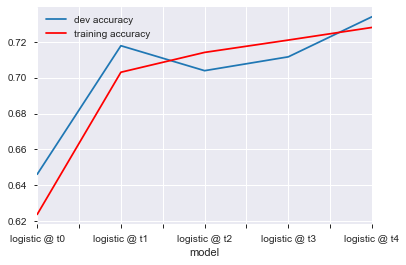

In [124]:
ax = plt.gca()

accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

plt.show()

### Decision Trees

##### Decision Tree @ $t_0$

In [125]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

In [126]:
parameters_dt = {'max_features':list(range(3,23,6)), 'max_depth':list(np.arange(3,9,2))}

dt_mod = DecisionTreeClassifier(random_state = random_state)

In [127]:
t0_dt_accuracy = run_model(model=dt_mod,grid=parameters_dt,label='decision tree @ t0')


the optimal parameters are: {'max_depth': 7, 'max_features': 21}

accuracy on the dev set is: 0.6037564374431991

accuracy on the train set is: 0.6908155320085311

confusion matrix:

[[2322  979]
 [1637 1664]]

classification report:

              precision    recall  f1-score   support

           0       0.59      0.70      0.64      3301
           1       0.63      0.50      0.56      3301

    accuracy                           0.60      6602
   macro avg       0.61      0.60      0.60      6602
weighted avg       0.61      0.60      0.60      6602

0.12107122739156087


In [128]:
accuracy_matrix = pd.DataFrame()
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_dt_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,decision tree @ t0,0.603756,0.690816


##### Decision Tree @ $t_1$

In [129]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

In [130]:
t1_dt_accuracy = run_model(model=dt_mod,grid=parameters_dt,label='decision tree @ t1')


the optimal parameters are: {'max_depth': 7, 'max_features': 9}

accuracy on the dev set is: 0.782258064516129

accuracy on the train set is: 0.80318988865483

confusion matrix:

[[307  65]
 [ 97 275]]

classification report:

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       372
           1       0.81      0.74      0.77       372

    accuracy                           0.78       744
   macro avg       0.78      0.78      0.78       744
weighted avg       0.78      0.78      0.78       744

0.009543804327646892


In [131]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_dt_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,decision tree @ t0,0.603756,0.690816
1,decision tree @ t1,0.782258,0.803190


##### Decision Tree @ $t_2$

In [132]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)

t2_dt_accuracy = run_model(model=dt_mod,grid=parameters_dt,label='decision tree @ t2')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_dt_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_depth': 7, 'max_features': 21}

accuracy on the dev set is: 0.7669322709163346

accuracy on the train set is: 0.812527504767493

confusion matrix:

[[612 141]
 [210 543]]

classification report:

              precision    recall  f1-score   support

           0       0.74      0.81      0.78       753
           1       0.79      0.72      0.76       753

    accuracy                           0.77      1506
   macro avg       0.77      0.77      0.77      1506
weighted avg       0.77      0.77      0.77      1506

0.019930144151051838


,model,dev accuracy,training accuracy
0,decision tree @ t0,0.603756,0.690816
1,decision tree @ t1,0.782258,0.803190
2,decision tree @ t2,0.766932,0.812528


##### Decision Tree @ $t_3$

In [133]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)

t3_dt_accuracy = run_model(model=dt_mod,grid=parameters_dt,label='decision tree @ t3')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_dt_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_depth': 7, 'max_features': 15}

accuracy on the dev set is: 0.7600186393289842

accuracy on the train set is: 0.7977695549388426

confusion matrix:

[[823 250]
 [265 808]]

classification report:

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1073
           1       0.76      0.75      0.76      1073

    accuracy                           0.76      2146
   macro avg       0.76      0.76      0.76      2146
weighted avg       0.76      0.76      0.76      2146

0.02780909538269043


,model,dev accuracy,training accuracy
0,decision tree @ t0,0.603756,0.690816
1,decision tree @ t1,0.782258,0.803190
2,decision tree @ t2,0.766932,0.812528
3,decision tree @ t3,0.760019,0.797770


##### Decision Tree @ $t_4$

In [134]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)

t4_dt_accuracy = run_model(model=dt_mod,grid=parameters_dt,label='decision tree @ t4')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t4_dt_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_depth': 7, 'max_features': 15}

accuracy on the dev set is: 0.7742735648476258

accuracy on the train set is: 0.7892122349996089

confusion matrix:

[[1069  342]
 [ 295 1116]]

classification report:

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1411
           1       0.77      0.79      0.78      1411

    accuracy                           0.77      2822
   macro avg       0.77      0.77      0.77      2822
weighted avg       0.77      0.77      0.77      2822

0.036967921257019046


,model,dev accuracy,training accuracy
0,decision tree @ t0,0.603756,0.690816
1,decision tree @ t1,0.782258,0.803190
2,decision tree @ t2,0.766932,0.812528
3,decision tree @ t3,0.760019,0.797770
4,decision tree @ t4,0.774274,0.789212


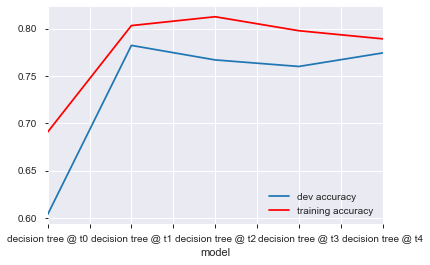

In [135]:
ax = plt.gca()

accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

plt.show()

### Gradient Tree Boosting with gridsearch

##### Gradient Tree @ $t_0$

In [136]:
# X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

# parameters_gtb = {'learning_rate':np.arange(0.00075,1.075,0.1075), 'n_estimators':np.arange(50,650,150),
#               'max_depth':np.arange(3,9,2)}

# gtb_mod = GradientBoostingClassifier(random_state = random_state)

# t0_gtb_accuracy = run_model(model=gtb_mod,grid=parameters_gtb,label='gradient tree boost @ t0')

# accuracy_matrix = pd.DataFrame()
# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_gtb_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

In [137]:
# X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

# t1_gtb_accuracy = run_model(model=gtb_mod,grid=parameters_gtb,label='gradient tree boost @ t1')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_gtb_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

In [138]:
# X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)

# t2_gtb_accuracy = run_model(model=gtb_mod,grid=parameters_gtb,label='gradient tree boost @ t2')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_gtb_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

In [139]:
# X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)

# t3_gtb_accuracy = run_model(model=gtb_mod,grid=parameters_gtb,label='gradient tree boost @ t3')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_gtb_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

In [140]:
# X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)

# t4_gtb_accuracy = run_model(model=gtb_mod,grid=parameters_gtb,label='gradient tree boost @ t4')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t4_gtb_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

### Random Forest 

##### Random Forest @ $t_0$

In [141]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

parameters_rf = {'n_estimators':list(range(100,600,200)),'max_features':list(range(3,23,6))}
rf = RandomForestClassifier(random_state = random_state)

t0_rf_accuracy = run_model(model=rf,grid=parameters_rf,label='random forest @ t0')

accuracy_matrix = pd.DataFrame()
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_features': 21, 'n_estimators': 100}

accuracy on the dev set is: 0.5669494092699182

accuracy on the train set is: 0.9742543755712787

confusion matrix:

[[2861  440]
 [2419  882]]

classification report:

              precision    recall  f1-score   support

           0       0.54      0.87      0.67      3301
           1       0.67      0.27      0.38      3301

    accuracy                           0.57      6602
   macro avg       0.60      0.57      0.52      6602
weighted avg       0.60      0.57      0.52      6602

8.929438682397207


,model,dev accuracy,training accuracy
0,random forest @ t0,0.566949,0.974254


##### Random Forest @ $t_1$

In [142]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

t1_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t1')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_features': 3, 'n_estimators': 500}

accuracy on the dev set is: 0.853494623655914

accuracy on the train set is: 1.0

confusion matrix:

[[356  16]
 [ 93 279]]

classification report:

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       372
           1       0.95      0.75      0.84       372

    accuracy                           0.85       744
   macro avg       0.87      0.85      0.85       744
weighted avg       0.87      0.85      0.85       744

1.1633574406305949


,model,dev accuracy,training accuracy
0,random forest @ t0,0.566949,0.974254
1,random forest @ t1,0.853495,1.000000


##### Random Forest @ $t_2$

In [143]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)

t2_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t2')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_features': 3, 'n_estimators': 500}

accuracy on the dev set is: 0.850597609561753

accuracy on the train set is: 1.0

confusion matrix:

[[723  30]
 [195 558]]

classification report:

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       753
           1       0.95      0.74      0.83       753

    accuracy                           0.85      1506
   macro avg       0.87      0.85      0.85      1506
weighted avg       0.87      0.85      0.85      1506

2.5740038951238


,model,dev accuracy,training accuracy
0,random forest @ t0,0.566949,0.974254
1,random forest @ t1,0.853495,1.000000
2,random forest @ t2,0.850598,1.000000


##### Random Forest @ $t_3$

In [144]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)

t3_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t3')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_features': 3, 'n_estimators': 500}

accuracy on the dev set is: 0.8308480894687791

accuracy on the train set is: 1.0

confusion matrix:

[[1026   47]
 [ 316  757]]

classification report:

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1073
           1       0.94      0.71      0.81      1073

    accuracy                           0.83      2146
   macro avg       0.85      0.83      0.83      2146
weighted avg       0.85      0.83      0.83      2146

3.962565012772878


,model,dev accuracy,training accuracy
0,random forest @ t0,0.566949,0.974254
1,random forest @ t1,0.853495,1.000000
2,random forest @ t2,0.850598,1.000000
3,random forest @ t3,0.830848,1.000000


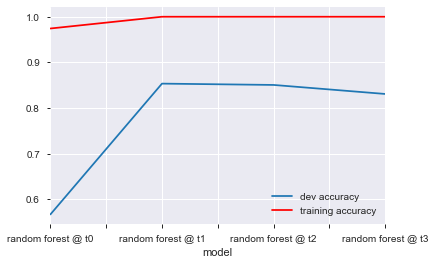

In [145]:
ax = plt.gca()

accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

plt.show()

### XGBoost

##### XGBoost @ $t_0$

In [146]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_dev, label=y_dev)

param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]


num_round = 10000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.666023	train-auc:0.643075
[1]	eval-auc:0.687268	train-auc:0.671555
[2]	eval-auc:0.687113	train-auc:0.68017
[3]	eval-auc:0.687675	train-auc:0.690274
[4]	eval-auc:0.691609	train-auc:0.692857
[5]	eval-auc:0.686289	train-auc:0.695409
[6]	eval-auc:0.68526	train-auc:0.698175
[7]	eval-auc:0.685814	train-auc:0.702132
[8]	eval-auc:0.683559	train-auc:0.7044
[9]	eval-auc:0.688233	train-auc:0.706024
[10]	eval-auc:0.682302	train-auc:0.709578
[11]	eval-auc:0.670612	train-auc:0.711363
[12]	eval-auc:0.671714	train-auc:0.712299
[13]	eval-auc:0.669666	train-auc:0.715014
[14]	eval-auc:0.670032	train-auc:0.714294
[15]	eval-auc:0.668602	train-auc:0.71638
[16]	eval-auc:0.662067	train-auc:0.719054
[17]	eval-auc:0.662963	train-auc:0.722525
[18]	eval-auc:0.66289	train-auc:0.724197
[19]	eval-auc:0.663389	train-auc:0.724964
[20]	eval-auc:0.660128	train-auc:0.727069
[21]	eval-auc:0.661766	train-auc:0.728931
[22]	eval-auc:0.654956	train-auc:0.731255
[23]	eval-auc:0.654004	train-auc:0.73154
[24]	eval

[195]	eval-auc:0.643279	train-auc:0.830105
[196]	eval-auc:0.644682	train-auc:0.830397
[197]	eval-auc:0.64455	train-auc:0.830916
[198]	eval-auc:0.647209	train-auc:0.830645
[199]	eval-auc:0.64629	train-auc:0.831072
[200]	eval-auc:0.646946	train-auc:0.830874
[201]	eval-auc:0.646639	train-auc:0.831171
[202]	eval-auc:0.64695	train-auc:0.831559
[203]	eval-auc:0.647096	train-auc:0.831989
[204]	eval-auc:0.643796	train-auc:0.832496
[205]	eval-auc:0.643826	train-auc:0.832752
[206]	eval-auc:0.643148	train-auc:0.833001
[207]	eval-auc:0.64399	train-auc:0.832822
[208]	eval-auc:0.643656	train-auc:0.833448
[209]	eval-auc:0.644799	train-auc:0.833413
[210]	eval-auc:0.645165	train-auc:0.83407
[211]	eval-auc:0.645984	train-auc:0.834313
[212]	eval-auc:0.644436	train-auc:0.834905
[213]	eval-auc:0.643687	train-auc:0.835253
[214]	eval-auc:0.644291	train-auc:0.835411
[215]	eval-auc:0.642402	train-auc:0.835363
[216]	eval-auc:0.641107	train-auc:0.835541
[217]	eval-auc:0.643023	train-auc:0.835863
[218]	eval-auc:0

[387]	eval-auc:0.644726	train-auc:0.860619
[388]	eval-auc:0.645183	train-auc:0.860713
[389]	eval-auc:0.644817	train-auc:0.860744
[390]	eval-auc:0.646872	train-auc:0.860963
[391]	eval-auc:0.645271	train-auc:0.861169
[392]	eval-auc:0.646987	train-auc:0.860888
[393]	eval-auc:0.646784	train-auc:0.861274
[394]	eval-auc:0.646865	train-auc:0.861531
[395]	eval-auc:0.647176	train-auc:0.861415
[396]	eval-auc:0.646745	train-auc:0.86154
[397]	eval-auc:0.646939	train-auc:0.861635
[398]	eval-auc:0.64806	train-auc:0.861607
[399]	eval-auc:0.645725	train-auc:0.861975
[400]	eval-auc:0.6484	train-auc:0.861889
[401]	eval-auc:0.648153	train-auc:0.862124
[402]	eval-auc:0.648279	train-auc:0.862133
[403]	eval-auc:0.647812	train-auc:0.862324
[404]	eval-auc:0.647603	train-auc:0.862758
[405]	eval-auc:0.647243	train-auc:0.862855
[406]	eval-auc:0.648414	train-auc:0.862992
[407]	eval-auc:0.648372	train-auc:0.862991
[408]	eval-auc:0.647301	train-auc:0.863118
[409]	eval-auc:0.646876	train-auc:0.863625
[410]	eval-auc:

[579]	eval-auc:0.642574	train-auc:0.880257
[580]	eval-auc:0.642444	train-auc:0.880535
[581]	eval-auc:0.642795	train-auc:0.88052
[582]	eval-auc:0.644003	train-auc:0.880536
[583]	eval-auc:0.644182	train-auc:0.880564
[584]	eval-auc:0.645084	train-auc:0.880616
[585]	eval-auc:0.644641	train-auc:0.880669
[586]	eval-auc:0.642723	train-auc:0.880934
[587]	eval-auc:0.643541	train-auc:0.88053
[588]	eval-auc:0.642616	train-auc:0.880863
[589]	eval-auc:0.642884	train-auc:0.880723
[590]	eval-auc:0.644174	train-auc:0.880873
[591]	eval-auc:0.643532	train-auc:0.881062
[592]	eval-auc:0.64339	train-auc:0.881099
[593]	eval-auc:0.644026	train-auc:0.881192
[594]	eval-auc:0.644259	train-auc:0.881234
[595]	eval-auc:0.644531	train-auc:0.881315
[596]	eval-auc:0.644051	train-auc:0.88128
[597]	eval-auc:0.645566	train-auc:0.881512
[598]	eval-auc:0.645272	train-auc:0.881465
[599]	eval-auc:0.644211	train-auc:0.881594
[600]	eval-auc:0.643588	train-auc:0.881505
[601]	eval-auc:0.642973	train-auc:0.88169
[602]	eval-auc:0

[771]	eval-auc:0.643028	train-auc:0.890569
[772]	eval-auc:0.642906	train-auc:0.890546
[773]	eval-auc:0.642748	train-auc:0.890613
[774]	eval-auc:0.642465	train-auc:0.890441
[775]	eval-auc:0.641091	train-auc:0.890798
[776]	eval-auc:0.641126	train-auc:0.890627
[777]	eval-auc:0.640768	train-auc:0.89079
[778]	eval-auc:0.639335	train-auc:0.890902
[779]	eval-auc:0.641276	train-auc:0.89087
[780]	eval-auc:0.639937	train-auc:0.891026
[781]	eval-auc:0.638199	train-auc:0.891004
[782]	eval-auc:0.637143	train-auc:0.890868
[783]	eval-auc:0.63712	train-auc:0.890891
[784]	eval-auc:0.637111	train-auc:0.890907
[785]	eval-auc:0.637057	train-auc:0.890919
[786]	eval-auc:0.636984	train-auc:0.890896
[787]	eval-auc:0.634211	train-auc:0.891019
[788]	eval-auc:0.634759	train-auc:0.891044
[789]	eval-auc:0.63392	train-auc:0.89109
[790]	eval-auc:0.634409	train-auc:0.891223
[791]	eval-auc:0.633635	train-auc:0.891196
[792]	eval-auc:0.633689	train-auc:0.891303
[793]	eval-auc:0.632839	train-auc:0.891435
[794]	eval-auc:0

[963]	eval-auc:0.638565	train-auc:0.897567
[964]	eval-auc:0.638733	train-auc:0.897618
[965]	eval-auc:0.639573	train-auc:0.897693
[966]	eval-auc:0.638503	train-auc:0.897636
[967]	eval-auc:0.63942	train-auc:0.897803
[968]	eval-auc:0.639245	train-auc:0.897854
[969]	eval-auc:0.637568	train-auc:0.897939
[970]	eval-auc:0.638517	train-auc:0.898006
[971]	eval-auc:0.639639	train-auc:0.898067
[972]	eval-auc:0.640632	train-auc:0.898193
[973]	eval-auc:0.640026	train-auc:0.898237
[974]	eval-auc:0.638756	train-auc:0.898377
[975]	eval-auc:0.639794	train-auc:0.898545
[976]	eval-auc:0.639923	train-auc:0.898401
[977]	eval-auc:0.639969	train-auc:0.898355
[978]	eval-auc:0.639443	train-auc:0.898459
[979]	eval-auc:0.640551	train-auc:0.898396
[980]	eval-auc:0.641204	train-auc:0.898337
[981]	eval-auc:0.639766	train-auc:0.898397
[982]	eval-auc:0.640542	train-auc:0.898462
[983]	eval-auc:0.639588	train-auc:0.898741
[984]	eval-auc:0.640906	train-auc:0.89865
[985]	eval-auc:0.640463	train-auc:0.898632
[986]	eval-au

[1152]	eval-auc:0.636811	train-auc:0.904714
[1153]	eval-auc:0.635877	train-auc:0.905045
[1154]	eval-auc:0.636939	train-auc:0.904956
[1155]	eval-auc:0.637522	train-auc:0.904945
[1156]	eval-auc:0.639016	train-auc:0.905062
[1157]	eval-auc:0.638297	train-auc:0.9051
[1158]	eval-auc:0.638711	train-auc:0.905109
[1159]	eval-auc:0.637643	train-auc:0.905062
[1160]	eval-auc:0.63806	train-auc:0.905122
[1161]	eval-auc:0.638912	train-auc:0.90537
[1162]	eval-auc:0.637834	train-auc:0.90553
[1163]	eval-auc:0.63775	train-auc:0.905579
[1164]	eval-auc:0.637254	train-auc:0.905527
[1165]	eval-auc:0.639239	train-auc:0.905736
[1166]	eval-auc:0.638985	train-auc:0.905707
[1167]	eval-auc:0.638898	train-auc:0.905619
[1168]	eval-auc:0.638914	train-auc:0.905752
[1169]	eval-auc:0.639683	train-auc:0.90577
[1170]	eval-auc:0.640166	train-auc:0.905756
[1171]	eval-auc:0.640519	train-auc:0.905774
[1172]	eval-auc:0.64013	train-auc:0.906022
[1173]	eval-auc:0.641152	train-auc:0.905964
[1174]	eval-auc:0.640702	train-auc:0.905

[1340]	eval-auc:0.640373	train-auc:0.91076
[1341]	eval-auc:0.640709	train-auc:0.910821
[1342]	eval-auc:0.640834	train-auc:0.910845
[1343]	eval-auc:0.640158	train-auc:0.910901
[1344]	eval-auc:0.640448	train-auc:0.910851
[1345]	eval-auc:0.64061	train-auc:0.910861
[1346]	eval-auc:0.640271	train-auc:0.910955
[1347]	eval-auc:0.639812	train-auc:0.910952
[1348]	eval-auc:0.640022	train-auc:0.910957
[1349]	eval-auc:0.639232	train-auc:0.911062
[1350]	eval-auc:0.639407	train-auc:0.911056
[1351]	eval-auc:0.640652	train-auc:0.910994
[1352]	eval-auc:0.641984	train-auc:0.910821
[1353]	eval-auc:0.640538	train-auc:0.911122
[1354]	eval-auc:0.639141	train-auc:0.911214
[1355]	eval-auc:0.639785	train-auc:0.911159
[1356]	eval-auc:0.638981	train-auc:0.911164
[1357]	eval-auc:0.638827	train-auc:0.911176
[1358]	eval-auc:0.63895	train-auc:0.911242
[1359]	eval-auc:0.638917	train-auc:0.911198
[1360]	eval-auc:0.638177	train-auc:0.911239
[1361]	eval-auc:0.638592	train-auc:0.91119
[1362]	eval-auc:0.638087	train-auc:0

[1527]	eval-auc:0.637284	train-auc:0.915456
[1528]	eval-auc:0.637448	train-auc:0.915438
[1529]	eval-auc:0.636912	train-auc:0.915446
[1530]	eval-auc:0.636921	train-auc:0.915446
[1531]	eval-auc:0.637037	train-auc:0.915409
[1532]	eval-auc:0.63648	train-auc:0.915319
[1533]	eval-auc:0.636423	train-auc:0.915271
[1534]	eval-auc:0.63711	train-auc:0.915366
[1535]	eval-auc:0.636961	train-auc:0.915573
[1536]	eval-auc:0.636774	train-auc:0.915613
[1537]	eval-auc:0.637322	train-auc:0.915545
[1538]	eval-auc:0.636534	train-auc:0.915521
[1539]	eval-auc:0.636055	train-auc:0.915613
[1540]	eval-auc:0.636208	train-auc:0.915632
[1541]	eval-auc:0.636195	train-auc:0.915635
[1542]	eval-auc:0.63611	train-auc:0.91563
[1543]	eval-auc:0.635965	train-auc:0.91561
[1544]	eval-auc:0.636002	train-auc:0.915632
[1545]	eval-auc:0.635977	train-auc:0.915633
[1546]	eval-auc:0.636184	train-auc:0.915637
[1547]	eval-auc:0.636508	train-auc:0.915679
[1548]	eval-auc:0.636111	train-auc:0.915684
[1549]	eval-auc:0.636376	train-auc:0.

[1715]	eval-auc:0.63259	train-auc:0.919535
[1716]	eval-auc:0.633755	train-auc:0.919622
[1717]	eval-auc:0.633945	train-auc:0.919726
[1718]	eval-auc:0.63405	train-auc:0.919758
[1719]	eval-auc:0.633793	train-auc:0.919847
[1720]	eval-auc:0.63465	train-auc:0.919813
[1721]	eval-auc:0.634887	train-auc:0.919809
[1722]	eval-auc:0.634511	train-auc:0.919933
[1723]	eval-auc:0.635424	train-auc:0.919879
[1724]	eval-auc:0.635566	train-auc:0.919948
[1725]	eval-auc:0.635876	train-auc:0.919873
[1726]	eval-auc:0.634807	train-auc:0.920021
[1727]	eval-auc:0.634365	train-auc:0.919994
[1728]	eval-auc:0.633522	train-auc:0.919788
[1729]	eval-auc:0.634298	train-auc:0.919803
[1730]	eval-auc:0.632866	train-auc:0.919912
[1731]	eval-auc:0.633927	train-auc:0.919917
[1732]	eval-auc:0.633515	train-auc:0.920008
[1733]	eval-auc:0.634443	train-auc:0.920002
[1734]	eval-auc:0.634432	train-auc:0.920055
[1735]	eval-auc:0.634405	train-auc:0.920071
[1736]	eval-auc:0.634015	train-auc:0.920099
[1737]	eval-auc:0.634548	train-auc:

[1902]	eval-auc:0.628772	train-auc:0.923505
[1903]	eval-auc:0.628382	train-auc:0.923527
[1904]	eval-auc:0.628342	train-auc:0.923528
[1905]	eval-auc:0.627878	train-auc:0.923525
[1906]	eval-auc:0.62785	train-auc:0.923489
[1907]	eval-auc:0.628206	train-auc:0.923568
[1908]	eval-auc:0.628459	train-auc:0.923713
[1909]	eval-auc:0.628145	train-auc:0.923683
[1910]	eval-auc:0.628557	train-auc:0.923609
[1911]	eval-auc:0.629328	train-auc:0.923634
[1912]	eval-auc:0.6298	train-auc:0.923639
[1913]	eval-auc:0.630387	train-auc:0.923799
[1914]	eval-auc:0.630353	train-auc:0.923798
[1915]	eval-auc:0.630411	train-auc:0.923767
[1916]	eval-auc:0.630575	train-auc:0.923801
[1917]	eval-auc:0.63073	train-auc:0.923788
[1918]	eval-auc:0.630327	train-auc:0.923793
[1919]	eval-auc:0.630813	train-auc:0.923743
[1920]	eval-auc:0.629914	train-auc:0.923731
[1921]	eval-auc:0.629512	train-auc:0.923746
[1922]	eval-auc:0.630037	train-auc:0.923613
[1923]	eval-auc:0.630233	train-auc:0.923758
[1924]	eval-auc:0.629877	train-auc:0

[2090]	eval-auc:0.625947	train-auc:0.926575
[2091]	eval-auc:0.626408	train-auc:0.926598
[2092]	eval-auc:0.626282	train-auc:0.926729
[2093]	eval-auc:0.626341	train-auc:0.92679
[2094]	eval-auc:0.626368	train-auc:0.926755
[2095]	eval-auc:0.625848	train-auc:0.926804
[2096]	eval-auc:0.625986	train-auc:0.92679
[2097]	eval-auc:0.62539	train-auc:0.926797
[2098]	eval-auc:0.624434	train-auc:0.926802
[2099]	eval-auc:0.625463	train-auc:0.926767
[2100]	eval-auc:0.625405	train-auc:0.92684
[2101]	eval-auc:0.624834	train-auc:0.92684
[2102]	eval-auc:0.625626	train-auc:0.926797
[2103]	eval-auc:0.625448	train-auc:0.926852
[2104]	eval-auc:0.624745	train-auc:0.926887
[2105]	eval-auc:0.625481	train-auc:0.926867
[2106]	eval-auc:0.623451	train-auc:0.926972
[2107]	eval-auc:0.623787	train-auc:0.926949
[2108]	eval-auc:0.623528	train-auc:0.926908
[2109]	eval-auc:0.623654	train-auc:0.926933
[2110]	eval-auc:0.623956	train-auc:0.926932
[2111]	eval-auc:0.624086	train-auc:0.926941
[2112]	eval-auc:0.62387	train-auc:0.9

[2278]	eval-auc:0.622223	train-auc:0.929804
[2279]	eval-auc:0.621496	train-auc:0.929728
[2280]	eval-auc:0.620421	train-auc:0.929801
[2281]	eval-auc:0.620774	train-auc:0.929709
[2282]	eval-auc:0.619912	train-auc:0.92989
[2283]	eval-auc:0.621029	train-auc:0.929753
[2284]	eval-auc:0.621114	train-auc:0.929816
[2285]	eval-auc:0.620926	train-auc:0.929826
[2286]	eval-auc:0.619157	train-auc:0.92985
[2287]	eval-auc:0.619608	train-auc:0.929769
[2288]	eval-auc:0.619974	train-auc:0.929877
[2289]	eval-auc:0.620066	train-auc:0.929896
[2290]	eval-auc:0.618728	train-auc:0.930026
[2291]	eval-auc:0.618604	train-auc:0.930093
[2292]	eval-auc:0.618785	train-auc:0.930145
[2293]	eval-auc:0.618682	train-auc:0.930081
[2294]	eval-auc:0.619118	train-auc:0.930158
[2295]	eval-auc:0.618702	train-auc:0.930132
[2296]	eval-auc:0.619493	train-auc:0.930185
[2297]	eval-auc:0.619704	train-auc:0.930197
[2298]	eval-auc:0.621008	train-auc:0.930282
[2299]	eval-auc:0.620602	train-auc:0.930419
[2300]	eval-auc:0.617602	train-auc

[2466]	eval-auc:0.613032	train-auc:0.932636
[2467]	eval-auc:0.612799	train-auc:0.932666
[2468]	eval-auc:0.612722	train-auc:0.932665
[2469]	eval-auc:0.612026	train-auc:0.932658
[2470]	eval-auc:0.611712	train-auc:0.93263
[2471]	eval-auc:0.61175	train-auc:0.932659
[2472]	eval-auc:0.611631	train-auc:0.932612
[2473]	eval-auc:0.61187	train-auc:0.932648
[2474]	eval-auc:0.611756	train-auc:0.932665
[2475]	eval-auc:0.61122	train-auc:0.932675
[2476]	eval-auc:0.612247	train-auc:0.932617
[2477]	eval-auc:0.611288	train-auc:0.932778
[2478]	eval-auc:0.611767	train-auc:0.93279
[2479]	eval-auc:0.611896	train-auc:0.932795
[2480]	eval-auc:0.612082	train-auc:0.93275
[2481]	eval-auc:0.612344	train-auc:0.932826
[2482]	eval-auc:0.612077	train-auc:0.932913
[2483]	eval-auc:0.61227	train-auc:0.932911
[2484]	eval-auc:0.612303	train-auc:0.933064
[2485]	eval-auc:0.61279	train-auc:0.933082
[2486]	eval-auc:0.613491	train-auc:0.933019
[2487]	eval-auc:0.613992	train-auc:0.933107
[2488]	eval-auc:0.61394	train-auc:0.9330

[2654]	eval-auc:0.618372	train-auc:0.935188
[2655]	eval-auc:0.618408	train-auc:0.935185
[2656]	eval-auc:0.618411	train-auc:0.935253
[2657]	eval-auc:0.618103	train-auc:0.935192
[2658]	eval-auc:0.618505	train-auc:0.935179
[2659]	eval-auc:0.618569	train-auc:0.935181
[2660]	eval-auc:0.618459	train-auc:0.935184
[2661]	eval-auc:0.618216	train-auc:0.935183
[2662]	eval-auc:0.618602	train-auc:0.935161
[2663]	eval-auc:0.617905	train-auc:0.935165
[2664]	eval-auc:0.618366	train-auc:0.935038
[2665]	eval-auc:0.618128	train-auc:0.935109
[2666]	eval-auc:0.618305	train-auc:0.935219
[2667]	eval-auc:0.618161	train-auc:0.935143
[2668]	eval-auc:0.618328	train-auc:0.935228
[2669]	eval-auc:0.618553	train-auc:0.93521
[2670]	eval-auc:0.617222	train-auc:0.935279
[2671]	eval-auc:0.6174	train-auc:0.935241
[2672]	eval-auc:0.616757	train-auc:0.935327
[2673]	eval-auc:0.616417	train-auc:0.935309
[2674]	eval-auc:0.616266	train-auc:0.935321
[2675]	eval-auc:0.616295	train-auc:0.935309
[2676]	eval-auc:0.615514	train-auc:

[2841]	eval-auc:0.615613	train-auc:0.937288
[2842]	eval-auc:0.615643	train-auc:0.93725
[2843]	eval-auc:0.615603	train-auc:0.937242
[2844]	eval-auc:0.615698	train-auc:0.937248
[2845]	eval-auc:0.614648	train-auc:0.937258
[2846]	eval-auc:0.614737	train-auc:0.937261
[2847]	eval-auc:0.614927	train-auc:0.937318
[2848]	eval-auc:0.614981	train-auc:0.937325
[2849]	eval-auc:0.614902	train-auc:0.937316
[2850]	eval-auc:0.614543	train-auc:0.937364
[2851]	eval-auc:0.614731	train-auc:0.937262
[2852]	eval-auc:0.614522	train-auc:0.937367
[2853]	eval-auc:0.614244	train-auc:0.937393
[2854]	eval-auc:0.613825	train-auc:0.937417
[2855]	eval-auc:0.614198	train-auc:0.937397
[2856]	eval-auc:0.613729	train-auc:0.937406
[2857]	eval-auc:0.614594	train-auc:0.937425
[2858]	eval-auc:0.614616	train-auc:0.937504
[2859]	eval-auc:0.614654	train-auc:0.937465
[2860]	eval-auc:0.615363	train-auc:0.937475
[2861]	eval-auc:0.61546	train-auc:0.937532
[2862]	eval-auc:0.615203	train-auc:0.937509
[2863]	eval-auc:0.616094	train-auc

[3028]	eval-auc:0.608618	train-auc:0.939285
[3029]	eval-auc:0.608327	train-auc:0.939295
[3030]	eval-auc:0.607732	train-auc:0.939412
[3031]	eval-auc:0.608018	train-auc:0.939322
[3032]	eval-auc:0.607816	train-auc:0.939354
[3033]	eval-auc:0.608484	train-auc:0.939366
[3034]	eval-auc:0.608235	train-auc:0.939365
[3035]	eval-auc:0.608189	train-auc:0.939375
[3036]	eval-auc:0.608217	train-auc:0.939414
[3037]	eval-auc:0.608086	train-auc:0.9394
[3038]	eval-auc:0.608317	train-auc:0.939409
[3039]	eval-auc:0.607729	train-auc:0.939497
[3040]	eval-auc:0.607955	train-auc:0.939474
[3041]	eval-auc:0.608055	train-auc:0.939484
[3042]	eval-auc:0.607524	train-auc:0.939484
[3043]	eval-auc:0.607044	train-auc:0.9395
[3044]	eval-auc:0.606925	train-auc:0.939499
[3045]	eval-auc:0.607332	train-auc:0.9395
[3046]	eval-auc:0.607433	train-auc:0.939593
[3047]	eval-auc:0.607983	train-auc:0.939546
[3048]	eval-auc:0.608119	train-auc:0.939422
[3049]	eval-auc:0.608453	train-auc:0.939488
[3050]	eval-auc:0.608353	train-auc:0.9

[3216]	eval-auc:0.607709	train-auc:0.941187
[3217]	eval-auc:0.608346	train-auc:0.941181
[3218]	eval-auc:0.608194	train-auc:0.941139
[3219]	eval-auc:0.607844	train-auc:0.941147
[3220]	eval-auc:0.606881	train-auc:0.941177
[3221]	eval-auc:0.607203	train-auc:0.941104
[3222]	eval-auc:0.607001	train-auc:0.941126
[3223]	eval-auc:0.606852	train-auc:0.941128
[3224]	eval-auc:0.606719	train-auc:0.941129
[3225]	eval-auc:0.606929	train-auc:0.941141
[3226]	eval-auc:0.606777	train-auc:0.94114
[3227]	eval-auc:0.606818	train-auc:0.941142
[3228]	eval-auc:0.607207	train-auc:0.941144
[3229]	eval-auc:0.607452	train-auc:0.941203
[3230]	eval-auc:0.607658	train-auc:0.941207
[3231]	eval-auc:0.607225	train-auc:0.941245
[3232]	eval-auc:0.60717	train-auc:0.941282
[3233]	eval-auc:0.60607	train-auc:0.941352
[3234]	eval-auc:0.606288	train-auc:0.941313
[3235]	eval-auc:0.605776	train-auc:0.94131
[3236]	eval-auc:0.605212	train-auc:0.941298
[3237]	eval-auc:0.604742	train-auc:0.941292
[3238]	eval-auc:0.604777	train-auc:0

[3404]	eval-auc:0.604896	train-auc:0.943182
[3405]	eval-auc:0.604788	train-auc:0.943169
[3406]	eval-auc:0.603869	train-auc:0.943356
[3407]	eval-auc:0.604709	train-auc:0.943266
[3408]	eval-auc:0.604732	train-auc:0.943277
[3409]	eval-auc:0.604068	train-auc:0.943359
[3410]	eval-auc:0.604419	train-auc:0.943287
[3411]	eval-auc:0.604607	train-auc:0.943223
[3412]	eval-auc:0.604074	train-auc:0.943216
[3413]	eval-auc:0.604011	train-auc:0.943217
[3414]	eval-auc:0.603497	train-auc:0.943183
[3415]	eval-auc:0.603415	train-auc:0.943191
[3416]	eval-auc:0.603618	train-auc:0.943198
[3417]	eval-auc:0.603717	train-auc:0.943188
[3418]	eval-auc:0.604583	train-auc:0.943228
[3419]	eval-auc:0.604132	train-auc:0.943239
[3420]	eval-auc:0.604543	train-auc:0.943201
[3421]	eval-auc:0.60381	train-auc:0.943351
[3422]	eval-auc:0.60414	train-auc:0.94329
[3423]	eval-auc:0.603602	train-auc:0.943286
[3424]	eval-auc:0.603538	train-auc:0.943299
[3425]	eval-auc:0.60326	train-auc:0.943344
[3426]	eval-auc:0.603427	train-auc:0

[3591]	eval-auc:0.602813	train-auc:0.944759
[3592]	eval-auc:0.603047	train-auc:0.944759
[3593]	eval-auc:0.602915	train-auc:0.944755
[3594]	eval-auc:0.604077	train-auc:0.944742
[3595]	eval-auc:0.604545	train-auc:0.944751
[3596]	eval-auc:0.603447	train-auc:0.944763
[3597]	eval-auc:0.603678	train-auc:0.944766
[3598]	eval-auc:0.603686	train-auc:0.944732
[3599]	eval-auc:0.603523	train-auc:0.944745
[3600]	eval-auc:0.603294	train-auc:0.944752
[3601]	eval-auc:0.603659	train-auc:0.944767
[3602]	eval-auc:0.603034	train-auc:0.9448
[3603]	eval-auc:0.603423	train-auc:0.944804
[3604]	eval-auc:0.602907	train-auc:0.944743
[3605]	eval-auc:0.602436	train-auc:0.944736
[3606]	eval-auc:0.602907	train-auc:0.944688
[3607]	eval-auc:0.602635	train-auc:0.944741
[3608]	eval-auc:0.602888	train-auc:0.94474
[3609]	eval-auc:0.602995	train-auc:0.944834
[3610]	eval-auc:0.603697	train-auc:0.944764
[3611]	eval-auc:0.603829	train-auc:0.944741
[3612]	eval-auc:0.603299	train-auc:0.94485
[3613]	eval-auc:0.603308	train-auc:0

[3779]	eval-auc:0.601451	train-auc:0.946475
[3780]	eval-auc:0.601385	train-auc:0.946439
[3781]	eval-auc:0.601048	train-auc:0.946494
[3782]	eval-auc:0.601156	train-auc:0.94655
[3783]	eval-auc:0.600542	train-auc:0.946625
[3784]	eval-auc:0.600748	train-auc:0.946607
[3785]	eval-auc:0.600795	train-auc:0.946608
[3786]	eval-auc:0.600991	train-auc:0.946598
[3787]	eval-auc:0.600348	train-auc:0.946715
[3788]	eval-auc:0.600992	train-auc:0.946627
[3789]	eval-auc:0.60058	train-auc:0.946619
[3790]	eval-auc:0.600995	train-auc:0.94668
[3791]	eval-auc:0.600846	train-auc:0.946654
[3792]	eval-auc:0.60064	train-auc:0.946698
[3793]	eval-auc:0.599945	train-auc:0.946737
[3794]	eval-auc:0.600547	train-auc:0.946596
[3795]	eval-auc:0.600637	train-auc:0.946587
[3796]	eval-auc:0.600612	train-auc:0.946621
[3797]	eval-auc:0.601054	train-auc:0.946635
[3798]	eval-auc:0.60029	train-auc:0.946604
[3799]	eval-auc:0.600681	train-auc:0.94665
[3800]	eval-auc:0.600517	train-auc:0.946659
[3801]	eval-auc:0.60042	train-auc:0.94

[3967]	eval-auc:0.60133	train-auc:0.947698
[3968]	eval-auc:0.601172	train-auc:0.947714
[3969]	eval-auc:0.601093	train-auc:0.947706
[3970]	eval-auc:0.601058	train-auc:0.947706
[3971]	eval-auc:0.601102	train-auc:0.9477
[3972]	eval-auc:0.601374	train-auc:0.947712
[3973]	eval-auc:0.601353	train-auc:0.947712
[3974]	eval-auc:0.60196	train-auc:0.947766
[3975]	eval-auc:0.601576	train-auc:0.947745
[3976]	eval-auc:0.601139	train-auc:0.947779
[3977]	eval-auc:0.601672	train-auc:0.947709
[3978]	eval-auc:0.601072	train-auc:0.947843
[3979]	eval-auc:0.601476	train-auc:0.947779
[3980]	eval-auc:0.601576	train-auc:0.947853
[3981]	eval-auc:0.601534	train-auc:0.947888
[3982]	eval-auc:0.600769	train-auc:0.947897
[3983]	eval-auc:0.601253	train-auc:0.947893
[3984]	eval-auc:0.601234	train-auc:0.947889
[3985]	eval-auc:0.600893	train-auc:0.947937
[3986]	eval-auc:0.601177	train-auc:0.947921
[3987]	eval-auc:0.601289	train-auc:0.947908
[3988]	eval-auc:0.601018	train-auc:0.947907
[3989]	eval-auc:0.601206	train-auc:0

[4154]	eval-auc:0.606691	train-auc:0.94921
[4155]	eval-auc:0.606593	train-auc:0.949265
[4156]	eval-auc:0.606408	train-auc:0.949276
[4157]	eval-auc:0.606033	train-auc:0.949274
[4158]	eval-auc:0.605775	train-auc:0.949276
[4159]	eval-auc:0.605356	train-auc:0.949281
[4160]	eval-auc:0.604999	train-auc:0.949277
[4161]	eval-auc:0.605179	train-auc:0.949283
[4162]	eval-auc:0.604841	train-auc:0.949279
[4163]	eval-auc:0.605056	train-auc:0.949281
[4164]	eval-auc:0.605432	train-auc:0.949317
[4165]	eval-auc:0.605833	train-auc:0.949318
[4166]	eval-auc:0.605892	train-auc:0.949331
[4167]	eval-auc:0.605765	train-auc:0.949322
[4168]	eval-auc:0.606668	train-auc:0.949337
[4169]	eval-auc:0.606627	train-auc:0.949313
[4170]	eval-auc:0.606685	train-auc:0.949342
[4171]	eval-auc:0.605782	train-auc:0.949432
[4172]	eval-auc:0.606049	train-auc:0.949408
[4173]	eval-auc:0.606283	train-auc:0.949425
[4174]	eval-auc:0.606742	train-auc:0.94947
[4175]	eval-auc:0.606113	train-auc:0.949455
[4176]	eval-auc:0.605933	train-auc

[4342]	eval-auc:0.601463	train-auc:0.95048
[4343]	eval-auc:0.602203	train-auc:0.950481
[4344]	eval-auc:0.601965	train-auc:0.950472
[4345]	eval-auc:0.602124	train-auc:0.95045
[4346]	eval-auc:0.602662	train-auc:0.95046
[4347]	eval-auc:0.602782	train-auc:0.950452
[4348]	eval-auc:0.602859	train-auc:0.950446
[4349]	eval-auc:0.602659	train-auc:0.950439
[4350]	eval-auc:0.6021	train-auc:0.950499
[4351]	eval-auc:0.602361	train-auc:0.950475
[4352]	eval-auc:0.602258	train-auc:0.950447
[4353]	eval-auc:0.602519	train-auc:0.950424
[4354]	eval-auc:0.602511	train-auc:0.95047
[4355]	eval-auc:0.60247	train-auc:0.950492
[4356]	eval-auc:0.602186	train-auc:0.950508
[4357]	eval-auc:0.601418	train-auc:0.950513
[4358]	eval-auc:0.601324	train-auc:0.950512
[4359]	eval-auc:0.601832	train-auc:0.950506
[4360]	eval-auc:0.600985	train-auc:0.950487
[4361]	eval-auc:0.601612	train-auc:0.950487
[4362]	eval-auc:0.601329	train-auc:0.950459
[4363]	eval-auc:0.601299	train-auc:0.950499
[4364]	eval-auc:0.601135	train-auc:0.95

[4530]	eval-auc:0.600318	train-auc:0.9515
[4531]	eval-auc:0.600834	train-auc:0.951524
[4532]	eval-auc:0.600653	train-auc:0.951499
[4533]	eval-auc:0.601407	train-auc:0.951515
[4534]	eval-auc:0.601609	train-auc:0.951506
[4535]	eval-auc:0.600836	train-auc:0.951533
[4536]	eval-auc:0.600817	train-auc:0.951523
[4537]	eval-auc:0.600822	train-auc:0.951565
[4538]	eval-auc:0.601042	train-auc:0.95156
[4539]	eval-auc:0.60085	train-auc:0.951592
[4540]	eval-auc:0.600359	train-auc:0.951543
[4541]	eval-auc:0.600579	train-auc:0.95162
[4542]	eval-auc:0.600639	train-auc:0.951536
[4543]	eval-auc:0.599954	train-auc:0.951623
[4544]	eval-auc:0.600468	train-auc:0.951607
[4545]	eval-auc:0.600719	train-auc:0.951577
[4546]	eval-auc:0.600418	train-auc:0.951581
[4547]	eval-auc:0.600551	train-auc:0.951597
[4548]	eval-auc:0.600613	train-auc:0.951589
[4549]	eval-auc:0.60077	train-auc:0.951603
[4550]	eval-auc:0.600987	train-auc:0.951619
[4551]	eval-auc:0.601178	train-auc:0.951591
[4552]	eval-auc:0.601116	train-auc:0.9

[4718]	eval-auc:0.599048	train-auc:0.952551
[4719]	eval-auc:0.59995	train-auc:0.95262
[4720]	eval-auc:0.600008	train-auc:0.952639
[4721]	eval-auc:0.599588	train-auc:0.952647
[4722]	eval-auc:0.599747	train-auc:0.952694
[4723]	eval-auc:0.599869	train-auc:0.952698
[4724]	eval-auc:0.599822	train-auc:0.952704
[4725]	eval-auc:0.599328	train-auc:0.952666
[4726]	eval-auc:0.599479	train-auc:0.952742
[4727]	eval-auc:0.599927	train-auc:0.952685
[4728]	eval-auc:0.600375	train-auc:0.952704
[4729]	eval-auc:0.600594	train-auc:0.952703
[4730]	eval-auc:0.600312	train-auc:0.952728
[4731]	eval-auc:0.599818	train-auc:0.952744
[4732]	eval-auc:0.599818	train-auc:0.952751
[4733]	eval-auc:0.599769	train-auc:0.952731
[4734]	eval-auc:0.600138	train-auc:0.952751
[4735]	eval-auc:0.600237	train-auc:0.952763
[4736]	eval-auc:0.599902	train-auc:0.952819
[4737]	eval-auc:0.600244	train-auc:0.95276
[4738]	eval-auc:0.599921	train-auc:0.95276
[4739]	eval-auc:0.600235	train-auc:0.952772
[4740]	eval-auc:0.600139	train-auc:0

[4906]	eval-auc:0.599574	train-auc:0.953625
[4907]	eval-auc:0.599468	train-auc:0.953675
[4908]	eval-auc:0.599502	train-auc:0.953631
[4909]	eval-auc:0.599993	train-auc:0.953629
[4910]	eval-auc:0.599919	train-auc:0.95363
[4911]	eval-auc:0.599799	train-auc:0.953625
[4912]	eval-auc:0.600036	train-auc:0.953627
[4913]	eval-auc:0.600017	train-auc:0.953634
[4914]	eval-auc:0.600347	train-auc:0.953636
[4915]	eval-auc:0.600383	train-auc:0.95365
[4916]	eval-auc:0.600517	train-auc:0.953662
[4917]	eval-auc:0.600303	train-auc:0.953649
[4918]	eval-auc:0.600266	train-auc:0.953664
[4919]	eval-auc:0.599917	train-auc:0.953602
[4920]	eval-auc:0.599558	train-auc:0.95363
[4921]	eval-auc:0.599661	train-auc:0.953648
[4922]	eval-auc:0.599637	train-auc:0.953669
[4923]	eval-auc:0.599805	train-auc:0.953682
[4924]	eval-auc:0.600029	train-auc:0.95368
[4925]	eval-auc:0.599788	train-auc:0.953676
[4926]	eval-auc:0.599505	train-auc:0.953725
[4927]	eval-auc:0.600102	train-auc:0.953725
[4928]	eval-auc:0.600124	train-auc:0

[5094]	eval-auc:0.599938	train-auc:0.954679
[5095]	eval-auc:0.599587	train-auc:0.954693
[5096]	eval-auc:0.599686	train-auc:0.954732
[5097]	eval-auc:0.600176	train-auc:0.954746
[5098]	eval-auc:0.600341	train-auc:0.954755
[5099]	eval-auc:0.600241	train-auc:0.954748
[5100]	eval-auc:0.600133	train-auc:0.954767
[5101]	eval-auc:0.60021	train-auc:0.95473
[5102]	eval-auc:0.600382	train-auc:0.954719
[5103]	eval-auc:0.600906	train-auc:0.954718
[5104]	eval-auc:0.60083	train-auc:0.95474
[5105]	eval-auc:0.600767	train-auc:0.954759
[5106]	eval-auc:0.600484	train-auc:0.954754
[5107]	eval-auc:0.600765	train-auc:0.954737
[5108]	eval-auc:0.601	train-auc:0.954721
[5109]	eval-auc:0.600578	train-auc:0.95474
[5110]	eval-auc:0.601091	train-auc:0.954713
[5111]	eval-auc:0.600716	train-auc:0.954721
[5112]	eval-auc:0.600936	train-auc:0.954695
[5113]	eval-auc:0.601271	train-auc:0.954684
[5114]	eval-auc:0.601224	train-auc:0.954743
[5115]	eval-auc:0.601105	train-auc:0.954742
[5116]	eval-auc:0.600734	train-auc:0.954

[5281]	eval-auc:0.598969	train-auc:0.95541
[5282]	eval-auc:0.598525	train-auc:0.95542
[5283]	eval-auc:0.598311	train-auc:0.95546
[5284]	eval-auc:0.598182	train-auc:0.95546
[5285]	eval-auc:0.598424	train-auc:0.955462
[5286]	eval-auc:0.598589	train-auc:0.955463
[5287]	eval-auc:0.598626	train-auc:0.955515
[5288]	eval-auc:0.598371	train-auc:0.955498
[5289]	eval-auc:0.598158	train-auc:0.955483
[5290]	eval-auc:0.598033	train-auc:0.955507
[5291]	eval-auc:0.598457	train-auc:0.955511
[5292]	eval-auc:0.598231	train-auc:0.955485
[5293]	eval-auc:0.598292	train-auc:0.955497
[5294]	eval-auc:0.59753	train-auc:0.955566
[5295]	eval-auc:0.59756	train-auc:0.955565
[5296]	eval-auc:0.598537	train-auc:0.9556
[5297]	eval-auc:0.597582	train-auc:0.955592
[5298]	eval-auc:0.597498	train-auc:0.955642
[5299]	eval-auc:0.598061	train-auc:0.955592
[5300]	eval-auc:0.598709	train-auc:0.955617
[5301]	eval-auc:0.598776	train-auc:0.955632
[5302]	eval-auc:0.598711	train-auc:0.955687
[5303]	eval-auc:0.598551	train-auc:0.955

[5469]	eval-auc:0.596098	train-auc:0.95651
[5470]	eval-auc:0.596035	train-auc:0.956525
[5471]	eval-auc:0.596634	train-auc:0.956538
[5472]	eval-auc:0.597032	train-auc:0.956517
[5473]	eval-auc:0.597019	train-auc:0.956516
[5474]	eval-auc:0.596834	train-auc:0.956499
[5475]	eval-auc:0.596579	train-auc:0.956517
[5476]	eval-auc:0.596757	train-auc:0.956498
[5477]	eval-auc:0.596765	train-auc:0.95654
[5478]	eval-auc:0.596981	train-auc:0.956549
[5479]	eval-auc:0.596894	train-auc:0.956552
[5480]	eval-auc:0.597096	train-auc:0.956561
[5481]	eval-auc:0.596918	train-auc:0.956562
[5482]	eval-auc:0.596994	train-auc:0.956532
[5483]	eval-auc:0.597296	train-auc:0.956547
[5484]	eval-auc:0.597165	train-auc:0.956614
[5485]	eval-auc:0.597201	train-auc:0.956642
[5486]	eval-auc:0.597698	train-auc:0.956648
[5487]	eval-auc:0.597279	train-auc:0.956623
[5488]	eval-auc:0.597236	train-auc:0.956648
[5489]	eval-auc:0.5972	train-auc:0.956679
[5490]	eval-auc:0.597424	train-auc:0.956716
[5491]	eval-auc:0.597209	train-auc:0

[5657]	eval-auc:0.596918	train-auc:0.95734
[5658]	eval-auc:0.597004	train-auc:0.957333
[5659]	eval-auc:0.597024	train-auc:0.957343
[5660]	eval-auc:0.596737	train-auc:0.957345
[5661]	eval-auc:0.597458	train-auc:0.957374
[5662]	eval-auc:0.597559	train-auc:0.957343
[5663]	eval-auc:0.597282	train-auc:0.957385
[5664]	eval-auc:0.597499	train-auc:0.9574
[5665]	eval-auc:0.59786	train-auc:0.957387
[5666]	eval-auc:0.597359	train-auc:0.957419
[5667]	eval-auc:0.597011	train-auc:0.957417
[5668]	eval-auc:0.597096	train-auc:0.957364
[5669]	eval-auc:0.597146	train-auc:0.957364
[5670]	eval-auc:0.597309	train-auc:0.957368
[5671]	eval-auc:0.597072	train-auc:0.957355
[5672]	eval-auc:0.597331	train-auc:0.957344
[5673]	eval-auc:0.596792	train-auc:0.957362
[5674]	eval-auc:0.596299	train-auc:0.957382
[5675]	eval-auc:0.595934	train-auc:0.957373
[5676]	eval-auc:0.595654	train-auc:0.957357
[5677]	eval-auc:0.595339	train-auc:0.957372
[5678]	eval-auc:0.595254	train-auc:0.957389
[5679]	eval-auc:0.594547	train-auc:0

[5844]	eval-auc:0.596986	train-auc:0.958152
[5845]	eval-auc:0.596909	train-auc:0.958167
[5846]	eval-auc:0.5971	train-auc:0.958131
[5847]	eval-auc:0.597092	train-auc:0.958119
[5848]	eval-auc:0.597035	train-auc:0.958127
[5849]	eval-auc:0.597366	train-auc:0.958121
[5850]	eval-auc:0.596805	train-auc:0.958171
[5851]	eval-auc:0.597742	train-auc:0.958126
[5852]	eval-auc:0.597285	train-auc:0.958136
[5853]	eval-auc:0.597984	train-auc:0.958121
[5854]	eval-auc:0.597927	train-auc:0.958208
[5855]	eval-auc:0.598359	train-auc:0.958121
[5856]	eval-auc:0.598762	train-auc:0.958244
[5857]	eval-auc:0.598355	train-auc:0.958374
[5858]	eval-auc:0.598733	train-auc:0.958361
[5859]	eval-auc:0.597954	train-auc:0.958305
[5860]	eval-auc:0.597916	train-auc:0.958293
[5861]	eval-auc:0.598213	train-auc:0.958278
[5862]	eval-auc:0.598492	train-auc:0.958293
[5863]	eval-auc:0.598259	train-auc:0.958234
[5864]	eval-auc:0.597678	train-auc:0.958243
[5865]	eval-auc:0.597717	train-auc:0.958252
[5866]	eval-auc:0.598087	train-auc

[6032]	eval-auc:0.597698	train-auc:0.958986
[6033]	eval-auc:0.597714	train-auc:0.95898
[6034]	eval-auc:0.597172	train-auc:0.95903
[6035]	eval-auc:0.597144	train-auc:0.959029
[6036]	eval-auc:0.596993	train-auc:0.959016
[6037]	eval-auc:0.597122	train-auc:0.958965
[6038]	eval-auc:0.596992	train-auc:0.958971
[6039]	eval-auc:0.597281	train-auc:0.958983
[6040]	eval-auc:0.597356	train-auc:0.958985
[6041]	eval-auc:0.597817	train-auc:0.959011
[6042]	eval-auc:0.59744	train-auc:0.958995
[6043]	eval-auc:0.597356	train-auc:0.959033
[6044]	eval-auc:0.597571	train-auc:0.958989
[6045]	eval-auc:0.596689	train-auc:0.959008
[6046]	eval-auc:0.596728	train-auc:0.958991
[6047]	eval-auc:0.596963	train-auc:0.958969
[6048]	eval-auc:0.596611	train-auc:0.959002
[6049]	eval-auc:0.596702	train-auc:0.95903
[6050]	eval-auc:0.597356	train-auc:0.959007
[6051]	eval-auc:0.597349	train-auc:0.95901
[6052]	eval-auc:0.597566	train-auc:0.959013
[6053]	eval-auc:0.597695	train-auc:0.959021
[6054]	eval-auc:0.597884	train-auc:0.

[6220]	eval-auc:0.597156	train-auc:0.959595
[6221]	eval-auc:0.596796	train-auc:0.959546
[6222]	eval-auc:0.596776	train-auc:0.95957
[6223]	eval-auc:0.596923	train-auc:0.959583
[6224]	eval-auc:0.596704	train-auc:0.959577
[6225]	eval-auc:0.596793	train-auc:0.959513
[6226]	eval-auc:0.596826	train-auc:0.959514
[6227]	eval-auc:0.597073	train-auc:0.959536
[6228]	eval-auc:0.597021	train-auc:0.959542
[6229]	eval-auc:0.597155	train-auc:0.959486
[6230]	eval-auc:0.596783	train-auc:0.959563
[6231]	eval-auc:0.596841	train-auc:0.959616
[6232]	eval-auc:0.597095	train-auc:0.959559
[6233]	eval-auc:0.598076	train-auc:0.959488
[6234]	eval-auc:0.598284	train-auc:0.959586
[6235]	eval-auc:0.598262	train-auc:0.959607
[6236]	eval-auc:0.598263	train-auc:0.959621
[6237]	eval-auc:0.598017	train-auc:0.959644
[6238]	eval-auc:0.597798	train-auc:0.959653
[6239]	eval-auc:0.597839	train-auc:0.959643
[6240]	eval-auc:0.597879	train-auc:0.95966
[6241]	eval-auc:0.597662	train-auc:0.959692
[6242]	eval-auc:0.597574	train-auc

[6407]	eval-auc:0.59781	train-auc:0.960275
[6408]	eval-auc:0.597394	train-auc:0.9603
[6409]	eval-auc:0.597342	train-auc:0.960358
[6410]	eval-auc:0.596566	train-auc:0.960382
[6411]	eval-auc:0.597199	train-auc:0.960396
[6412]	eval-auc:0.59686	train-auc:0.9604
[6413]	eval-auc:0.596467	train-auc:0.960391
[6414]	eval-auc:0.596506	train-auc:0.960388
[6415]	eval-auc:0.596948	train-auc:0.960389
[6416]	eval-auc:0.596632	train-auc:0.960392
[6417]	eval-auc:0.596946	train-auc:0.960366
[6418]	eval-auc:0.596675	train-auc:0.960355
[6419]	eval-auc:0.596783	train-auc:0.960373
[6420]	eval-auc:0.596729	train-auc:0.960356
[6421]	eval-auc:0.596617	train-auc:0.960388
[6422]	eval-auc:0.596413	train-auc:0.960339
[6423]	eval-auc:0.596438	train-auc:0.960365
[6424]	eval-auc:0.596729	train-auc:0.960392
[6425]	eval-auc:0.596783	train-auc:0.960338
[6426]	eval-auc:0.596804	train-auc:0.960385
[6427]	eval-auc:0.59693	train-auc:0.960395
[6428]	eval-auc:0.596659	train-auc:0.960395
[6429]	eval-auc:0.596537	train-auc:0.96

[6595]	eval-auc:0.597147	train-auc:0.96097
[6596]	eval-auc:0.596738	train-auc:0.960988
[6597]	eval-auc:0.596374	train-auc:0.961057
[6598]	eval-auc:0.596998	train-auc:0.960997
[6599]	eval-auc:0.597454	train-auc:0.960999
[6600]	eval-auc:0.597461	train-auc:0.960948
[6601]	eval-auc:0.597372	train-auc:0.960985
[6602]	eval-auc:0.597583	train-auc:0.960973
[6603]	eval-auc:0.597148	train-auc:0.960998
[6604]	eval-auc:0.597133	train-auc:0.961002
[6605]	eval-auc:0.597208	train-auc:0.961066
[6606]	eval-auc:0.597162	train-auc:0.961038
[6607]	eval-auc:0.59733	train-auc:0.96104
[6608]	eval-auc:0.597407	train-auc:0.961047
[6609]	eval-auc:0.597453	train-auc:0.961064
[6610]	eval-auc:0.597587	train-auc:0.961044
[6611]	eval-auc:0.597515	train-auc:0.96105
[6612]	eval-auc:0.597399	train-auc:0.961036
[6613]	eval-auc:0.597205	train-auc:0.961029
[6614]	eval-auc:0.597153	train-auc:0.961027
[6615]	eval-auc:0.597144	train-auc:0.961048
[6616]	eval-auc:0.596809	train-auc:0.961087
[6617]	eval-auc:0.597311	train-auc:0

[6783]	eval-auc:0.597028	train-auc:0.961632
[6784]	eval-auc:0.596474	train-auc:0.961626
[6785]	eval-auc:0.596748	train-auc:0.961642
[6786]	eval-auc:0.596229	train-auc:0.961652
[6787]	eval-auc:0.596294	train-auc:0.961638
[6788]	eval-auc:0.595785	train-auc:0.961731
[6789]	eval-auc:0.596489	train-auc:0.96167
[6790]	eval-auc:0.596571	train-auc:0.961675
[6791]	eval-auc:0.596682	train-auc:0.961668
[6792]	eval-auc:0.596799	train-auc:0.961691
[6793]	eval-auc:0.596481	train-auc:0.961686
[6794]	eval-auc:0.596597	train-auc:0.96173
[6795]	eval-auc:0.596379	train-auc:0.961715
[6796]	eval-auc:0.596406	train-auc:0.96174
[6797]	eval-auc:0.59701	train-auc:0.961772
[6798]	eval-auc:0.597001	train-auc:0.961734
[6799]	eval-auc:0.597305	train-auc:0.961732
[6800]	eval-auc:0.59762	train-auc:0.961758
[6801]	eval-auc:0.597868	train-auc:0.961687
[6802]	eval-auc:0.597985	train-auc:0.961707
[6803]	eval-auc:0.598149	train-auc:0.961749
[6804]	eval-auc:0.598373	train-auc:0.961724
[6805]	eval-auc:0.598341	train-auc:0.

[6971]	eval-auc:0.598375	train-auc:0.96225
[6972]	eval-auc:0.598382	train-auc:0.96225
[6973]	eval-auc:0.598171	train-auc:0.96224
[6974]	eval-auc:0.598045	train-auc:0.96223
[6975]	eval-auc:0.598049	train-auc:0.96223
[6976]	eval-auc:0.598053	train-auc:0.96223
[6977]	eval-auc:0.598376	train-auc:0.962224
[6978]	eval-auc:0.598366	train-auc:0.962248
[6979]	eval-auc:0.598604	train-auc:0.962235
[6980]	eval-auc:0.598311	train-auc:0.962219
[6981]	eval-auc:0.598633	train-auc:0.962232
[6982]	eval-auc:0.598597	train-auc:0.962263
[6983]	eval-auc:0.598488	train-auc:0.962294
[6984]	eval-auc:0.598759	train-auc:0.962245
[6985]	eval-auc:0.598585	train-auc:0.96226
[6986]	eval-auc:0.598521	train-auc:0.962302
[6987]	eval-auc:0.598563	train-auc:0.962314
[6988]	eval-auc:0.598294	train-auc:0.962329
[6989]	eval-auc:0.598049	train-auc:0.962318
[6990]	eval-auc:0.598061	train-auc:0.962328
[6991]	eval-auc:0.598046	train-auc:0.962318
[6992]	eval-auc:0.597427	train-auc:0.962321
[6993]	eval-auc:0.597418	train-auc:0.96

[7159]	eval-auc:0.597692	train-auc:0.962876
[7160]	eval-auc:0.597836	train-auc:0.962823
[7161]	eval-auc:0.597935	train-auc:0.962806
[7162]	eval-auc:0.597851	train-auc:0.962894
[7163]	eval-auc:0.598111	train-auc:0.962873
[7164]	eval-auc:0.598024	train-auc:0.962903
[7165]	eval-auc:0.59842	train-auc:0.962887
[7166]	eval-auc:0.598487	train-auc:0.962864
[7167]	eval-auc:0.598865	train-auc:0.962842
[7168]	eval-auc:0.598407	train-auc:0.96289
[7169]	eval-auc:0.598489	train-auc:0.962857
[7170]	eval-auc:0.597905	train-auc:0.962891
[7171]	eval-auc:0.598134	train-auc:0.962863
[7172]	eval-auc:0.598287	train-auc:0.962852
[7173]	eval-auc:0.598017	train-auc:0.962881
[7174]	eval-auc:0.598137	train-auc:0.962887
[7175]	eval-auc:0.598241	train-auc:0.962906
[7176]	eval-auc:0.597857	train-auc:0.962907
[7177]	eval-auc:0.598161	train-auc:0.96291
[7178]	eval-auc:0.597637	train-auc:0.962904
[7179]	eval-auc:0.597627	train-auc:0.962905
[7180]	eval-auc:0.597677	train-auc:0.962893
[7181]	eval-auc:0.597839	train-auc:

[7347]	eval-auc:0.599212	train-auc:0.963283
[7348]	eval-auc:0.599506	train-auc:0.963271
[7349]	eval-auc:0.598729	train-auc:0.963279
[7350]	eval-auc:0.599029	train-auc:0.963288
[7351]	eval-auc:0.599119	train-auc:0.963292
[7352]	eval-auc:0.598929	train-auc:0.963278
[7353]	eval-auc:0.599048	train-auc:0.963283
[7354]	eval-auc:0.59897	train-auc:0.963302
[7355]	eval-auc:0.598777	train-auc:0.963246
[7356]	eval-auc:0.598908	train-auc:0.963293
[7357]	eval-auc:0.598997	train-auc:0.963287
[7358]	eval-auc:0.598873	train-auc:0.96326
[7359]	eval-auc:0.598889	train-auc:0.96327
[7360]	eval-auc:0.598498	train-auc:0.963281
[7361]	eval-auc:0.59834	train-auc:0.96328
[7362]	eval-auc:0.598725	train-auc:0.963301
[7363]	eval-auc:0.598703	train-auc:0.963311
[7364]	eval-auc:0.598969	train-auc:0.963319
[7365]	eval-auc:0.598624	train-auc:0.963325
[7366]	eval-auc:0.598836	train-auc:0.963291
[7367]	eval-auc:0.598601	train-auc:0.963246
[7368]	eval-auc:0.599139	train-auc:0.96331
[7369]	eval-auc:0.599321	train-auc:0.9

[7535]	eval-auc:0.60139	train-auc:0.963676
[7536]	eval-auc:0.601445	train-auc:0.963649
[7537]	eval-auc:0.601718	train-auc:0.96363
[7538]	eval-auc:0.601776	train-auc:0.963686
[7539]	eval-auc:0.601738	train-auc:0.9637
[7540]	eval-auc:0.60174	train-auc:0.963712
[7541]	eval-auc:0.601969	train-auc:0.963671
[7542]	eval-auc:0.601553	train-auc:0.963693
[7543]	eval-auc:0.601435	train-auc:0.963668
[7544]	eval-auc:0.601483	train-auc:0.963661
[7545]	eval-auc:0.601577	train-auc:0.963655
[7546]	eval-auc:0.601925	train-auc:0.963654
[7547]	eval-auc:0.601791	train-auc:0.963645
[7548]	eval-auc:0.601842	train-auc:0.963666
[7549]	eval-auc:0.601771	train-auc:0.963694
[7550]	eval-auc:0.601861	train-auc:0.963699
[7551]	eval-auc:0.602149	train-auc:0.963704
[7552]	eval-auc:0.602055	train-auc:0.963711
[7553]	eval-auc:0.601628	train-auc:0.963704
[7554]	eval-auc:0.601555	train-auc:0.963694
[7555]	eval-auc:0.601507	train-auc:0.9637
[7556]	eval-auc:0.601395	train-auc:0.963714
[7557]	eval-auc:0.60134	train-auc:0.963

[7722]	eval-auc:0.60234	train-auc:0.964099
[7723]	eval-auc:0.602401	train-auc:0.964137
[7724]	eval-auc:0.602754	train-auc:0.964137
[7725]	eval-auc:0.602539	train-auc:0.964146
[7726]	eval-auc:0.602542	train-auc:0.964135
[7727]	eval-auc:0.602794	train-auc:0.964155
[7728]	eval-auc:0.603121	train-auc:0.964151
[7729]	eval-auc:0.602811	train-auc:0.964162
[7730]	eval-auc:0.602725	train-auc:0.964157
[7731]	eval-auc:0.602616	train-auc:0.964164
[7732]	eval-auc:0.602784	train-auc:0.96416
[7733]	eval-auc:0.602677	train-auc:0.964168
[7734]	eval-auc:0.602904	train-auc:0.96419
[7735]	eval-auc:0.602742	train-auc:0.964183
[7736]	eval-auc:0.602831	train-auc:0.964177
[7737]	eval-auc:0.602273	train-auc:0.964166
[7738]	eval-auc:0.602285	train-auc:0.964195
[7739]	eval-auc:0.602669	train-auc:0.96416
[7740]	eval-auc:0.602217	train-auc:0.964207
[7741]	eval-auc:0.602104	train-auc:0.964178
[7742]	eval-auc:0.602385	train-auc:0.964172
[7743]	eval-auc:0.602957	train-auc:0.964178
[7744]	eval-auc:0.602731	train-auc:0

[7910]	eval-auc:0.602711	train-auc:0.9645
[7911]	eval-auc:0.602775	train-auc:0.964499
[7912]	eval-auc:0.602456	train-auc:0.96451
[7913]	eval-auc:0.602428	train-auc:0.964516
[7914]	eval-auc:0.602478	train-auc:0.964514
[7915]	eval-auc:0.602612	train-auc:0.96451
[7916]	eval-auc:0.60267	train-auc:0.964509
[7917]	eval-auc:0.602878	train-auc:0.964503
[7918]	eval-auc:0.602811	train-auc:0.9645
[7919]	eval-auc:0.602979	train-auc:0.964494
[7920]	eval-auc:0.602571	train-auc:0.964499
[7921]	eval-auc:0.602291	train-auc:0.964558
[7922]	eval-auc:0.60231	train-auc:0.964547
[7923]	eval-auc:0.601812	train-auc:0.964539
[7924]	eval-auc:0.601753	train-auc:0.964539
[7925]	eval-auc:0.601656	train-auc:0.964553
[7926]	eval-auc:0.601991	train-auc:0.964555
[7927]	eval-auc:0.601974	train-auc:0.964541
[7928]	eval-auc:0.60212	train-auc:0.964549
[7929]	eval-auc:0.602089	train-auc:0.964549
[7930]	eval-auc:0.602191	train-auc:0.96454
[7931]	eval-auc:0.602131	train-auc:0.964545
[7932]	eval-auc:0.602606	train-auc:0.96454

[8098]	eval-auc:0.603347	train-auc:0.964958
[8099]	eval-auc:0.603414	train-auc:0.964955
[8100]	eval-auc:0.603562	train-auc:0.964936
[8101]	eval-auc:0.603604	train-auc:0.964896
[8102]	eval-auc:0.604	train-auc:0.964878
[8103]	eval-auc:0.604093	train-auc:0.964922
[8104]	eval-auc:0.603885	train-auc:0.964955
[8105]	eval-auc:0.603873	train-auc:0.96495
[8106]	eval-auc:0.603539	train-auc:0.964965
[8107]	eval-auc:0.603849	train-auc:0.964952
[8108]	eval-auc:0.604179	train-auc:0.964954
[8109]	eval-auc:0.60431	train-auc:0.964919
[8110]	eval-auc:0.60446	train-auc:0.964956
[8111]	eval-auc:0.604467	train-auc:0.964985
[8112]	eval-auc:0.60426	train-auc:0.964985
[8113]	eval-auc:0.604166	train-auc:0.964983
[8114]	eval-auc:0.60404	train-auc:0.964976
[8115]	eval-auc:0.604264	train-auc:0.964974
[8116]	eval-auc:0.604199	train-auc:0.964974
[8117]	eval-auc:0.604094	train-auc:0.964975
[8118]	eval-auc:0.604094	train-auc:0.964975
[8119]	eval-auc:0.603997	train-auc:0.964988
[8120]	eval-auc:0.604097	train-auc:0.964

[8285]	eval-auc:0.602773	train-auc:0.965361
[8286]	eval-auc:0.602695	train-auc:0.965357
[8287]	eval-auc:0.602736	train-auc:0.965362
[8288]	eval-auc:0.602825	train-auc:0.965343
[8289]	eval-auc:0.60306	train-auc:0.965361
[8290]	eval-auc:0.602995	train-auc:0.965348
[8291]	eval-auc:0.602825	train-auc:0.965346
[8292]	eval-auc:0.602928	train-auc:0.965336
[8293]	eval-auc:0.602938	train-auc:0.965319
[8294]	eval-auc:0.602836	train-auc:0.965321
[8295]	eval-auc:0.602712	train-auc:0.965313
[8296]	eval-auc:0.602389	train-auc:0.965321
[8297]	eval-auc:0.602573	train-auc:0.965286
[8298]	eval-auc:0.602283	train-auc:0.965253
[8299]	eval-auc:0.602257	train-auc:0.965266
[8300]	eval-auc:0.602545	train-auc:0.965296
[8301]	eval-auc:0.602919	train-auc:0.965276
[8302]	eval-auc:0.602682	train-auc:0.965323
[8303]	eval-auc:0.602877	train-auc:0.965348
[8304]	eval-auc:0.602905	train-auc:0.965357
[8305]	eval-auc:0.602894	train-auc:0.965359
[8306]	eval-auc:0.602976	train-auc:0.965372
[8307]	eval-auc:0.602987	train-au

[8472]	eval-auc:0.601928	train-auc:0.965689
[8473]	eval-auc:0.602014	train-auc:0.965679
[8474]	eval-auc:0.601888	train-auc:0.965699
[8475]	eval-auc:0.601917	train-auc:0.965705
[8476]	eval-auc:0.602009	train-auc:0.965657
[8477]	eval-auc:0.601872	train-auc:0.965679
[8478]	eval-auc:0.601925	train-auc:0.965714
[8479]	eval-auc:0.601149	train-auc:0.96571
[8480]	eval-auc:0.601326	train-auc:0.965718
[8481]	eval-auc:0.601281	train-auc:0.965718
[8482]	eval-auc:0.601242	train-auc:0.965707
[8483]	eval-auc:0.601356	train-auc:0.965718
[8484]	eval-auc:0.601087	train-auc:0.965722
[8485]	eval-auc:0.60139	train-auc:0.96572
[8486]	eval-auc:0.601462	train-auc:0.965699
[8487]	eval-auc:0.601272	train-auc:0.965703
[8488]	eval-auc:0.601884	train-auc:0.965697
[8489]	eval-auc:0.601917	train-auc:0.965722
[8490]	eval-auc:0.601983	train-auc:0.965717
[8491]	eval-auc:0.601739	train-auc:0.965721
[8492]	eval-auc:0.601776	train-auc:0.965733
[8493]	eval-auc:0.60199	train-auc:0.965696
[8494]	eval-auc:0.601973	train-auc:0

[8660]	eval-auc:0.601879	train-auc:0.966088
[8661]	eval-auc:0.60188	train-auc:0.966084
[8662]	eval-auc:0.601744	train-auc:0.966105
[8663]	eval-auc:0.601575	train-auc:0.966107
[8664]	eval-auc:0.601701	train-auc:0.966104
[8665]	eval-auc:0.601752	train-auc:0.966109
[8666]	eval-auc:0.601926	train-auc:0.966093
[8667]	eval-auc:0.601653	train-auc:0.96611
[8668]	eval-auc:0.601594	train-auc:0.966116
[8669]	eval-auc:0.601725	train-auc:0.966119
[8670]	eval-auc:0.601575	train-auc:0.966109
[8671]	eval-auc:0.601562	train-auc:0.966104
[8672]	eval-auc:0.601661	train-auc:0.966093
[8673]	eval-auc:0.601844	train-auc:0.966072
[8674]	eval-auc:0.602216	train-auc:0.966077
[8675]	eval-auc:0.601686	train-auc:0.966142
[8676]	eval-auc:0.60154	train-auc:0.966106
[8677]	eval-auc:0.601637	train-auc:0.966139
[8678]	eval-auc:0.601341	train-auc:0.966137
[8679]	eval-auc:0.601356	train-auc:0.966132
[8680]	eval-auc:0.601454	train-auc:0.966139
[8681]	eval-auc:0.601566	train-auc:0.966142
[8682]	eval-auc:0.601615	train-auc:

[8848]	eval-auc:0.601534	train-auc:0.966457
[8849]	eval-auc:0.601649	train-auc:0.966474
[8850]	eval-auc:0.601645	train-auc:0.966489
[8851]	eval-auc:0.601861	train-auc:0.966485
[8852]	eval-auc:0.602524	train-auc:0.966491
[8853]	eval-auc:0.602432	train-auc:0.966488
[8854]	eval-auc:0.602585	train-auc:0.966484
[8855]	eval-auc:0.602318	train-auc:0.966466
[8856]	eval-auc:0.60215	train-auc:0.966514
[8857]	eval-auc:0.602258	train-auc:0.966495
[8858]	eval-auc:0.60214	train-auc:0.966499
[8859]	eval-auc:0.602184	train-auc:0.966495
[8860]	eval-auc:0.602325	train-auc:0.966499
[8861]	eval-auc:0.602292	train-auc:0.966496
[8862]	eval-auc:0.602123	train-auc:0.966492
[8863]	eval-auc:0.602454	train-auc:0.966524
[8864]	eval-auc:0.602473	train-auc:0.966481
[8865]	eval-auc:0.602393	train-auc:0.966517
[8866]	eval-auc:0.60249	train-auc:0.966513
[8867]	eval-auc:0.60246	train-auc:0.966516
[8868]	eval-auc:0.602689	train-auc:0.966513
[8869]	eval-auc:0.602416	train-auc:0.966509
[8870]	eval-auc:0.602325	train-auc:0

[9036]	eval-auc:0.604781	train-auc:0.9669
[9037]	eval-auc:0.604627	train-auc:0.966865
[9038]	eval-auc:0.604759	train-auc:0.96685
[9039]	eval-auc:0.604795	train-auc:0.966859
[9040]	eval-auc:0.604917	train-auc:0.966853
[9041]	eval-auc:0.604699	train-auc:0.96684
[9042]	eval-auc:0.604511	train-auc:0.966828
[9043]	eval-auc:0.604605	train-auc:0.966833
[9044]	eval-auc:0.60448	train-auc:0.966845
[9045]	eval-auc:0.604536	train-auc:0.966847
[9046]	eval-auc:0.604581	train-auc:0.966834
[9047]	eval-auc:0.604858	train-auc:0.966809
[9048]	eval-auc:0.604277	train-auc:0.966803
[9049]	eval-auc:0.60427	train-auc:0.966803
[9050]	eval-auc:0.604144	train-auc:0.96681
[9051]	eval-auc:0.604304	train-auc:0.966808
[9052]	eval-auc:0.604466	train-auc:0.966813
[9053]	eval-auc:0.604425	train-auc:0.966815
[9054]	eval-auc:0.604312	train-auc:0.966817
[9055]	eval-auc:0.604824	train-auc:0.966832
[9056]	eval-auc:0.604743	train-auc:0.966829
[9057]	eval-auc:0.604858	train-auc:0.96682
[9058]	eval-auc:0.60455	train-auc:0.9668

[9224]	eval-auc:0.604477	train-auc:0.967176
[9225]	eval-auc:0.604697	train-auc:0.967182
[9226]	eval-auc:0.604697	train-auc:0.967181
[9227]	eval-auc:0.604734	train-auc:0.967153
[9228]	eval-auc:0.60473	train-auc:0.967151
[9229]	eval-auc:0.604908	train-auc:0.96716
[9230]	eval-auc:0.604736	train-auc:0.967175
[9231]	eval-auc:0.604822	train-auc:0.967133
[9232]	eval-auc:0.604689	train-auc:0.967145
[9233]	eval-auc:0.604877	train-auc:0.967142
[9234]	eval-auc:0.604585	train-auc:0.967142
[9235]	eval-auc:0.604014	train-auc:0.96718
[9236]	eval-auc:0.604103	train-auc:0.96719
[9237]	eval-auc:0.60415	train-auc:0.967166
[9238]	eval-auc:0.604252	train-auc:0.967193
[9239]	eval-auc:0.604259	train-auc:0.967142
[9240]	eval-auc:0.604513	train-auc:0.967168
[9241]	eval-auc:0.604478	train-auc:0.967163
[9242]	eval-auc:0.604065	train-auc:0.967171
[9243]	eval-auc:0.604017	train-auc:0.967166
[9244]	eval-auc:0.60406	train-auc:0.967234
[9245]	eval-auc:0.604065	train-auc:0.967209
[9246]	eval-auc:0.604391	train-auc:0.9

[9412]	eval-auc:0.604097	train-auc:0.967529
[9413]	eval-auc:0.60421	train-auc:0.967535
[9414]	eval-auc:0.604433	train-auc:0.967531
[9415]	eval-auc:0.604109	train-auc:0.967539
[9416]	eval-auc:0.604447	train-auc:0.967511
[9417]	eval-auc:0.60416	train-auc:0.967489
[9418]	eval-auc:0.604352	train-auc:0.967505
[9419]	eval-auc:0.604346	train-auc:0.96748
[9420]	eval-auc:0.604315	train-auc:0.967466
[9421]	eval-auc:0.604316	train-auc:0.967457
[9422]	eval-auc:0.604438	train-auc:0.967517
[9423]	eval-auc:0.604013	train-auc:0.967562
[9424]	eval-auc:0.60423	train-auc:0.967598
[9425]	eval-auc:0.60463	train-auc:0.967582
[9426]	eval-auc:0.60484	train-auc:0.967597
[9427]	eval-auc:0.604617	train-auc:0.967598
[9428]	eval-auc:0.604659	train-auc:0.967599
[9429]	eval-auc:0.604633	train-auc:0.967602
[9430]	eval-auc:0.604436	train-auc:0.967567
[9431]	eval-auc:0.60462	train-auc:0.967548
[9432]	eval-auc:0.604665	train-auc:0.967557
[9433]	eval-auc:0.604551	train-auc:0.967568
[9434]	eval-auc:0.604474	train-auc:0.96

[9600]	eval-auc:0.603484	train-auc:0.967896
[9601]	eval-auc:0.603581	train-auc:0.967897
[9602]	eval-auc:0.603854	train-auc:0.967891
[9603]	eval-auc:0.604044	train-auc:0.967955
[9604]	eval-auc:0.60414	train-auc:0.967941
[9605]	eval-auc:0.604088	train-auc:0.967925
[9606]	eval-auc:0.604066	train-auc:0.967929
[9607]	eval-auc:0.603985	train-auc:0.96801
[9608]	eval-auc:0.603869	train-auc:0.967938
[9609]	eval-auc:0.603814	train-auc:0.967956
[9610]	eval-auc:0.603506	train-auc:0.967957
[9611]	eval-auc:0.60354	train-auc:0.967999
[9612]	eval-auc:0.603567	train-auc:0.967965
[9613]	eval-auc:0.603678	train-auc:0.96794
[9614]	eval-auc:0.60402	train-auc:0.967902
[9615]	eval-auc:0.603962	train-auc:0.967925
[9616]	eval-auc:0.604093	train-auc:0.967924
[9617]	eval-auc:0.603881	train-auc:0.967913
[9618]	eval-auc:0.603591	train-auc:0.96795
[9619]	eval-auc:0.603651	train-auc:0.967931
[9620]	eval-auc:0.603858	train-auc:0.967965
[9621]	eval-auc:0.603877	train-auc:0.968009
[9622]	eval-auc:0.603591	train-auc:0.9

[9788]	eval-auc:0.603595	train-auc:0.96831
[9789]	eval-auc:0.603601	train-auc:0.968305
[9790]	eval-auc:0.60355	train-auc:0.96832
[9791]	eval-auc:0.603176	train-auc:0.968333
[9792]	eval-auc:0.6032	train-auc:0.968333
[9793]	eval-auc:0.603263	train-auc:0.968333
[9794]	eval-auc:0.603408	train-auc:0.968347
[9795]	eval-auc:0.603358	train-auc:0.968351
[9796]	eval-auc:0.603451	train-auc:0.96837
[9797]	eval-auc:0.603662	train-auc:0.968356
[9798]	eval-auc:0.603582	train-auc:0.968329
[9799]	eval-auc:0.603705	train-auc:0.968329
[9800]	eval-auc:0.603742	train-auc:0.96833
[9801]	eval-auc:0.603662	train-auc:0.968319
[9802]	eval-auc:0.603619	train-auc:0.968299
[9803]	eval-auc:0.603575	train-auc:0.968315
[9804]	eval-auc:0.603406	train-auc:0.968348
[9805]	eval-auc:0.603619	train-auc:0.968379
[9806]	eval-auc:0.603781	train-auc:0.968329
[9807]	eval-auc:0.603491	train-auc:0.968332
[9808]	eval-auc:0.603541	train-auc:0.968328
[9809]	eval-auc:0.603615	train-auc:0.968331
[9810]	eval-auc:0.603397	train-auc:0.96

[9976]	eval-auc:0.605473	train-auc:0.968603
[9977]	eval-auc:0.605243	train-auc:0.968602
[9978]	eval-auc:0.605142	train-auc:0.96862
[9979]	eval-auc:0.605264	train-auc:0.968641
[9980]	eval-auc:0.605603	train-auc:0.968652
[9981]	eval-auc:0.605391	train-auc:0.968701
[9982]	eval-auc:0.605177	train-auc:0.968697
[9983]	eval-auc:0.605024	train-auc:0.968708
[9984]	eval-auc:0.604907	train-auc:0.968748
[9985]	eval-auc:0.605383	train-auc:0.968722
[9986]	eval-auc:0.605015	train-auc:0.968706
[9987]	eval-auc:0.605055	train-auc:0.968663
[9988]	eval-auc:0.60485	train-auc:0.968691
[9989]	eval-auc:0.604813	train-auc:0.968724
[9990]	eval-auc:0.604573	train-auc:0.968715
[9991]	eval-auc:0.605129	train-auc:0.968684
[9992]	eval-auc:0.604954	train-auc:0.9687
[9993]	eval-auc:0.605062	train-auc:0.96869
[9994]	eval-auc:0.604831	train-auc:0.968633
[9995]	eval-auc:0.604955	train-auc:0.968628
[9996]	eval-auc:0.605199	train-auc:0.968639
[9997]	eval-auc:0.60511	train-auc:0.968651
[9998]	eval-auc:0.605064	train-auc:0.9

In [147]:
y_pred = bst.predict(dtest)
y_pred = (y_pred > 0.5)*1

print(y_train.mean())
print(confusion_matrix(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

0.5
[[2458  843]
 [1888 1413]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64      3301
           1       0.63      0.43      0.51      3301

    accuracy                           0.59      6602
   macro avg       0.60      0.59      0.58      6602
weighted avg       0.60      0.59      0.58      6602



##### XGBoost @ $t_1$

In [148]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=dem_var)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_dev, label=y_dev)

param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]


num_round = 10000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.740747	train-auc:0.73016
[1]	eval-auc:0.855366	train-auc:0.828635
[2]	eval-auc:0.87659	train-auc:0.851675
[3]	eval-auc:0.889243	train-auc:0.874123
[4]	eval-auc:0.904559	train-auc:0.900042
[5]	eval-auc:0.904837	train-auc:0.908341
[6]	eval-auc:0.904646	train-auc:0.912995
[7]	eval-auc:0.91464	train-auc:0.920802
[8]	eval-auc:0.920554	train-auc:0.927758
[9]	eval-auc:0.922018	train-auc:0.930013
[10]	eval-auc:0.920948	train-auc:0.930469
[11]	eval-auc:0.922401	train-auc:0.931843
[12]	eval-auc:0.92304	train-auc:0.932205
[13]	eval-auc:0.921891	train-auc:0.933764
[14]	eval-auc:0.920435	train-auc:0.934829
[15]	eval-auc:0.919741	train-auc:0.935118
[16]	eval-auc:0.921873	train-auc:0.93582
[17]	eval-auc:0.921805	train-auc:0.936446
[18]	eval-auc:0.922328	train-auc:0.937316
[19]	eval-auc:0.920103	train-auc:0.938165
[20]	eval-auc:0.920869	train-auc:0.93863
[21]	eval-auc:0.920601	train-auc:0.939844
[22]	eval-auc:0.919803	train-auc:0.940907
[23]	eval-auc:0.921472	train-auc:0.941153
[24]	eva

[194]	eval-auc:0.915348	train-auc:0.962628
[195]	eval-auc:0.915651	train-auc:0.962743
[196]	eval-auc:0.915492	train-auc:0.962721
[197]	eval-auc:0.915478	train-auc:0.962748
[198]	eval-auc:0.915521	train-auc:0.962739
[199]	eval-auc:0.91529	train-auc:0.962756
[200]	eval-auc:0.915305	train-auc:0.962836
[201]	eval-auc:0.915962	train-auc:0.962931
[202]	eval-auc:0.915586	train-auc:0.963055
[203]	eval-auc:0.915211	train-auc:0.963055
[204]	eval-auc:0.915052	train-auc:0.963051
[205]	eval-auc:0.915088	train-auc:0.963082
[206]	eval-auc:0.915464	train-auc:0.963128
[207]	eval-auc:0.915312	train-auc:0.963174
[208]	eval-auc:0.915117	train-auc:0.963353
[209]	eval-auc:0.915117	train-auc:0.963366
[210]	eval-auc:0.915543	train-auc:0.963424
[211]	eval-auc:0.915659	train-auc:0.963492
[212]	eval-auc:0.915622	train-auc:0.963461
[213]	eval-auc:0.914987	train-auc:0.963515
[214]	eval-auc:0.915391	train-auc:0.963567
[215]	eval-auc:0.915464	train-auc:0.963569
[216]	eval-auc:0.91555	train-auc:0.963577
[217]	eval-au

[386]	eval-auc:0.91408	train-auc:0.968501
[387]	eval-auc:0.914022	train-auc:0.968516
[388]	eval-auc:0.914188	train-auc:0.968521
[389]	eval-auc:0.914311	train-auc:0.968454
[390]	eval-auc:0.913957	train-auc:0.968535
[391]	eval-auc:0.914145	train-auc:0.968549
[392]	eval-auc:0.91434	train-auc:0.968536
[393]	eval-auc:0.914087	train-auc:0.96859
[394]	eval-auc:0.914101	train-auc:0.968629
[395]	eval-auc:0.913921	train-auc:0.968658
[396]	eval-auc:0.913971	train-auc:0.968647
[397]	eval-auc:0.914282	train-auc:0.968691
[398]	eval-auc:0.914282	train-auc:0.968731
[399]	eval-auc:0.914159	train-auc:0.968753
[400]	eval-auc:0.913718	train-auc:0.968724
[401]	eval-auc:0.913552	train-auc:0.968757
[402]	eval-auc:0.913595	train-auc:0.968817
[403]	eval-auc:0.913603	train-auc:0.968813
[404]	eval-auc:0.913581	train-auc:0.968843
[405]	eval-auc:0.913422	train-auc:0.968821
[406]	eval-auc:0.913494	train-auc:0.968795
[407]	eval-auc:0.913126	train-auc:0.968848
[408]	eval-auc:0.913082	train-auc:0.968875
[409]	eval-auc

[578]	eval-auc:0.914051	train-auc:0.971672
[579]	eval-auc:0.913892	train-auc:0.971715
[580]	eval-auc:0.913805	train-auc:0.971718
[581]	eval-auc:0.91387	train-auc:0.97173
[582]	eval-auc:0.913899	train-auc:0.971736
[583]	eval-auc:0.913921	train-auc:0.971735
[584]	eval-auc:0.913957	train-auc:0.971738
[585]	eval-auc:0.914354	train-auc:0.971728
[586]	eval-auc:0.914051	train-auc:0.971805
[587]	eval-auc:0.913921	train-auc:0.971831
[588]	eval-auc:0.913942	train-auc:0.97185
[589]	eval-auc:0.913986	train-auc:0.971846
[590]	eval-auc:0.913979	train-auc:0.97187
[591]	eval-auc:0.914174	train-auc:0.971872
[592]	eval-auc:0.914282	train-auc:0.97187
[593]	eval-auc:0.914333	train-auc:0.971889
[594]	eval-auc:0.913906	train-auc:0.971942
[595]	eval-auc:0.914044	train-auc:0.971919
[596]	eval-auc:0.914015	train-auc:0.971926
[597]	eval-auc:0.914022	train-auc:0.971923
[598]	eval-auc:0.914015	train-auc:0.971912
[599]	eval-auc:0.914152	train-auc:0.971941
[600]	eval-auc:0.914044	train-auc:0.971987
[601]	eval-auc:0

[770]	eval-auc:0.914282	train-auc:0.97382
[771]	eval-auc:0.914333	train-auc:0.973812
[772]	eval-auc:0.914347	train-auc:0.97385
[773]	eval-auc:0.914231	train-auc:0.973888
[774]	eval-auc:0.914152	train-auc:0.973899
[775]	eval-auc:0.914145	train-auc:0.973914
[776]	eval-auc:0.914231	train-auc:0.973935
[777]	eval-auc:0.914268	train-auc:0.973927
[778]	eval-auc:0.914065	train-auc:0.97392
[779]	eval-auc:0.914412	train-auc:0.973888
[780]	eval-auc:0.91447	train-auc:0.973904
[781]	eval-auc:0.914687	train-auc:0.973943
[782]	eval-auc:0.914687	train-auc:0.973984
[783]	eval-auc:0.914614	train-auc:0.973989
[784]	eval-auc:0.914542	train-auc:0.973996
[785]	eval-auc:0.914557	train-auc:0.974021
[786]	eval-auc:0.914687	train-auc:0.974066
[787]	eval-auc:0.914665	train-auc:0.974069
[788]	eval-auc:0.914954	train-auc:0.974075
[789]	eval-auc:0.915323	train-auc:0.97409
[790]	eval-auc:0.915077	train-auc:0.974153
[791]	eval-auc:0.914997	train-auc:0.974185
[792]	eval-auc:0.915005	train-auc:0.974189
[793]	eval-auc:0

[962]	eval-auc:0.916652	train-auc:0.975783
[963]	eval-auc:0.916652	train-auc:0.975793
[964]	eval-auc:0.916631	train-auc:0.975827
[965]	eval-auc:0.916732	train-auc:0.975846
[966]	eval-auc:0.916457	train-auc:0.975842
[967]	eval-auc:0.9165	train-auc:0.975877
[968]	eval-auc:0.916132	train-auc:0.975876
[969]	eval-auc:0.916291	train-auc:0.975852
[970]	eval-auc:0.916081	train-auc:0.975834
[971]	eval-auc:0.916096	train-auc:0.975835
[972]	eval-auc:0.916125	train-auc:0.975874
[973]	eval-auc:0.916067	train-auc:0.975877
[974]	eval-auc:0.916038	train-auc:0.975893
[975]	eval-auc:0.915987	train-auc:0.975916
[976]	eval-auc:0.915995	train-auc:0.975928
[977]	eval-auc:0.915807	train-auc:0.97592
[978]	eval-auc:0.915836	train-auc:0.975924
[979]	eval-auc:0.915778	train-auc:0.975948
[980]	eval-auc:0.915915	train-auc:0.975934
[981]	eval-auc:0.915727	train-auc:0.975963
[982]	eval-auc:0.915756	train-auc:0.975989
[983]	eval-auc:0.91585	train-auc:0.976024
[984]	eval-auc:0.915944	train-auc:0.975945
[985]	eval-auc:

[1151]	eval-auc:0.915756	train-auc:0.977366
[1152]	eval-auc:0.915771	train-auc:0.977357
[1153]	eval-auc:0.915655	train-auc:0.977357
[1154]	eval-auc:0.915807	train-auc:0.977389
[1155]	eval-auc:0.915814	train-auc:0.977391
[1156]	eval-auc:0.915828	train-auc:0.977402
[1157]	eval-auc:0.915886	train-auc:0.977385
[1158]	eval-auc:0.915893	train-auc:0.977384
[1159]	eval-auc:0.915893	train-auc:0.977366
[1160]	eval-auc:0.915865	train-auc:0.977397
[1161]	eval-auc:0.91572	train-auc:0.97739
[1162]	eval-auc:0.915828	train-auc:0.977416
[1163]	eval-auc:0.915742	train-auc:0.977399
[1164]	eval-auc:0.91572	train-auc:0.977421
[1165]	eval-auc:0.915778	train-auc:0.97741
[1166]	eval-auc:0.915669	train-auc:0.977388
[1167]	eval-auc:0.915698	train-auc:0.977407
[1168]	eval-auc:0.915648	train-auc:0.977415
[1169]	eval-auc:0.915496	train-auc:0.977447
[1170]	eval-auc:0.915518	train-auc:0.977469
[1171]	eval-auc:0.91559	train-auc:0.977474
[1172]	eval-auc:0.915532	train-auc:0.977463
[1173]	eval-auc:0.915568	train-auc:0.

[1338]	eval-auc:0.916761	train-auc:0.978317
[1339]	eval-auc:0.916956	train-auc:0.978332
[1340]	eval-auc:0.917086	train-auc:0.978341
[1341]	eval-auc:0.916948	train-auc:0.978381
[1342]	eval-auc:0.916963	train-auc:0.978392
[1343]	eval-auc:0.917194	train-auc:0.978411
[1344]	eval-auc:0.917201	train-auc:0.978411
[1345]	eval-auc:0.917172	train-auc:0.978396
[1346]	eval-auc:0.917172	train-auc:0.978404
[1347]	eval-auc:0.917158	train-auc:0.978399
[1348]	eval-auc:0.917079	train-auc:0.978412
[1349]	eval-auc:0.917064	train-auc:0.978415
[1350]	eval-auc:0.917071	train-auc:0.978413
[1351]	eval-auc:0.916948	train-auc:0.978423
[1352]	eval-auc:0.916905	train-auc:0.978389
[1353]	eval-auc:0.916833	train-auc:0.978407
[1354]	eval-auc:0.916833	train-auc:0.978406
[1355]	eval-auc:0.917071	train-auc:0.978416
[1356]	eval-auc:0.917021	train-auc:0.97845
[1357]	eval-auc:0.916941	train-auc:0.978437
[1358]	eval-auc:0.91705	train-auc:0.978434
[1359]	eval-auc:0.916717	train-auc:0.978432
[1360]	eval-auc:0.916804	train-auc

[1526]	eval-auc:0.917158	train-auc:0.979499
[1527]	eval-auc:0.917165	train-auc:0.97948
[1528]	eval-auc:0.917274	train-auc:0.979466
[1529]	eval-auc:0.917238	train-auc:0.979492
[1530]	eval-auc:0.917172	train-auc:0.979486
[1531]	eval-auc:0.917382	train-auc:0.979513
[1532]	eval-auc:0.917353	train-auc:0.979511
[1533]	eval-auc:0.917339	train-auc:0.9795
[1534]	eval-auc:0.917346	train-auc:0.979508
[1535]	eval-auc:0.917389	train-auc:0.979519
[1536]	eval-auc:0.917397	train-auc:0.979517
[1537]	eval-auc:0.91749	train-auc:0.979517
[1538]	eval-auc:0.917808	train-auc:0.979469
[1539]	eval-auc:0.91757	train-auc:0.979492
[1540]	eval-auc:0.917548	train-auc:0.979498
[1541]	eval-auc:0.917425	train-auc:0.979497
[1542]	eval-auc:0.91736	train-auc:0.979508
[1543]	eval-auc:0.917469	train-auc:0.979496
[1544]	eval-auc:0.917743	train-auc:0.979502
[1545]	eval-auc:0.9177	train-auc:0.979503
[1546]	eval-auc:0.917621	train-auc:0.979495
[1547]	eval-auc:0.917433	train-auc:0.979502
[1548]	eval-auc:0.917418	train-auc:0.979

[1714]	eval-auc:0.917628	train-auc:0.980284
[1715]	eval-auc:0.917382	train-auc:0.980299
[1716]	eval-auc:0.917462	train-auc:0.980299
[1717]	eval-auc:0.91749	train-auc:0.980286
[1718]	eval-auc:0.917512	train-auc:0.980296
[1719]	eval-auc:0.917433	train-auc:0.980307
[1720]	eval-auc:0.917447	train-auc:0.980314
[1721]	eval-auc:0.917599	train-auc:0.980333
[1722]	eval-auc:0.917599	train-auc:0.980346
[1723]	eval-auc:0.91757	train-auc:0.98031
[1724]	eval-auc:0.917527	train-auc:0.980318
[1725]	eval-auc:0.917505	train-auc:0.980324
[1726]	eval-auc:0.91749	train-auc:0.980322
[1727]	eval-auc:0.917288	train-auc:0.98031
[1728]	eval-auc:0.917454	train-auc:0.980303
[1729]	eval-auc:0.917418	train-auc:0.980304
[1730]	eval-auc:0.917259	train-auc:0.980321
[1731]	eval-auc:0.917512	train-auc:0.98028
[1732]	eval-auc:0.917476	train-auc:0.980282
[1733]	eval-auc:0.917476	train-auc:0.98034
[1734]	eval-auc:0.917534	train-auc:0.980335
[1735]	eval-auc:0.917512	train-auc:0.980321
[1736]	eval-auc:0.917368	train-auc:0.98

[1902]	eval-auc:0.9177	train-auc:0.981008
[1903]	eval-auc:0.917613	train-auc:0.981005
[1904]	eval-auc:0.917657	train-auc:0.981014
[1905]	eval-auc:0.917613	train-auc:0.981019
[1906]	eval-auc:0.917621	train-auc:0.981011
[1907]	eval-auc:0.917122	train-auc:0.980994
[1908]	eval-auc:0.917035	train-auc:0.980992
[1909]	eval-auc:0.917107	train-auc:0.981012
[1910]	eval-auc:0.917093	train-auc:0.981
[1911]	eval-auc:0.917028	train-auc:0.98101
[1912]	eval-auc:0.916992	train-auc:0.981046
[1913]	eval-auc:0.91697	train-auc:0.981028
[1914]	eval-auc:0.916948	train-auc:0.98103
[1915]	eval-auc:0.917028	train-auc:0.981042
[1916]	eval-auc:0.917129	train-auc:0.981046
[1917]	eval-auc:0.917006	train-auc:0.981074
[1918]	eval-auc:0.917093	train-auc:0.981054
[1919]	eval-auc:0.916891	train-auc:0.981049
[1920]	eval-auc:0.916775	train-auc:0.981043
[1921]	eval-auc:0.916833	train-auc:0.981033
[1922]	eval-auc:0.916818	train-auc:0.981035
[1923]	eval-auc:0.916869	train-auc:0.981011
[1924]	eval-auc:0.916941	train-auc:0.981

[2090]	eval-auc:0.917064	train-auc:0.981803
[2091]	eval-auc:0.917252	train-auc:0.981788
[2092]	eval-auc:0.917194	train-auc:0.981802
[2093]	eval-auc:0.917209	train-auc:0.981825
[2094]	eval-auc:0.917209	train-auc:0.98182
[2095]	eval-auc:0.91723	train-auc:0.981814
[2096]	eval-auc:0.917266	train-auc:0.981814
[2097]	eval-auc:0.917375	train-auc:0.981832
[2098]	eval-auc:0.917519	train-auc:0.981824
[2099]	eval-auc:0.917411	train-auc:0.981856
[2100]	eval-auc:0.917476	train-auc:0.981847
[2101]	eval-auc:0.917404	train-auc:0.981836
[2102]	eval-auc:0.917736	train-auc:0.981809
[2103]	eval-auc:0.917462	train-auc:0.981831
[2104]	eval-auc:0.917469	train-auc:0.981859
[2105]	eval-auc:0.917411	train-auc:0.981857
[2106]	eval-auc:0.917353	train-auc:0.981851
[2107]	eval-auc:0.917397	train-auc:0.981856
[2108]	eval-auc:0.917295	train-auc:0.981881
[2109]	eval-auc:0.917331	train-auc:0.981883
[2110]	eval-auc:0.917353	train-auc:0.981872
[2111]	eval-auc:0.917382	train-auc:0.981862
[2112]	eval-auc:0.917375	train-auc

[2277]	eval-auc:0.91723	train-auc:0.982392
[2278]	eval-auc:0.917389	train-auc:0.982395
[2279]	eval-auc:0.91718	train-auc:0.982401
[2280]	eval-auc:0.917158	train-auc:0.982409
[2281]	eval-auc:0.917266	train-auc:0.982418
[2282]	eval-auc:0.917259	train-auc:0.982417
[2283]	eval-auc:0.917281	train-auc:0.982421
[2284]	eval-auc:0.917281	train-auc:0.982428
[2285]	eval-auc:0.917281	train-auc:0.982426
[2286]	eval-auc:0.917209	train-auc:0.982428
[2287]	eval-auc:0.91718	train-auc:0.982414
[2288]	eval-auc:0.917107	train-auc:0.982424
[2289]	eval-auc:0.917115	train-auc:0.982418
[2290]	eval-auc:0.917136	train-auc:0.982441
[2291]	eval-auc:0.917071	train-auc:0.982425
[2292]	eval-auc:0.917151	train-auc:0.982445
[2293]	eval-auc:0.917259	train-auc:0.982423
[2294]	eval-auc:0.917158	train-auc:0.98245
[2295]	eval-auc:0.917122	train-auc:0.982472
[2296]	eval-auc:0.917122	train-auc:0.982472
[2297]	eval-auc:0.917014	train-auc:0.982447
[2298]	eval-auc:0.916992	train-auc:0.982452
[2299]	eval-auc:0.916891	train-auc:0

[2465]	eval-auc:0.916948	train-auc:0.982978
[2466]	eval-auc:0.916855	train-auc:0.982991
[2467]	eval-auc:0.916905	train-auc:0.982941
[2468]	eval-auc:0.916869	train-auc:0.982945
[2469]	eval-auc:0.916992	train-auc:0.982949
[2470]	eval-auc:0.9171	train-auc:0.98296
[2471]	eval-auc:0.9171	train-auc:0.98297
[2472]	eval-auc:0.917071	train-auc:0.982968
[2473]	eval-auc:0.917252	train-auc:0.982982
[2474]	eval-auc:0.917172	train-auc:0.983
[2475]	eval-auc:0.917303	train-auc:0.983011
[2476]	eval-auc:0.917346	train-auc:0.98302
[2477]	eval-auc:0.917129	train-auc:0.983024
[2478]	eval-auc:0.916999	train-auc:0.983027
[2479]	eval-auc:0.917035	train-auc:0.983014
[2480]	eval-auc:0.917136	train-auc:0.983031
[2481]	eval-auc:0.917122	train-auc:0.983021
[2482]	eval-auc:0.917064	train-auc:0.983022
[2483]	eval-auc:0.916956	train-auc:0.983038
[2484]	eval-auc:0.916963	train-auc:0.983037
[2485]	eval-auc:0.916956	train-auc:0.983009
[2486]	eval-auc:0.916898	train-auc:0.983015
[2487]	eval-auc:0.916912	train-auc:0.98300

[2653]	eval-auc:0.917266	train-auc:0.983498
[2654]	eval-auc:0.917266	train-auc:0.983504
[2655]	eval-auc:0.91731	train-auc:0.983503
[2656]	eval-auc:0.91731	train-auc:0.983508
[2657]	eval-auc:0.917303	train-auc:0.983499
[2658]	eval-auc:0.917295	train-auc:0.983506
[2659]	eval-auc:0.917238	train-auc:0.983513
[2660]	eval-auc:0.917252	train-auc:0.983493
[2661]	eval-auc:0.917339	train-auc:0.983529
[2662]	eval-auc:0.917259	train-auc:0.983524
[2663]	eval-auc:0.917397	train-auc:0.983525
[2664]	eval-auc:0.917375	train-auc:0.983538
[2665]	eval-auc:0.917382	train-auc:0.983535
[2666]	eval-auc:0.917462	train-auc:0.983553
[2667]	eval-auc:0.917512	train-auc:0.983551
[2668]	eval-auc:0.917382	train-auc:0.983546
[2669]	eval-auc:0.917339	train-auc:0.983525
[2670]	eval-auc:0.91736	train-auc:0.983532
[2671]	eval-auc:0.91749	train-auc:0.983529
[2672]	eval-auc:0.917462	train-auc:0.98353
[2673]	eval-auc:0.917266	train-auc:0.983539
[2674]	eval-auc:0.917021	train-auc:0.983576
[2675]	eval-auc:0.917144	train-auc:0.

[2841]	eval-auc:0.917295	train-auc:0.983991
[2842]	eval-auc:0.917317	train-auc:0.983994
[2843]	eval-auc:0.917274	train-auc:0.983972
[2844]	eval-auc:0.917079	train-auc:0.983997
[2845]	eval-auc:0.917129	train-auc:0.984009
[2846]	eval-auc:0.917136	train-auc:0.984011
[2847]	eval-auc:0.917151	train-auc:0.984008
[2848]	eval-auc:0.917165	train-auc:0.984038
[2849]	eval-auc:0.917245	train-auc:0.984033
[2850]	eval-auc:0.917339	train-auc:0.984026
[2851]	eval-auc:0.917223	train-auc:0.984036
[2852]	eval-auc:0.917014	train-auc:0.984003
[2853]	eval-auc:0.916862	train-auc:0.984035
[2854]	eval-auc:0.91679	train-auc:0.984057
[2855]	eval-auc:0.916826	train-auc:0.984055
[2856]	eval-auc:0.917122	train-auc:0.984037
[2857]	eval-auc:0.916992	train-auc:0.984058
[2858]	eval-auc:0.916956	train-auc:0.984055
[2859]	eval-auc:0.916992	train-auc:0.984049
[2860]	eval-auc:0.916999	train-auc:0.984052
[2861]	eval-auc:0.91692	train-auc:0.984041
[2862]	eval-auc:0.916941	train-auc:0.984056
[2863]	eval-auc:0.916956	train-auc

[3029]	eval-auc:0.916934	train-auc:0.984462
[3030]	eval-auc:0.916963	train-auc:0.984463
[3031]	eval-auc:0.917042	train-auc:0.984459
[3032]	eval-auc:0.917093	train-auc:0.984459
[3033]	eval-auc:0.917086	train-auc:0.984472
[3034]	eval-auc:0.917057	train-auc:0.984475
[3035]	eval-auc:0.917107	train-auc:0.984479
[3036]	eval-auc:0.917129	train-auc:0.984471
[3037]	eval-auc:0.917158	train-auc:0.984477
[3038]	eval-auc:0.917165	train-auc:0.984482
[3039]	eval-auc:0.917172	train-auc:0.984484
[3040]	eval-auc:0.917172	train-auc:0.984482
[3041]	eval-auc:0.917165	train-auc:0.984492
[3042]	eval-auc:0.917107	train-auc:0.984499
[3043]	eval-auc:0.917129	train-auc:0.984484
[3044]	eval-auc:0.917245	train-auc:0.984511
[3045]	eval-auc:0.917216	train-auc:0.984514
[3046]	eval-auc:0.917238	train-auc:0.984511
[3047]	eval-auc:0.917252	train-auc:0.984508
[3048]	eval-auc:0.917216	train-auc:0.984509
[3049]	eval-auc:0.917266	train-auc:0.984506
[3050]	eval-auc:0.917281	train-auc:0.984506
[3051]	eval-auc:0.917274	train-a

[3217]	eval-auc:0.917151	train-auc:0.984836
[3218]	eval-auc:0.917209	train-auc:0.984839
[3219]	eval-auc:0.917172	train-auc:0.984838
[3220]	eval-auc:0.917281	train-auc:0.984839
[3221]	eval-auc:0.917281	train-auc:0.984846
[3222]	eval-auc:0.917274	train-auc:0.984851
[3223]	eval-auc:0.917295	train-auc:0.984847
[3224]	eval-auc:0.917187	train-auc:0.984853
[3225]	eval-auc:0.917223	train-auc:0.984853
[3226]	eval-auc:0.917122	train-auc:0.98485
[3227]	eval-auc:0.917144	train-auc:0.984858
[3228]	eval-auc:0.917107	train-auc:0.984857
[3229]	eval-auc:0.917129	train-auc:0.984851
[3230]	eval-auc:0.917259	train-auc:0.984859
[3231]	eval-auc:0.917129	train-auc:0.984854
[3232]	eval-auc:0.917194	train-auc:0.984866
[3233]	eval-auc:0.917187	train-auc:0.984873
[3234]	eval-auc:0.917115	train-auc:0.984867
[3235]	eval-auc:0.917071	train-auc:0.984865
[3236]	eval-auc:0.917064	train-auc:0.984878
[3237]	eval-auc:0.917201	train-auc:0.984868
[3238]	eval-auc:0.917274	train-auc:0.984869
[3239]	eval-auc:0.917201	train-au

[3405]	eval-auc:0.917509	train-auc:0.985245
[3406]	eval-auc:0.917519	train-auc:0.985238
[3407]	eval-auc:0.917523	train-auc:0.985241
[3408]	eval-auc:0.917563	train-auc:0.985247
[3409]	eval-auc:0.917541	train-auc:0.985249
[3410]	eval-auc:0.917548	train-auc:0.985243
[3411]	eval-auc:0.917469	train-auc:0.985245
[3412]	eval-auc:0.917295	train-auc:0.985246
[3413]	eval-auc:0.91731	train-auc:0.98524
[3414]	eval-auc:0.917259	train-auc:0.985245
[3415]	eval-auc:0.917274	train-auc:0.985265
[3416]	eval-auc:0.917288	train-auc:0.985257
[3417]	eval-auc:0.917274	train-auc:0.985255
[3418]	eval-auc:0.917295	train-auc:0.985263
[3419]	eval-auc:0.91718	train-auc:0.985257
[3420]	eval-auc:0.917194	train-auc:0.985258
[3421]	eval-auc:0.917238	train-auc:0.985253
[3422]	eval-auc:0.917266	train-auc:0.985257
[3423]	eval-auc:0.91731	train-auc:0.985261
[3424]	eval-auc:0.917238	train-auc:0.985282
[3425]	eval-auc:0.917223	train-auc:0.98527
[3426]	eval-auc:0.91723	train-auc:0.985267
[3427]	eval-auc:0.917209	train-auc:0.9

[3593]	eval-auc:0.917519	train-auc:0.985566
[3594]	eval-auc:0.917317	train-auc:0.985542
[3595]	eval-auc:0.917418	train-auc:0.985525
[3596]	eval-auc:0.917433	train-auc:0.985547
[3597]	eval-auc:0.917433	train-auc:0.985542
[3598]	eval-auc:0.917433	train-auc:0.985548
[3599]	eval-auc:0.917382	train-auc:0.985553
[3600]	eval-auc:0.917548	train-auc:0.985554
[3601]	eval-auc:0.91744	train-auc:0.985556
[3602]	eval-auc:0.917548	train-auc:0.98556
[3603]	eval-auc:0.91757	train-auc:0.985559
[3604]	eval-auc:0.917548	train-auc:0.985561
[3605]	eval-auc:0.917498	train-auc:0.985574
[3606]	eval-auc:0.917433	train-auc:0.985572
[3607]	eval-auc:0.917469	train-auc:0.985581
[3608]	eval-auc:0.917469	train-auc:0.985585
[3609]	eval-auc:0.917476	train-auc:0.985586
[3610]	eval-auc:0.917382	train-auc:0.985599
[3611]	eval-auc:0.917331	train-auc:0.985586
[3612]	eval-auc:0.917368	train-auc:0.985587
[3613]	eval-auc:0.917418	train-auc:0.985594
[3614]	eval-auc:0.917303	train-auc:0.985599
[3615]	eval-auc:0.917281	train-auc:

[3781]	eval-auc:0.917035	train-auc:0.985889
[3782]	eval-auc:0.917064	train-auc:0.985894
[3783]	eval-auc:0.917122	train-auc:0.98592
[3784]	eval-auc:0.91705	train-auc:0.985899
[3785]	eval-auc:0.917086	train-auc:0.985901
[3786]	eval-auc:0.917086	train-auc:0.9859
[3787]	eval-auc:0.917071	train-auc:0.985894
[3788]	eval-auc:0.917107	train-auc:0.985893
[3789]	eval-auc:0.917151	train-auc:0.985892
[3790]	eval-auc:0.917151	train-auc:0.985899
[3791]	eval-auc:0.917144	train-auc:0.985896
[3792]	eval-auc:0.917115	train-auc:0.985886
[3793]	eval-auc:0.917144	train-auc:0.985884
[3794]	eval-auc:0.917093	train-auc:0.985891
[3795]	eval-auc:0.917071	train-auc:0.985897
[3796]	eval-auc:0.917115	train-auc:0.985896
[3797]	eval-auc:0.917129	train-auc:0.985898
[3798]	eval-auc:0.917042	train-auc:0.985906
[3799]	eval-auc:0.917057	train-auc:0.985905
[3800]	eval-auc:0.917093	train-auc:0.985896
[3801]	eval-auc:0.917122	train-auc:0.985911
[3802]	eval-auc:0.917129	train-auc:0.9859
[3803]	eval-auc:0.917303	train-auc:0.9

[3968]	eval-auc:0.917093	train-auc:0.986248
[3969]	eval-auc:0.917172	train-auc:0.986257
[3970]	eval-auc:0.917079	train-auc:0.986243
[3971]	eval-auc:0.917158	train-auc:0.986263
[3972]	eval-auc:0.917216	train-auc:0.98626
[3973]	eval-auc:0.917216	train-auc:0.986274
[3974]	eval-auc:0.917107	train-auc:0.986256
[3975]	eval-auc:0.9171	train-auc:0.986256
[3976]	eval-auc:0.91723	train-auc:0.986259
[3977]	eval-auc:0.917201	train-auc:0.986259
[3978]	eval-auc:0.917295	train-auc:0.986264
[3979]	eval-auc:0.917295	train-auc:0.986261
[3980]	eval-auc:0.917339	train-auc:0.986262
[3981]	eval-auc:0.917339	train-auc:0.986272
[3982]	eval-auc:0.917281	train-auc:0.986295
[3983]	eval-auc:0.917317	train-auc:0.986294
[3984]	eval-auc:0.917259	train-auc:0.986296
[3985]	eval-auc:0.91723	train-auc:0.9863
[3986]	eval-auc:0.917136	train-auc:0.986289
[3987]	eval-auc:0.91718	train-auc:0.986293
[3988]	eval-auc:0.917151	train-auc:0.986292
[3989]	eval-auc:0.917006	train-auc:0.98628
[3990]	eval-auc:0.916891	train-auc:0.9862

[4156]	eval-auc:0.917194	train-auc:0.986544
[4157]	eval-auc:0.917266	train-auc:0.986549
[4158]	eval-auc:0.917223	train-auc:0.986544
[4159]	eval-auc:0.917238	train-auc:0.986554
[4160]	eval-auc:0.917201	train-auc:0.986545
[4161]	eval-auc:0.917238	train-auc:0.986546
[4162]	eval-auc:0.917331	train-auc:0.986543
[4163]	eval-auc:0.917281	train-auc:0.986548
[4164]	eval-auc:0.917353	train-auc:0.986549
[4165]	eval-auc:0.917353	train-auc:0.986547
[4166]	eval-auc:0.917375	train-auc:0.98656
[4167]	eval-auc:0.917375	train-auc:0.986544
[4168]	eval-auc:0.917483	train-auc:0.986538
[4169]	eval-auc:0.917483	train-auc:0.986541
[4170]	eval-auc:0.917556	train-auc:0.986549
[4171]	eval-auc:0.917548	train-auc:0.986552
[4172]	eval-auc:0.917765	train-auc:0.98656
[4173]	eval-auc:0.917794	train-auc:0.98656
[4174]	eval-auc:0.9177	train-auc:0.98658
[4175]	eval-auc:0.917751	train-auc:0.986581
[4176]	eval-auc:0.917686	train-auc:0.986586
[4177]	eval-auc:0.917628	train-auc:0.986593
[4178]	eval-auc:0.917628	train-auc:0.9

[4344]	eval-auc:0.918264	train-auc:0.986851
[4345]	eval-auc:0.918148	train-auc:0.986861
[4346]	eval-auc:0.918025	train-auc:0.986863
[4347]	eval-auc:0.918083	train-auc:0.986865
[4348]	eval-auc:0.918061	train-auc:0.986869
[4349]	eval-auc:0.918018	train-auc:0.986866
[4350]	eval-auc:0.917967	train-auc:0.986851
[4351]	eval-auc:0.918025	train-auc:0.986858
[4352]	eval-auc:0.918061	train-auc:0.986853
[4353]	eval-auc:0.918032	train-auc:0.986854
[4354]	eval-auc:0.91809	train-auc:0.986861
[4355]	eval-auc:0.91817	train-auc:0.986866
[4356]	eval-auc:0.918025	train-auc:0.986884
[4357]	eval-auc:0.918061	train-auc:0.986884
[4358]	eval-auc:0.918083	train-auc:0.986887
[4359]	eval-auc:0.91809	train-auc:0.986889
[4360]	eval-auc:0.918083	train-auc:0.986873
[4361]	eval-auc:0.918018	train-auc:0.986895
[4362]	eval-auc:0.917996	train-auc:0.986881
[4363]	eval-auc:0.918003	train-auc:0.986909
[4364]	eval-auc:0.917982	train-auc:0.986901
[4365]	eval-auc:0.918003	train-auc:0.986892
[4366]	eval-auc:0.918054	train-auc:

[4532]	eval-auc:0.918126	train-auc:0.987167
[4533]	eval-auc:0.918069	train-auc:0.987181
[4534]	eval-auc:0.918047	train-auc:0.987181
[4535]	eval-auc:0.918018	train-auc:0.987183
[4536]	eval-auc:0.918155	train-auc:0.987174
[4537]	eval-auc:0.918112	train-auc:0.987185
[4538]	eval-auc:0.918097	train-auc:0.987188
[4539]	eval-auc:0.918213	train-auc:0.987192
[4540]	eval-auc:0.91822	train-auc:0.987186
[4541]	eval-auc:0.9183	train-auc:0.987184
[4542]	eval-auc:0.918206	train-auc:0.987159
[4543]	eval-auc:0.918155	train-auc:0.987151
[4544]	eval-auc:0.918278	train-auc:0.987168
[4545]	eval-auc:0.91843	train-auc:0.987138
[4546]	eval-auc:0.918358	train-auc:0.987153
[4547]	eval-auc:0.918372	train-auc:0.987166
[4548]	eval-auc:0.918394	train-auc:0.987157
[4549]	eval-auc:0.918452	train-auc:0.987174
[4550]	eval-auc:0.91848	train-auc:0.987173
[4551]	eval-auc:0.918408	train-auc:0.987178
[4552]	eval-auc:0.918401	train-auc:0.987177
[4553]	eval-auc:0.918307	train-auc:0.987183
[4554]	eval-auc:0.918285	train-auc:0.

[4720]	eval-auc:0.918155	train-auc:0.987364
[4721]	eval-auc:0.918177	train-auc:0.987368
[4722]	eval-auc:0.918199	train-auc:0.987357
[4723]	eval-auc:0.918271	train-auc:0.987364
[4724]	eval-auc:0.918235	train-auc:0.987365
[4725]	eval-auc:0.918285	train-auc:0.987357
[4726]	eval-auc:0.918343	train-auc:0.987368
[4727]	eval-auc:0.918307	train-auc:0.987368
[4728]	eval-auc:0.918242	train-auc:0.98736
[4729]	eval-auc:0.91835	train-auc:0.987377
[4730]	eval-auc:0.918452	train-auc:0.987388
[4731]	eval-auc:0.91843	train-auc:0.987384
[4732]	eval-auc:0.918415	train-auc:0.987386
[4733]	eval-auc:0.918372	train-auc:0.987389
[4734]	eval-auc:0.918271	train-auc:0.987364
[4735]	eval-auc:0.918228	train-auc:0.98737
[4736]	eval-auc:0.918293	train-auc:0.987377
[4737]	eval-auc:0.918264	train-auc:0.987376
[4738]	eval-auc:0.918278	train-auc:0.987364
[4739]	eval-auc:0.918235	train-auc:0.987367
[4740]	eval-auc:0.918285	train-auc:0.987373
[4741]	eval-auc:0.91822	train-auc:0.987386
[4742]	eval-auc:0.918264	train-auc:0.

[4908]	eval-auc:0.918054	train-auc:0.987652
[4909]	eval-auc:0.918032	train-auc:0.987653
[4910]	eval-auc:0.918011	train-auc:0.98765
[4911]	eval-auc:0.918054	train-auc:0.987662
[4912]	eval-auc:0.918076	train-auc:0.987664
[4913]	eval-auc:0.918061	train-auc:0.987661
[4914]	eval-auc:0.918011	train-auc:0.987666
[4915]	eval-auc:0.917953	train-auc:0.987658
[4916]	eval-auc:0.917975	train-auc:0.987656
[4917]	eval-auc:0.917881	train-auc:0.987663
[4918]	eval-auc:0.917881	train-auc:0.987667
[4919]	eval-auc:0.917902	train-auc:0.98766
[4920]	eval-auc:0.917859	train-auc:0.987663
[4921]	eval-auc:0.917866	train-auc:0.987666
[4922]	eval-auc:0.917938	train-auc:0.987669
[4923]	eval-auc:0.917902	train-auc:0.987665
[4924]	eval-auc:0.91791	train-auc:0.987664
[4925]	eval-auc:0.917895	train-auc:0.987666
[4926]	eval-auc:0.917953	train-auc:0.987662
[4927]	eval-auc:0.917967	train-auc:0.987659
[4928]	eval-auc:0.918032	train-auc:0.987666
[4929]	eval-auc:0.917953	train-auc:0.987671
[4930]	eval-auc:0.917931	train-auc:

[5095]	eval-auc:0.918329	train-auc:0.987903
[5096]	eval-auc:0.918343	train-auc:0.987902
[5097]	eval-auc:0.91835	train-auc:0.987923
[5098]	eval-auc:0.918408	train-auc:0.987912
[5099]	eval-auc:0.91843	train-auc:0.987909
[5100]	eval-auc:0.918408	train-auc:0.98791
[5101]	eval-auc:0.918459	train-auc:0.987908
[5102]	eval-auc:0.91848	train-auc:0.987914
[5103]	eval-auc:0.918423	train-auc:0.987909
[5104]	eval-auc:0.918459	train-auc:0.987918
[5105]	eval-auc:0.918495	train-auc:0.987917
[5106]	eval-auc:0.918567	train-auc:0.987916
[5107]	eval-auc:0.918524	train-auc:0.987908
[5108]	eval-auc:0.91843	train-auc:0.987904
[5109]	eval-auc:0.918423	train-auc:0.987909
[5110]	eval-auc:0.918437	train-auc:0.987906
[5111]	eval-auc:0.918437	train-auc:0.987902
[5112]	eval-auc:0.918473	train-auc:0.987899
[5113]	eval-auc:0.918459	train-auc:0.987904
[5114]	eval-auc:0.918444	train-auc:0.987902
[5115]	eval-auc:0.918423	train-auc:0.987918
[5116]	eval-auc:0.91843	train-auc:0.987902
[5117]	eval-auc:0.918473	train-auc:0.9

[5283]	eval-auc:0.91981	train-auc:0.988069
[5284]	eval-auc:0.919774	train-auc:0.988074
[5285]	eval-auc:0.919658	train-auc:0.988091
[5286]	eval-auc:0.919601	train-auc:0.988101
[5287]	eval-auc:0.919442	train-auc:0.988114
[5288]	eval-auc:0.919521	train-auc:0.988118
[5289]	eval-auc:0.919463	train-auc:0.988107
[5290]	eval-auc:0.919449	train-auc:0.988114
[5291]	eval-auc:0.91947	train-auc:0.988115
[5292]	eval-auc:0.919478	train-auc:0.988113
[5293]	eval-auc:0.919369	train-auc:0.988118
[5294]	eval-auc:0.919384	train-auc:0.988127
[5295]	eval-auc:0.919369	train-auc:0.988132
[5296]	eval-auc:0.919384	train-auc:0.988133
[5297]	eval-auc:0.919362	train-auc:0.988131
[5298]	eval-auc:0.919449	train-auc:0.988131
[5299]	eval-auc:0.919355	train-auc:0.988126
[5300]	eval-auc:0.919384	train-auc:0.988119
[5301]	eval-auc:0.919449	train-auc:0.988131
[5302]	eval-auc:0.919405	train-auc:0.988143
[5303]	eval-auc:0.919449	train-auc:0.988149
[5304]	eval-auc:0.919384	train-auc:0.988135
[5305]	eval-auc:0.919391	train-auc

[5470]	eval-auc:0.919355	train-auc:0.988318
[5471]	eval-auc:0.919319	train-auc:0.988322
[5472]	eval-auc:0.919319	train-auc:0.988313
[5473]	eval-auc:0.919391	train-auc:0.988309
[5474]	eval-auc:0.919283	train-auc:0.988317
[5475]	eval-auc:0.919261	train-auc:0.988314
[5476]	eval-auc:0.919246	train-auc:0.988311
[5477]	eval-auc:0.919333	train-auc:0.988296
[5478]	eval-auc:0.919297	train-auc:0.988312
[5479]	eval-auc:0.919261	train-auc:0.988324
[5480]	eval-auc:0.919297	train-auc:0.988336
[5481]	eval-auc:0.919218	train-auc:0.988322
[5482]	eval-auc:0.919246	train-auc:0.988318
[5483]	eval-auc:0.919261	train-auc:0.988328
[5484]	eval-auc:0.919196	train-auc:0.988324
[5485]	eval-auc:0.919116	train-auc:0.988328
[5486]	eval-auc:0.919131	train-auc:0.988325
[5487]	eval-auc:0.919174	train-auc:0.988322
[5488]	eval-auc:0.919095	train-auc:0.98832
[5489]	eval-auc:0.91921	train-auc:0.988327
[5490]	eval-auc:0.919174	train-auc:0.988328
[5491]	eval-auc:0.919102	train-auc:0.988324
[5492]	eval-auc:0.919095	train-auc

[5658]	eval-auc:0.918777	train-auc:0.988492
[5659]	eval-auc:0.918791	train-auc:0.988492
[5660]	eval-auc:0.918726	train-auc:0.988491
[5661]	eval-auc:0.918842	train-auc:0.988492
[5662]	eval-auc:0.918777	train-auc:0.988491
[5663]	eval-auc:0.918777	train-auc:0.988494
[5664]	eval-auc:0.918639	train-auc:0.988509
[5665]	eval-auc:0.918668	train-auc:0.988512
[5666]	eval-auc:0.918683	train-auc:0.988513
[5667]	eval-auc:0.918704	train-auc:0.988512
[5668]	eval-auc:0.918719	train-auc:0.988515
[5669]	eval-auc:0.918726	train-auc:0.988513
[5670]	eval-auc:0.918741	train-auc:0.988512
[5671]	eval-auc:0.918784	train-auc:0.988512
[5672]	eval-auc:0.918806	train-auc:0.988498
[5673]	eval-auc:0.918798	train-auc:0.988506
[5674]	eval-auc:0.918813	train-auc:0.9885
[5675]	eval-auc:0.918863	train-auc:0.988506
[5676]	eval-auc:0.918813	train-auc:0.988506
[5677]	eval-auc:0.918856	train-auc:0.988524
[5678]	eval-auc:0.918936	train-auc:0.988534
[5679]	eval-auc:0.918863	train-auc:0.988532
[5680]	eval-auc:0.918892	train-auc

[5846]	eval-auc:0.919376	train-auc:0.988704
[5847]	eval-auc:0.919348	train-auc:0.988707
[5848]	eval-auc:0.919391	train-auc:0.988718
[5849]	eval-auc:0.919463	train-auc:0.988729
[5850]	eval-auc:0.919362	train-auc:0.988728
[5851]	eval-auc:0.919384	train-auc:0.988718
[5852]	eval-auc:0.919384	train-auc:0.988725
[5853]	eval-auc:0.919355	train-auc:0.988733
[5854]	eval-auc:0.919355	train-auc:0.988733
[5855]	eval-auc:0.919369	train-auc:0.988728
[5856]	eval-auc:0.919333	train-auc:0.988726
[5857]	eval-auc:0.919348	train-auc:0.988718
[5858]	eval-auc:0.919304	train-auc:0.988723
[5859]	eval-auc:0.919405	train-auc:0.988725
[5860]	eval-auc:0.919391	train-auc:0.988748
[5861]	eval-auc:0.919376	train-auc:0.988747
[5862]	eval-auc:0.919355	train-auc:0.988741
[5863]	eval-auc:0.919405	train-auc:0.988743
[5864]	eval-auc:0.919434	train-auc:0.988748
[5865]	eval-auc:0.919384	train-auc:0.988754
[5866]	eval-auc:0.919413	train-auc:0.988748
[5867]	eval-auc:0.919333	train-auc:0.988755
[5868]	eval-auc:0.919405	train-a

[6034]	eval-auc:0.920294	train-auc:0.988942
[6035]	eval-auc:0.920208	train-auc:0.988951
[6036]	eval-auc:0.920215	train-auc:0.988943
[6037]	eval-auc:0.920229	train-auc:0.988942
[6038]	eval-auc:0.920236	train-auc:0.988944
[6039]	eval-auc:0.920301	train-auc:0.988955
[6040]	eval-auc:0.92033	train-auc:0.988965
[6041]	eval-auc:0.920511	train-auc:0.988966
[6042]	eval-auc:0.920497	train-auc:0.988982
[6043]	eval-auc:0.920468	train-auc:0.988969
[6044]	eval-auc:0.920417	train-auc:0.988966
[6045]	eval-auc:0.920395	train-auc:0.988967
[6046]	eval-auc:0.920424	train-auc:0.988962
[6047]	eval-auc:0.920439	train-auc:0.988959
[6048]	eval-auc:0.920439	train-auc:0.98896
[6049]	eval-auc:0.920446	train-auc:0.988958
[6050]	eval-auc:0.920482	train-auc:0.988976
[6051]	eval-auc:0.920453	train-auc:0.98896
[6052]	eval-auc:0.92041	train-auc:0.98896
[6053]	eval-auc:0.92041	train-auc:0.988962
[6054]	eval-auc:0.920453	train-auc:0.988963
[6055]	eval-auc:0.920446	train-auc:0.988962
[6056]	eval-auc:0.920468	train-auc:0.9

[6222]	eval-auc:0.920157	train-auc:0.989093
[6223]	eval-auc:0.92028	train-auc:0.989097
[6224]	eval-auc:0.920359	train-auc:0.989092
[6225]	eval-auc:0.92028	train-auc:0.989104
[6226]	eval-auc:0.920301	train-auc:0.989103
[6227]	eval-auc:0.920323	train-auc:0.9891
[6228]	eval-auc:0.920294	train-auc:0.989107
[6229]	eval-auc:0.920309	train-auc:0.989106
[6230]	eval-auc:0.920309	train-auc:0.98911
[6231]	eval-auc:0.920309	train-auc:0.989105
[6232]	eval-auc:0.920316	train-auc:0.989109
[6233]	eval-auc:0.920265	train-auc:0.989113
[6234]	eval-auc:0.920244	train-auc:0.989113
[6235]	eval-auc:0.920092	train-auc:0.989116
[6236]	eval-auc:0.92007	train-auc:0.989112
[6237]	eval-auc:0.920099	train-auc:0.989106
[6238]	eval-auc:0.920099	train-auc:0.989095
[6239]	eval-auc:0.920063	train-auc:0.989109
[6240]	eval-auc:0.920063	train-auc:0.989089
[6241]	eval-auc:0.92007	train-auc:0.98909
[6242]	eval-auc:0.920099	train-auc:0.989093
[6243]	eval-auc:0.920077	train-auc:0.989093
[6244]	eval-auc:0.92007	train-auc:0.9890

[6410]	eval-auc:0.920063	train-auc:0.989255
[6411]	eval-auc:0.920215	train-auc:0.989248
[6412]	eval-auc:0.920222	train-auc:0.989255
[6413]	eval-auc:0.9202	train-auc:0.989266
[6414]	eval-auc:0.920193	train-auc:0.989261
[6415]	eval-auc:0.920143	train-auc:0.989253
[6416]	eval-auc:0.920143	train-auc:0.989255
[6417]	eval-auc:0.920179	train-auc:0.989259
[6418]	eval-auc:0.920208	train-auc:0.989261
[6419]	eval-auc:0.920294	train-auc:0.989262
[6420]	eval-auc:0.920251	train-auc:0.989272
[6421]	eval-auc:0.920236	train-auc:0.989266
[6422]	eval-auc:0.92002	train-auc:0.989278
[6423]	eval-auc:0.920027	train-auc:0.989275
[6424]	eval-auc:0.920034	train-auc:0.989279
[6425]	eval-auc:0.919991	train-auc:0.989265
[6426]	eval-auc:0.920128	train-auc:0.989265
[6427]	eval-auc:0.919875	train-auc:0.989265
[6428]	eval-auc:0.920114	train-auc:0.989265
[6429]	eval-auc:0.92015	train-auc:0.989271
[6430]	eval-auc:0.920085	train-auc:0.989271
[6431]	eval-auc:0.919846	train-auc:0.989262
[6432]	eval-auc:0.919839	train-auc:0

[6598]	eval-auc:0.919984	train-auc:0.989389
[6599]	eval-auc:0.919976	train-auc:0.989394
[6600]	eval-auc:0.919991	train-auc:0.989389
[6601]	eval-auc:0.91994	train-auc:0.989395
[6602]	eval-auc:0.919962	train-auc:0.989393
[6603]	eval-auc:0.919947	train-auc:0.989401
[6604]	eval-auc:0.919947	train-auc:0.989415
[6605]	eval-auc:0.92002	train-auc:0.989411
[6606]	eval-auc:0.920099	train-auc:0.989412
[6607]	eval-auc:0.919991	train-auc:0.989423
[6608]	eval-auc:0.920034	train-auc:0.989418
[6609]	eval-auc:0.919991	train-auc:0.989424
[6610]	eval-auc:0.920005	train-auc:0.989426
[6611]	eval-auc:0.920012	train-auc:0.989425
[6612]	eval-auc:0.919962	train-auc:0.989422
[6613]	eval-auc:0.920027	train-auc:0.989417
[6614]	eval-auc:0.920034	train-auc:0.989425
[6615]	eval-auc:0.920049	train-auc:0.989419
[6616]	eval-auc:0.920085	train-auc:0.989404
[6617]	eval-auc:0.920056	train-auc:0.989404
[6618]	eval-auc:0.920128	train-auc:0.989411
[6619]	eval-auc:0.920121	train-auc:0.989407
[6620]	eval-auc:0.920092	train-auc

[6786]	eval-auc:0.920432	train-auc:0.98956
[6787]	eval-auc:0.920403	train-auc:0.989563
[6788]	eval-auc:0.920395	train-auc:0.989553
[6789]	eval-auc:0.920374	train-auc:0.989559
[6790]	eval-auc:0.920338	train-auc:0.989557
[6791]	eval-auc:0.920359	train-auc:0.989561
[6792]	eval-auc:0.920388	train-auc:0.98956
[6793]	eval-auc:0.920359	train-auc:0.989558
[6794]	eval-auc:0.920338	train-auc:0.989546
[6795]	eval-auc:0.920316	train-auc:0.989542
[6796]	eval-auc:0.920395	train-auc:0.989537
[6797]	eval-auc:0.920352	train-auc:0.989539
[6798]	eval-auc:0.920352	train-auc:0.989542
[6799]	eval-auc:0.920352	train-auc:0.98954
[6800]	eval-auc:0.920367	train-auc:0.989543
[6801]	eval-auc:0.920352	train-auc:0.989566
[6802]	eval-auc:0.920316	train-auc:0.989553
[6803]	eval-auc:0.920273	train-auc:0.989551
[6804]	eval-auc:0.92028	train-auc:0.989556
[6805]	eval-auc:0.920273	train-auc:0.989559
[6806]	eval-auc:0.920359	train-auc:0.989559
[6807]	eval-auc:0.920352	train-auc:0.989566
[6808]	eval-auc:0.92033	train-auc:0.

[6974]	eval-auc:0.921082	train-auc:0.98966
[6975]	eval-auc:0.920988	train-auc:0.98966
[6976]	eval-auc:0.920974	train-auc:0.989659
[6977]	eval-auc:0.921017	train-auc:0.989657
[6978]	eval-auc:0.921053	train-auc:0.989661
[6979]	eval-auc:0.921046	train-auc:0.989662
[6980]	eval-auc:0.921089	train-auc:0.989662
[6981]	eval-auc:0.921031	train-auc:0.989663
[6982]	eval-auc:0.920901	train-auc:0.989668
[6983]	eval-auc:0.920981	train-auc:0.989663
[6984]	eval-auc:0.920887	train-auc:0.98967
[6985]	eval-auc:0.920872	train-auc:0.98967
[6986]	eval-auc:0.92088	train-auc:0.98967
[6987]	eval-auc:0.920887	train-auc:0.989672
[6988]	eval-auc:0.920865	train-auc:0.989675
[6989]	eval-auc:0.92093	train-auc:0.989666
[6990]	eval-auc:0.920974	train-auc:0.989657
[6991]	eval-auc:0.920894	train-auc:0.989679
[6992]	eval-auc:0.920995	train-auc:0.989678
[6993]	eval-auc:0.920988	train-auc:0.989677
[6994]	eval-auc:0.920923	train-auc:0.98967
[6995]	eval-auc:0.920901	train-auc:0.989676
[6996]	eval-auc:0.920887	train-auc:0.989

[7162]	eval-auc:0.920583	train-auc:0.989827
[7163]	eval-auc:0.920684	train-auc:0.989824
[7164]	eval-auc:0.920749	train-auc:0.989838
[7165]	eval-auc:0.920742	train-auc:0.989837
[7166]	eval-auc:0.920663	train-auc:0.98983
[7167]	eval-auc:0.920757	train-auc:0.989837
[7168]	eval-auc:0.920793	train-auc:0.989828
[7169]	eval-auc:0.920815	train-auc:0.989829
[7170]	eval-auc:0.920937	train-auc:0.98983
[7171]	eval-auc:0.920894	train-auc:0.989835
[7172]	eval-auc:0.920843	train-auc:0.989835
[7173]	eval-auc:0.92088	train-auc:0.989825
[7174]	eval-auc:0.920887	train-auc:0.98983
[7175]	eval-auc:0.920872	train-auc:0.989834
[7176]	eval-auc:0.92093	train-auc:0.989826
[7177]	eval-auc:0.920851	train-auc:0.989817
[7178]	eval-auc:0.920945	train-auc:0.98983
[7179]	eval-auc:0.920974	train-auc:0.989843
[7180]	eval-auc:0.920974	train-auc:0.98984
[7181]	eval-auc:0.921053	train-auc:0.989843
[7182]	eval-auc:0.921082	train-auc:0.989849
[7183]	eval-auc:0.921017	train-auc:0.98985
[7184]	eval-auc:0.921002	train-auc:0.989

[7350]	eval-auc:0.921024	train-auc:0.989957
[7351]	eval-auc:0.921067	train-auc:0.989953
[7352]	eval-auc:0.920988	train-auc:0.989954
[7353]	eval-auc:0.921002	train-auc:0.989949
[7354]	eval-auc:0.920952	train-auc:0.989965
[7355]	eval-auc:0.920966	train-auc:0.989968
[7356]	eval-auc:0.921017	train-auc:0.989969
[7357]	eval-auc:0.920966	train-auc:0.989964
[7358]	eval-auc:0.920909	train-auc:0.989966
[7359]	eval-auc:0.920894	train-auc:0.989969
[7360]	eval-auc:0.92093	train-auc:0.989957
[7361]	eval-auc:0.920995	train-auc:0.989971
[7362]	eval-auc:0.92101	train-auc:0.989974
[7363]	eval-auc:0.921017	train-auc:0.989976
[7364]	eval-auc:0.921125	train-auc:0.989982
[7365]	eval-auc:0.921133	train-auc:0.989988
[7366]	eval-auc:0.921111	train-auc:0.989975
[7367]	eval-auc:0.92106	train-auc:0.989975
[7368]	eval-auc:0.921067	train-auc:0.98998
[7369]	eval-auc:0.921039	train-auc:0.989989
[7370]	eval-auc:0.921075	train-auc:0.989984
[7371]	eval-auc:0.921031	train-auc:0.989971
[7372]	eval-auc:0.921017	train-auc:0

[7538]	eval-auc:0.921053	train-auc:0.990112
[7539]	eval-auc:0.920995	train-auc:0.990109
[7540]	eval-auc:0.920952	train-auc:0.990113
[7541]	eval-auc:0.921125	train-auc:0.990114
[7542]	eval-auc:0.92114	train-auc:0.990109
[7543]	eval-auc:0.921169	train-auc:0.990107
[7544]	eval-auc:0.921125	train-auc:0.990116
[7545]	eval-auc:0.921133	train-auc:0.990123
[7546]	eval-auc:0.921075	train-auc:0.990135
[7547]	eval-auc:0.920995	train-auc:0.990146
[7548]	eval-auc:0.920995	train-auc:0.990144
[7549]	eval-auc:0.920916	train-auc:0.990144
[7550]	eval-auc:0.920995	train-auc:0.990138
[7551]	eval-auc:0.920959	train-auc:0.990142
[7552]	eval-auc:0.920945	train-auc:0.990133
[7553]	eval-auc:0.921024	train-auc:0.990134
[7554]	eval-auc:0.921017	train-auc:0.99013
[7555]	eval-auc:0.92106	train-auc:0.990138
[7556]	eval-auc:0.921039	train-auc:0.99015
[7557]	eval-auc:0.921017	train-auc:0.990146
[7558]	eval-auc:0.920959	train-auc:0.990125
[7559]	eval-auc:0.920829	train-auc:0.990141
[7560]	eval-auc:0.920959	train-auc:0

[7726]	eval-auc:0.92132	train-auc:0.990225
[7727]	eval-auc:0.921248	train-auc:0.990233
[7728]	eval-auc:0.921349	train-auc:0.990234
[7729]	eval-auc:0.921414	train-auc:0.990238
[7730]	eval-auc:0.921414	train-auc:0.990237
[7731]	eval-auc:0.9214	train-auc:0.990243
[7732]	eval-auc:0.92145	train-auc:0.990256
[7733]	eval-auc:0.921501	train-auc:0.990249
[7734]	eval-auc:0.921523	train-auc:0.990254
[7735]	eval-auc:0.921501	train-auc:0.990256
[7736]	eval-auc:0.921494	train-auc:0.990261
[7737]	eval-auc:0.921407	train-auc:0.990259
[7738]	eval-auc:0.921458	train-auc:0.990252
[7739]	eval-auc:0.921508	train-auc:0.990251
[7740]	eval-auc:0.921443	train-auc:0.990254
[7741]	eval-auc:0.921494	train-auc:0.99025
[7742]	eval-auc:0.921487	train-auc:0.990247
[7743]	eval-auc:0.921515	train-auc:0.990254
[7744]	eval-auc:0.921523	train-auc:0.990246
[7745]	eval-auc:0.921523	train-auc:0.990262
[7746]	eval-auc:0.921436	train-auc:0.990254
[7747]	eval-auc:0.92132	train-auc:0.990253
[7748]	eval-auc:0.921328	train-auc:0.9

[7914]	eval-auc:0.921595	train-auc:0.990371
[7915]	eval-auc:0.921624	train-auc:0.990376
[7916]	eval-auc:0.921617	train-auc:0.990378
[7917]	eval-auc:0.921617	train-auc:0.990375
[7918]	eval-auc:0.921515	train-auc:0.990382
[7919]	eval-auc:0.92153	train-auc:0.990379
[7920]	eval-auc:0.921559	train-auc:0.990385
[7921]	eval-auc:0.921559	train-auc:0.990385
[7922]	eval-auc:0.921667	train-auc:0.990375
[7923]	eval-auc:0.921711	train-auc:0.9904
[7924]	eval-auc:0.921732	train-auc:0.990402
[7925]	eval-auc:0.921703	train-auc:0.990397
[7926]	eval-auc:0.921761	train-auc:0.990395
[7927]	eval-auc:0.921711	train-auc:0.990397
[7928]	eval-auc:0.921754	train-auc:0.990399
[7929]	eval-auc:0.921776	train-auc:0.990393
[7930]	eval-auc:0.921761	train-auc:0.990393
[7931]	eval-auc:0.921711	train-auc:0.99039
[7932]	eval-auc:0.921718	train-auc:0.990394
[7933]	eval-auc:0.92179	train-auc:0.990393
[7934]	eval-auc:0.921819	train-auc:0.990394
[7935]	eval-auc:0.921747	train-auc:0.990394
[7936]	eval-auc:0.921747	train-auc:0.

[8102]	eval-auc:0.921378	train-auc:0.990521
[8103]	eval-auc:0.921371	train-auc:0.99052
[8104]	eval-auc:0.921241	train-auc:0.990512
[8105]	eval-auc:0.921241	train-auc:0.990514
[8106]	eval-auc:0.921291	train-auc:0.990508
[8107]	eval-auc:0.921284	train-auc:0.990515
[8108]	eval-auc:0.921393	train-auc:0.990507
[8109]	eval-auc:0.921371	train-auc:0.990496
[8110]	eval-auc:0.921342	train-auc:0.990508
[8111]	eval-auc:0.921255	train-auc:0.990513
[8112]	eval-auc:0.921234	train-auc:0.990516
[8113]	eval-auc:0.921284	train-auc:0.990521
[8114]	eval-auc:0.921487	train-auc:0.99053
[8115]	eval-auc:0.92145	train-auc:0.99052
[8116]	eval-auc:0.921313	train-auc:0.990522
[8117]	eval-auc:0.921299	train-auc:0.990523
[8118]	eval-auc:0.921241	train-auc:0.990519
[8119]	eval-auc:0.921241	train-auc:0.990512
[8120]	eval-auc:0.921205	train-auc:0.990518
[8121]	eval-auc:0.921198	train-auc:0.99052
[8122]	eval-auc:0.921205	train-auc:0.990518
[8123]	eval-auc:0.921212	train-auc:0.990517
[8124]	eval-auc:0.921205	train-auc:0.

[8290]	eval-auc:0.921089	train-auc:0.990625
[8291]	eval-auc:0.921082	train-auc:0.990626
[8292]	eval-auc:0.921024	train-auc:0.990624
[8293]	eval-auc:0.921017	train-auc:0.990623
[8294]	eval-auc:0.921024	train-auc:0.990626
[8295]	eval-auc:0.921017	train-auc:0.990623
[8296]	eval-auc:0.920995	train-auc:0.990615
[8297]	eval-auc:0.92106	train-auc:0.990624
[8298]	eval-auc:0.921096	train-auc:0.990625
[8299]	eval-auc:0.92106	train-auc:0.990623
[8300]	eval-auc:0.921111	train-auc:0.99062
[8301]	eval-auc:0.921075	train-auc:0.990614
[8302]	eval-auc:0.921104	train-auc:0.990613
[8303]	eval-auc:0.921133	train-auc:0.990619
[8304]	eval-auc:0.921125	train-auc:0.990625
[8305]	eval-auc:0.921176	train-auc:0.990626
[8306]	eval-auc:0.921226	train-auc:0.990628
[8307]	eval-auc:0.921212	train-auc:0.990632
[8308]	eval-auc:0.921241	train-auc:0.990633
[8309]	eval-auc:0.921263	train-auc:0.990631
[8310]	eval-auc:0.921241	train-auc:0.990639
[8311]	eval-auc:0.921277	train-auc:0.99064
[8312]	eval-auc:0.921255	train-auc:0

[8477]	eval-auc:0.921443	train-auc:0.990731
[8478]	eval-auc:0.921349	train-auc:0.990739
[8479]	eval-auc:0.921328	train-auc:0.990741
[8480]	eval-auc:0.921458	train-auc:0.990742
[8481]	eval-auc:0.921458	train-auc:0.990747
[8482]	eval-auc:0.921436	train-auc:0.990743
[8483]	eval-auc:0.921508	train-auc:0.990743
[8484]	eval-auc:0.921371	train-auc:0.990745
[8485]	eval-auc:0.921335	train-auc:0.990745
[8486]	eval-auc:0.921378	train-auc:0.990739
[8487]	eval-auc:0.921429	train-auc:0.990735
[8488]	eval-auc:0.921364	train-auc:0.990748
[8489]	eval-auc:0.921364	train-auc:0.990748
[8490]	eval-auc:0.9214	train-auc:0.99074
[8491]	eval-auc:0.921284	train-auc:0.990741
[8492]	eval-auc:0.921385	train-auc:0.990743
[8493]	eval-auc:0.921443	train-auc:0.990741
[8494]	eval-auc:0.92145	train-auc:0.990737
[8495]	eval-auc:0.921465	train-auc:0.990728
[8496]	eval-auc:0.921393	train-auc:0.990732
[8497]	eval-auc:0.921443	train-auc:0.990737
[8498]	eval-auc:0.921356	train-auc:0.990758
[8499]	eval-auc:0.921328	train-auc:0

[8665]	eval-auc:0.921364	train-auc:0.990833
[8666]	eval-auc:0.921349	train-auc:0.990836
[8667]	eval-auc:0.921378	train-auc:0.990837
[8668]	eval-auc:0.9214	train-auc:0.990845
[8669]	eval-auc:0.921371	train-auc:0.990847
[8670]	eval-auc:0.921407	train-auc:0.990847
[8671]	eval-auc:0.921407	train-auc:0.990846
[8672]	eval-auc:0.921472	train-auc:0.990839
[8673]	eval-auc:0.921393	train-auc:0.990844
[8674]	eval-auc:0.921378	train-auc:0.990847
[8675]	eval-auc:0.9214	train-auc:0.990849
[8676]	eval-auc:0.921422	train-auc:0.990847
[8677]	eval-auc:0.921371	train-auc:0.990849
[8678]	eval-auc:0.921371	train-auc:0.990843
[8679]	eval-auc:0.921436	train-auc:0.990848
[8680]	eval-auc:0.921429	train-auc:0.990857
[8681]	eval-auc:0.921443	train-auc:0.990855
[8682]	eval-auc:0.921501	train-auc:0.990851
[8683]	eval-auc:0.921508	train-auc:0.99085
[8684]	eval-auc:0.921472	train-auc:0.990855
[8685]	eval-auc:0.921472	train-auc:0.990854
[8686]	eval-auc:0.921429	train-auc:0.990853
[8687]	eval-auc:0.921472	train-auc:0.

[8853]	eval-auc:0.921385	train-auc:0.990954
[8854]	eval-auc:0.921414	train-auc:0.990953
[8855]	eval-auc:0.921429	train-auc:0.990955
[8856]	eval-auc:0.921501	train-auc:0.990952
[8857]	eval-auc:0.921458	train-auc:0.990953
[8858]	eval-auc:0.921443	train-auc:0.990962
[8859]	eval-auc:0.921465	train-auc:0.990958
[8860]	eval-auc:0.921458	train-auc:0.990948
[8861]	eval-auc:0.921385	train-auc:0.990952
[8862]	eval-auc:0.921335	train-auc:0.990955
[8863]	eval-auc:0.921342	train-auc:0.990961
[8864]	eval-auc:0.921356	train-auc:0.990959
[8865]	eval-auc:0.921407	train-auc:0.990949
[8866]	eval-auc:0.921422	train-auc:0.99095
[8867]	eval-auc:0.921414	train-auc:0.99095
[8868]	eval-auc:0.921414	train-auc:0.990948
[8869]	eval-auc:0.921436	train-auc:0.990945
[8870]	eval-auc:0.921487	train-auc:0.990953
[8871]	eval-auc:0.921487	train-auc:0.990968
[8872]	eval-auc:0.921617	train-auc:0.990962
[8873]	eval-auc:0.921602	train-auc:0.990966
[8874]	eval-auc:0.921559	train-auc:0.990966
[8875]	eval-auc:0.921494	train-auc

[9041]	eval-auc:0.922	train-auc:0.99108
[9042]	eval-auc:0.921964	train-auc:0.991077
[9043]	eval-auc:0.921978	train-auc:0.991074
[9044]	eval-auc:0.921992	train-auc:0.991069
[9045]	eval-auc:0.921949	train-auc:0.991073
[9046]	eval-auc:0.921992	train-auc:0.991076
[9047]	eval-auc:0.922057	train-auc:0.991071
[9048]	eval-auc:0.921819	train-auc:0.991071
[9049]	eval-auc:0.921725	train-auc:0.991058
[9050]	eval-auc:0.921812	train-auc:0.991065
[9051]	eval-auc:0.921805	train-auc:0.991064
[9052]	eval-auc:0.921862	train-auc:0.991076
[9053]	eval-auc:0.921992	train-auc:0.991072
[9054]	eval-auc:0.921992	train-auc:0.991052
[9055]	eval-auc:0.921942	train-auc:0.991064
[9056]	eval-auc:0.92187	train-auc:0.991059
[9057]	eval-auc:0.921891	train-auc:0.991057
[9058]	eval-auc:0.921884	train-auc:0.991054
[9059]	eval-auc:0.921877	train-auc:0.991054
[9060]	eval-auc:0.921841	train-auc:0.991066
[9061]	eval-auc:0.921935	train-auc:0.991058
[9062]	eval-auc:0.921949	train-auc:0.991059
[9063]	eval-auc:0.921913	train-auc:0.

[9229]	eval-auc:0.921703	train-auc:0.991185
[9230]	eval-auc:0.921653	train-auc:0.991188
[9231]	eval-auc:0.921718	train-auc:0.991186
[9232]	eval-auc:0.92166	train-auc:0.991182
[9233]	eval-auc:0.921696	train-auc:0.991179
[9234]	eval-auc:0.921638	train-auc:0.991188
[9235]	eval-auc:0.921609	train-auc:0.991184
[9236]	eval-auc:0.921559	train-auc:0.991183
[9237]	eval-auc:0.921624	train-auc:0.99119
[9238]	eval-auc:0.921624	train-auc:0.991192
[9239]	eval-auc:0.921624	train-auc:0.991196
[9240]	eval-auc:0.921624	train-auc:0.991193
[9241]	eval-auc:0.921805	train-auc:0.991196
[9242]	eval-auc:0.921805	train-auc:0.991195
[9243]	eval-auc:0.921768	train-auc:0.991192
[9244]	eval-auc:0.921783	train-auc:0.991192
[9245]	eval-auc:0.921797	train-auc:0.991187
[9246]	eval-auc:0.921826	train-auc:0.991182
[9247]	eval-auc:0.921703	train-auc:0.991182
[9248]	eval-auc:0.921515	train-auc:0.991188
[9249]	eval-auc:0.921537	train-auc:0.991192
[9250]	eval-auc:0.921552	train-auc:0.991193
[9251]	eval-auc:0.921508	train-auc

[9416]	eval-auc:0.921631	train-auc:0.991257
[9417]	eval-auc:0.921674	train-auc:0.991256
[9418]	eval-auc:0.921646	train-auc:0.991257
[9419]	eval-auc:0.921638	train-auc:0.991255
[9420]	eval-auc:0.921609	train-auc:0.991262
[9421]	eval-auc:0.921711	train-auc:0.991259
[9422]	eval-auc:0.921638	train-auc:0.991259
[9423]	eval-auc:0.921711	train-auc:0.99126
[9424]	eval-auc:0.92174	train-auc:0.991265
[9425]	eval-auc:0.921682	train-auc:0.99127
[9426]	eval-auc:0.921768	train-auc:0.991276
[9427]	eval-auc:0.921797	train-auc:0.991264
[9428]	eval-auc:0.921761	train-auc:0.991269
[9429]	eval-auc:0.921768	train-auc:0.991271
[9430]	eval-auc:0.921805	train-auc:0.991273
[9431]	eval-auc:0.921805	train-auc:0.991278
[9432]	eval-auc:0.921783	train-auc:0.991278
[9433]	eval-auc:0.921776	train-auc:0.991277
[9434]	eval-auc:0.921667	train-auc:0.991289
[9435]	eval-auc:0.921747	train-auc:0.991281
[9436]	eval-auc:0.92179	train-auc:0.991282
[9437]	eval-auc:0.921927	train-auc:0.991277
[9438]	eval-auc:0.921862	train-auc:0

[9604]	eval-auc:0.921429	train-auc:0.991359
[9605]	eval-auc:0.921436	train-auc:0.991351
[9606]	eval-auc:0.921422	train-auc:0.991349
[9607]	eval-auc:0.92145	train-auc:0.991355
[9608]	eval-auc:0.921465	train-auc:0.991354
[9609]	eval-auc:0.921472	train-auc:0.991352
[9610]	eval-auc:0.92145	train-auc:0.991353
[9611]	eval-auc:0.921501	train-auc:0.991354
[9612]	eval-auc:0.921458	train-auc:0.991354
[9613]	eval-auc:0.921479	train-auc:0.991354
[9614]	eval-auc:0.921501	train-auc:0.991351
[9615]	eval-auc:0.921487	train-auc:0.991352
[9616]	eval-auc:0.921494	train-auc:0.991351
[9617]	eval-auc:0.921443	train-auc:0.99135
[9618]	eval-auc:0.921443	train-auc:0.991347
[9619]	eval-auc:0.921494	train-auc:0.991345
[9620]	eval-auc:0.921566	train-auc:0.991348
[9621]	eval-auc:0.921573	train-auc:0.991347
[9622]	eval-auc:0.921581	train-auc:0.99135
[9623]	eval-auc:0.921566	train-auc:0.991352
[9624]	eval-auc:0.921573	train-auc:0.99135
[9625]	eval-auc:0.921624	train-auc:0.991348
[9626]	eval-auc:0.921552	train-auc:0.

[9792]	eval-auc:0.922021	train-auc:0.991427
[9793]	eval-auc:0.922	train-auc:0.991426
[9794]	eval-auc:0.921978	train-auc:0.991418
[9795]	eval-auc:0.922014	train-auc:0.991416
[9796]	eval-auc:0.921964	train-auc:0.991418
[9797]	eval-auc:0.922057	train-auc:0.991422
[9798]	eval-auc:0.922043	train-auc:0.991422
[9799]	eval-auc:0.922043	train-auc:0.991425
[9800]	eval-auc:0.921978	train-auc:0.991421
[9801]	eval-auc:0.922057	train-auc:0.991419
[9802]	eval-auc:0.921978	train-auc:0.99142
[9803]	eval-auc:0.921978	train-auc:0.99143
[9804]	eval-auc:0.921898	train-auc:0.991433
[9805]	eval-auc:0.92192	train-auc:0.99143
[9806]	eval-auc:0.921906	train-auc:0.991432
[9807]	eval-auc:0.921898	train-auc:0.991435
[9808]	eval-auc:0.921913	train-auc:0.991424
[9809]	eval-auc:0.921862	train-auc:0.991433
[9810]	eval-auc:0.921985	train-auc:0.991428
[9811]	eval-auc:0.921971	train-auc:0.991428
[9812]	eval-auc:0.921949	train-auc:0.991436
[9813]	eval-auc:0.921913	train-auc:0.991429
[9814]	eval-auc:0.921848	train-auc:0.99

[9980]	eval-auc:0.921624	train-auc:0.99151
[9981]	eval-auc:0.921609	train-auc:0.991508
[9982]	eval-auc:0.921581	train-auc:0.991509
[9983]	eval-auc:0.921602	train-auc:0.991506
[9984]	eval-auc:0.921631	train-auc:0.991508
[9985]	eval-auc:0.921646	train-auc:0.991505
[9986]	eval-auc:0.921617	train-auc:0.991509
[9987]	eval-auc:0.921609	train-auc:0.991525
[9988]	eval-auc:0.921761	train-auc:0.991517
[9989]	eval-auc:0.921754	train-auc:0.991527
[9990]	eval-auc:0.921754	train-auc:0.991524
[9991]	eval-auc:0.921862	train-auc:0.991526
[9992]	eval-auc:0.921768	train-auc:0.991529
[9993]	eval-auc:0.92166	train-auc:0.991529
[9994]	eval-auc:0.921696	train-auc:0.991526
[9995]	eval-auc:0.921718	train-auc:0.991535
[9996]	eval-auc:0.921617	train-auc:0.991537
[9997]	eval-auc:0.921602	train-auc:0.99154
[9998]	eval-auc:0.921667	train-auc:0.99154
[9999]	eval-auc:0.921696	train-auc:0.991544


In [149]:
y_pred = bst.predict(dtest)
y_pred = (y_pred > 0.5)*1

print(y_train.mean())
print(confusion_matrix(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

0.5
[[331  41]
 [ 67 305]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       372
           1       0.88      0.82      0.85       372

    accuracy                           0.85       744
   macro avg       0.86      0.85      0.85       744
weighted avg       0.86      0.85      0.85       744



In [ ]:
y_dev_pred = bst.predict(dtest)
y_dev_pred = (y_pred > 0.5)*1

In [158]:
dev_accuracy = accuracy_score(y_dev,y_dev_pred)
train_accuracy = accuracy_score(y_train,y_train_pred)

NameError: name 'y_dev_pred' is not defined

In [150]:
# parameters_rf = {'n_estimators':list(range(100,600,200)),'max_features':list(range(3,23,6))}
# rf = RandomForestClassifier(random_state = random_state)

# t0_rf_accuracy = run_model(model=rf,grid=parameters_rf,label='random forest @ t0')

# accuracy_matrix = pd.DataFrame()
# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_rf_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

#### SGD Classifier (with Elastic Net)

In [151]:
# X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)


# parameters_en = {'l1_ratio':np.arange(0.001,1,0.1),'alpha':np.logspace(-3,1)}
# sgd_en = SGDClassifier(loss = 'log', penalty = 'elasticnet', random_state = random_state, max_iter=1000, tol=1e-3)

# t0_sgd_en_accuracy = run_model(model=sgd_en,grid=parameters_en,label='elastic net @ t0')

# accuracy_matrix = pd.DataFrame()
# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_sgd_en_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

In [152]:
# X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)


# t1_sgd_en_accuracy = run_model(model=sgd_en,grid=parameters_en,label='elastic net @ t1')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_sgd_en_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

### Elastic Net

In [153]:
# en_mod = ElasticNetCV(l1_ratio=[.025,.05,.1,.5,.7,.9,.95,.975,.99,.995,.9925,1],eps=1e-3,normalize=False,cv=50,n_jobs=-1)

# # parameters_en = {'l1_ratio':np.arange(0.01,1,0.1),'alpha':np.logspace(-3,1)}
# # sgd_en = SGDClassifier(loss = 'log', penalty = 'elasticnet', random_state = random_state, max_iter=100)

##### ELastic Net at $t_0$

In [154]:
# X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)
# # run_model(model=sgd_en, grid=parameters_en)

In [155]:
# en_fit = en_mod.fit(X_train,y_train)

In [156]:
# def en_run_model(X_train,y_train,X_dev,y_dev):
    
#     en_fit = en_mod.fit(X_train,y_train)
#     y_dev_pred = (en_fit.predict(X_dev) > .5)*1
#     y_train_pred = (en_fit.predict(X_train) > .5)*1
#     p_pred = en_fit.predict(X_dev)
#     cm = confusion_matrix(y_dev,y_dev_pred)
#     dev_accuracy = accuracy_score(y_dev,y_dev_pred)
#     train_accuracy = accuracy_score(y_train,y_train_pred)
#     report = classification_report(y_dev,y_dev_pred)

#     print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
#     print ('\naccuracy on the train set is: {}'.format(train_accuracy))
#     print ('\nconfusion matrix:\n\n{}'.format(cm))
#     print ('\nclassification report:\n\n{}'.format(report))
    
#     return (dev_accuracy, train_accuracy)

In [157]:
en_run_model(X_train,y_train,X_dev,y_dev)

NameError: name 'en_run_model' is not defined

##### Elastic Net at $t_1$

In [ ]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

In [ ]:
en_run_model(X_train,y_train,X_dev,y_dev)

##### Elastic Net at $t_2$

In [ ]:
# X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)

In [ ]:
# en_run_model(X_train,y_train,X_dev,y_dev)

##### Elastic Net at $t_3$

In [ ]:
# X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)

In [ ]:
# en_run_model(X_train,y_train,X_dev,y_dev)

In [ ]:
# coef_df = pd.DataFrame(np.abs(en_mod.coef_))
# #coef_df.index = X_dev.columns
# coef_df.sort_values(by=0,ascending=False)

In [ ]:
# supreme.shape

In [ ]:
# var[5]

In [ ]:
# en_mod.coef_[5]

In [ ]:
# var